In [1]:
# import all libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


In [2]:
# ## Source code for unpickle function: https://www.cs.toronto.edu/~kriz/cifar.html
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# import numpy as np
# def get_mean_color():
#     d=unpickle('./data/cifar-10-batches-py/data_batch_1')
#     channels = d[b'data']
#     for i in range(2,6):
#         d=unpickle('./data/cifar-10-batches-py/data_batch_'+str(i))
#         channels=np.concatenate((channels, d[b'data']), axis=0)
#     r=np.mean(channels[:,:1024])/255  
#     g=np.mean(channels[:,1024:2048])/255
#     b=np.mean(channels[:,2048:])/255
#     return(r,g,b)
# get_mean_color()

In [2]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.RandAugment(),
    transforms.ToTensor(),
    
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [3]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
print(len(trainset), len(testset))
print(trainset[4][1])

73257 26032
2


#Data Augmentation
Data augmentation performs random modifications of the image as a preprocessing step. It serves the following purposes:
1. It increases the amount of data for training.
2. By deleting features, it prevents the network from relying on a narrow set of features, which may not generalize.
3. By changing features while maintaining the same output, it helps the network become tolerant of changes that do not change the image lab. 

In short, data augmentation desensitivizes the network, so it extracts features that are invariant to changes that should not affect the prediction. 

We showcase a few random data augmentation provided by PyTorch.

In [5]:
# import torch.nn as nn
# transforms = torch.nn.Sequential(
#     T.Resize(256), # resize the short edge to 256.
#     T.RandomCrop(224), #randomly crop a 224x224 region from the image
#     T.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
#     #T.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.1)
#     #T.AutoAugment()
# )

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# dog1 = dog1.to(device)
# # dog2 = dog2.to(device)

# # transformed_dog1 = transforms(dog1)
# transformed_dog1 = transforms(dog1)
# show([transformed_dog1])

In [4]:
# Training
def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

Test performance on the test set. Note the use of `torch.inference_mode()`

In [5]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [6]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [7]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


[3234. 8926. 6868. 5501. 4828. 4429. 3753. 3516. 3233. 2937.]
[0.06848068 0.18901006 0.14543145 0.11648491 0.10223399 0.09378507
 0.07947062 0.07445209 0.0684595  0.06219164]


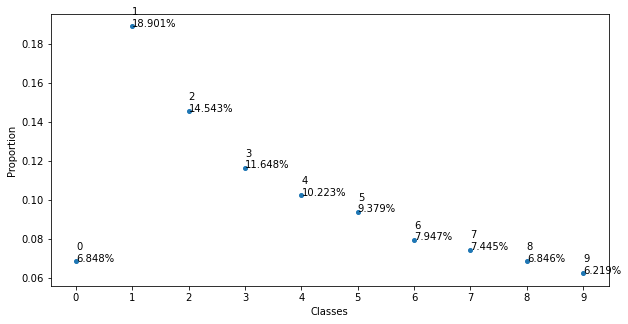

In [8]:
# partition the trainset
torch.manual_seed(0)
np.random.seed(0)
new_trainset, validationset= torch.utils.data.random_split(trainset,
  [len(trainset)-len(testset), len(testset)], generator=torch.Generator().manual_seed(0))
class_freq = np.zeros(10)
for i in range(len(new_trainset)):
  class_freq[new_trainset[i][1]]+=1
class_prop = class_freq/(len(new_trainset))
print(class_freq)
print(class_prop)

# plot the proportion
ax = plt.figure(figsize=(10,5)).add_subplot(111)
plt.plot(list(classes),class_prop, '.', ms=8)
plt.xlabel("Classes")
plt.ylabel("Proportion")
for i,j in zip(list(classes),class_prop):
    ax.annotate(i+'\n'+str(round(j*100,3))+'%',xy=(i,j))
plt.show()

In [9]:
sum(class_freq)

47225.0

In [10]:
# main body
config = {
    'lr': 0.001,
    'weight_decay': 5e-4
}


trainloader = torch.utils.data.DataLoader(
        new_trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
        validationset, batch_size=128, shuffle=False, num_workers=2)
net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
#scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30)
#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=300)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

train_loss_list=[] 
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

for epoch in range(1, 301):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    train_loss_list.append(train_loss) 
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))



Epoch: 1
iteration :  50, loss : 2.3751, accuracy : 16.53
iteration : 100, loss : 2.3005, accuracy : 17.37
iteration : 150, loss : 2.1694, accuracy : 22.66
iteration : 200, loss : 1.9115, accuracy : 32.52
iteration : 250, loss : 1.6752, accuracy : 41.33
iteration : 300, loss : 1.4923, accuracy : 48.11
iteration : 350, loss : 1.3504, accuracy : 53.24
Epoch :   1, training loss : 1.3080, training accuracy : 54.77, test loss : 1.2243, test accuracy : 63.28

Epoch: 2
iteration :  50, loss : 0.4546, accuracy : 86.06
iteration : 100, loss : 0.4424, accuracy : 86.60
iteration : 150, loss : 0.4364, accuracy : 86.78
iteration : 200, loss : 0.4349, accuracy : 86.75
iteration : 250, loss : 0.4229, accuracy : 87.09
iteration : 300, loss : 0.4164, accuracy : 87.30
iteration : 350, loss : 0.4143, accuracy : 87.34
Epoch :   2, training loss : 0.4128, training accuracy : 87.39, test loss : 0.4767, test accuracy : 85.48

Epoch: 3
iteration :  50, loss : 0.3723, accuracy : 89.20
iteration : 100, loss :

In [11]:
# the hold-out test set
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)
test_loss, test_acc = test(0, net, criterion, testloader)
test_loss, test_acc

(0.16281128386218174, 96.30454824830977)

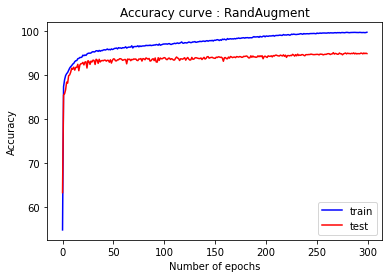

In [12]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curve : RandAugment")
plt.legend(['train', 'test'])
plt.show()

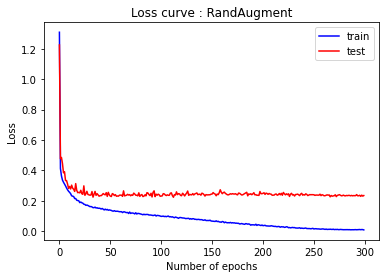

In [13]:
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss curve : RandAugment")
plt.legend(['train', 'test'])
plt.show()

In [14]:
print(f"train_loss_list_rand = {train_loss_list}") 
print(f"train_acc_list_rand = {train_acc_list}")
print(f"test_loss_list_rand = {test_loss_list}")
print(f"test_acc_list_rand = {test_acc_list}")

train_loss_list_rand = [1.3079642264985134, 0.41276279398742405, 0.3641065050996739, 0.33621111706020385, 0.32227574123276603, 0.3105190498880578, 0.2985378698645245, 0.2845963137703859, 0.27256943354115576, 0.2628671395867498, 0.25574022410361746, 0.24721774489172105, 0.23312961429276763, 0.2307181321791194, 0.22826595868925414, 0.21507334950453222, 0.21533063833468005, 0.20384218360027323, 0.20217743917774703, 0.2004433953503606, 0.18824751913385987, 0.1920065844285133, 0.187250267825314, 0.18458147579173084, 0.17769597254713698, 0.17646904064589722, 0.17025284326779164, 0.17242334513523713, 0.16955551344568168, 0.1653165416766796, 0.16184331506975297, 0.16270417981556437, 0.15991212547754208, 0.15523525618198442, 0.15527952850107254, 0.158528862697726, 0.15280010509822103, 0.15449475903861568, 0.15078019666760595, 0.15182626324132853, 0.1501983254340283, 0.1461215344810389, 0.14986899500172635, 0.14550365379892874, 0.1403558284175509, 0.14542140672361947, 0.1405470239094441, 0.14365

In [15]:
train_loss_list_01 = [2.3849518770770977, 2.2417600981911345, 2.2415069635644516, 2.2409557133186153, 2.2419579268147953, 2.240125378942102, 2.240931454066662, 2.2417839348800785, 2.242252948807507, 2.241471426273749, 2.241231945472035, 2.2413479971691843, 2.241036834432504, 2.2407813569717616, 2.2415969093963706]
train_acc_list_01 = [18.56855479089465, 18.617257808364215, 18.746426680783483, 18.60243515087348, 18.61937533086289, 18.886183165696135, 18.60243515087348, 18.598200105876124, 18.604552673372154, 18.740074113287452, 18.731604023292746, 18.814187400741133, 18.848067760719957, 18.82901005823187, 18.752779248279513]
test_loss_list_01 = [2.2387831538331273, 2.241503697984359, 2.241926829020182, 2.240557459055209, 2.2406100852816713, 2.252836311564726, 2.2468298743752873, 2.2446437150824305, 2.2425780202828203, 2.240177970306546, 2.243702617346072, 2.2441832843948815, 2.253918958645241, 2.245230858232461, 2.2435202879064224]
test_acc_list_01 = [18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 14.27858020897357, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463]
train_loss_list_001 = [2.2888378896687414, 2.232192633274771, 1.4893088792236193, 0.5001831288098643, 0.3830500937251218, 0.32867970416539405, 0.29770232389774426, 0.27895135900919354, 0.2627035691970732, 0.24814978033950336, 0.23438045485475198, 0.2243682525668364, 0.21301924496848731, 0.20818865677811266, 0.1958482328166322]
train_acc_list_001 = [18.50926416093171, 18.968766543144522, 47.80307040762308, 84.23292747485442, 88.15881418740074, 89.9142403388036, 91.04923239809423, 91.63790365272631, 92.08893594494441, 92.58020116463737, 93.03758602435151, 93.36791953414505, 93.715193223928, 93.84012705134992, 94.35044997353097]
test_loss_list_001 = [2.2451091665847627, 2.2302937355695986, 0.684039752711268, 0.4374444575286379, 0.39873581839834943, 0.36398082489476485, 0.3313831433507742, 0.3210300371854329, 0.2847569804346445, 0.29315854806233854, 0.27853756525791157, 0.26896954926789973, 0.2596830692069203, 0.26028463620619446, 0.2491153629460171]
test_acc_list_001 = [18.88060848186847, 19.053472649047325, 78.20759065765212, 86.33988936693301, 87.90334972341734, 88.90596189305471, 90.08143822987093, 90.81515058389674, 91.70636140135218, 91.54118008604794, 91.8638598647818, 92.2480024585126, 92.43239090350338, 92.50537799631223, 92.82037492317149]
train_loss_list_0001 = [1.8565612323885041, 0.5532636212785715, 0.4003713336094285, 0.3402645644860539, 0.309145948165639, 0.2848975209968523, 0.262982070708501, 0.24855145600026216, 0.2386487888167221, 0.2278864942390098, 0.21327269485164788, 0.20556094100683686, 0.19517452138549268, 0.18913837452608395, 0.18232752032436653]
train_acc_list_0001 = [34.7993647432504, 82.35468501852831, 87.65272631021705, 89.51614610905241, 90.6723133933298, 91.51932239280042, 92.26892535733192, 92.59925886712546, 92.97617787188989, 93.34674430915828, 93.69401799894123, 93.97353096876654, 94.31868713605083, 94.53255690841715, 94.71254632080466]
test_loss_list_0001 = [1.0861167063315709, 0.46979708385233787, 0.41340532643245714, 0.3364271931350231, 0.3262409484561752, 0.34040282589986043, 0.28803076817854945, 0.2942232322678262, 0.2779932311169949, 0.27514038454083833, 0.2478603608906269, 0.2512748020463714, 0.26197264781769586, 0.2462065773194327, 0.24985540344142446]
test_acc_list_0001 = [64.00583896742471, 85.58312845728334, 87.41933005531654, 89.81637984019667, 89.970036877689, 89.99308543331284, 91.59111862323294, 91.35295021511985, 91.82928703134604, 92.03672403196066, 92.76275353411187, 92.83574062692071, 92.90488629379226, 92.98555623847572, 92.87031346035648]
train_loss_list_00001 = [1.2440541174192092, 0.4583125376927497, 0.36052036624613815, 0.3151768069603256, 0.2875107263081119, 0.26835051384883196, 0.25187577066948097, 0.23390740957767336, 0.22118305101950317, 0.21190600004299545, 0.20555683115350845, 0.1952596850249018, 0.18612936185546683, 0.18178928815090883, 0.17480877608181986]
train_acc_list_00001 = [57.18581259925887, 85.53943885653786, 88.79618845950239, 90.25304393859184, 91.214399152991, 92.01058761249338, 92.36421386977237, 93.09899417681312, 93.43991529910005, 93.80412916887242, 93.86765484383271, 94.25092641609317, 94.500794070937, 94.64478560084702, 94.82477501323451]
test_loss_list_00001 = [0.5935118007017117, 0.43328142947718207, 0.3668157114994292, 0.34575528556517526, 0.3590214093964474, 0.3134572241893586, 0.2903973020467104, 0.28062032824199573, 0.26905518266208034, 0.26447016406146917, 0.27132851287138227, 0.26421160440818936, 0.25491809147391836, 0.24584030433028353, 0.2630316608895858]
test_acc_list_00001 = [80.93500307314075, 86.63567916410571, 88.97510755992624, 89.3438844499078, 88.99431468961278, 90.58466502765826, 91.54502151198525, 91.56422864167179, 92.02135832821143, 92.25184388444991, 91.97910264290104, 92.37861094038107, 92.72433927473878, 92.96250768285188, 92.59757221880763]


train_loss_list_const = [1.5944857293674293, 0.4869092239677745, 0.3710624326454592, 0.3296906750215101, 0.29884549410039496, 0.27146996971633697, 0.2604337949053382, 0.24417246496532022, 0.23419785655045575, 0.22457996957751147, 0.21173857996457315, 0.20202396321425917, 0.1943116241051414, 0.18745123495052501, 0.1774632519257424, 0.17214223601650902, 0.16552220173886797, 0.15473239550866733, 0.15404348591276948, 0.14213740165398372, 0.13690419029192066, 0.13265049481779578, 0.12643728150322348, 0.1223953123176647, 0.11572830584960256, 0.10872174589453028, 0.10607895330301306, 0.10143619665729645, 0.09846852844464908, 0.09155762590831373, 0.09176684167932689, 0.08320119946962853, 0.07973214024854547, 0.07931727142424037, 0.06983993944351063, 0.07091535234995448, 0.0671700671211713, 0.06470882359558974, 0.061619590856841586, 0.061459206172131346, 0.057121708876198427, 0.053374216585170206, 0.0498615506466044, 0.05073856983490308, 0.04987424655961312, 0.046790412364042994, 0.04711244383266544, 0.04263703334889801, 0.043034394194061555, 0.04126133985860339, 0.03625233271121373, 0.03783284285014904, 0.0379838087573284, 0.03416189216178284, 0.03383261713717981, 0.03370409071676403, 0.033968668481206325, 0.03165312097212274, 0.03038872497441464, 0.02841417055683044, 0.029356409022635036, 0.02889881345480024, 0.028939039615515447, 0.02568263415692672, 0.027656220918051838, 0.026301205131101617, 0.023402816848356156, 0.024891200900357974, 0.022950206206843942, 0.022271349775869285, 0.0250707899006071, 0.022344395426495713, 0.019562920480307198, 0.022191016989943715, 0.02281398802152065, 0.0203801996838415, 0.020550807893653537, 0.02117716848076041, 0.019771566791103416, 0.022764958889409142, 0.017198871523580392, 0.02078044665365311, 0.020109122048629333, 0.01588759385191313, 0.01774437841210012, 0.020397339600326397, 0.01534856222032823, 0.016435430918308794, 0.01711455919842304, 0.01770936636729633, 0.018040290616609177, 0.01564757464108749, 0.015251886521385311, 0.01534154344099917, 0.015427147975282334, 0.01419120683843651, 0.01811075882562171, 0.016642653122089984, 0.01305790530750528, 0.013949767823940267, 0.014656124457392462, 0.013457846312966957, 0.014343252129156173, 0.013850259383991146, 0.012460459422866397, 0.012413865320129272, 0.013889214684304953, 0.01221698466477806, 0.015144580592092777, 0.010421825547786688, 0.01315658220278792, 0.014559990600058128, 0.012665790851758906, 0.01143317199561781, 0.011717887349175301, 0.011158559258571676, 0.012634062059679534, 0.011741106513152792, 0.012515452659958159, 0.011751638104695717, 0.011457235534427129, 0.011438692509360596, 0.012512708038015468, 0.008602326916451698, 0.010682771495822786, 0.011196336384384224, 0.009268063090769713, 0.009998142540840234, 0.012729091897495166, 0.010267185127698763, 0.010566324319321028, 0.010713477439735606, 0.010119398856430022, 0.012654226244056406, 0.009628543746825273, 0.0102562899387879, 0.010169452542220153, 0.011113815507671713, 0.01246779066452764, 0.007518461719419533, 0.007389902458939484, 0.011104748547043264, 0.01135712010794771, 0.008941290669380526, 0.009924649224834431, 0.009838336234147059, 0.007612355080635734, 0.009282812758648675, 0.008423602285464519, 0.009065308554876006, 0.010365516194014629, 0.006115070432431249, 0.006490228478146479, 0.011122480412586441, 0.00872685812082587, 0.008791860558152852, 0.009787340952780856, 0.008418811355189983, 0.007423892029066022, 0.009898100130695444, 0.008828991230531168, 0.007722080036888794, 0.009378696144602659, 0.00829515335842403, 0.006554383687879633, 0.006126663065066873, 0.010910632581322311, 0.007716069375264186, 0.006358072765228986, 0.007697185452836498, 0.008877029283653514, 0.008559577807589543, 0.00707696825589556, 0.00850764569837624, 0.0062317561151193695, 0.0066259507287960455, 0.008618629247509826, 0.007878521594295732, 0.007498281048782551, 0.006598806819186967, 0.006230976371933824, 0.006141664580167378, 0.007923200858393221, 0.008045455975570557, 0.00792612456981016, 0.007601726206049413, 0.007419711852838272, 0.004584900550783639, 0.00685006011318293, 0.008050930358640324, 0.008370204849807444, 0.005507358266772813, 0.006857401374734981, 0.008172955556791895, 0.004244687181667273, 0.008633549227632837, 0.008705449396538356, 0.0067560189635043925, 0.006710546794999935, 0.00550614756518684, 0.0069180619830691474, 0.00835907400430254, 0.005712247417545953, 0.006098340349643973, 0.007154704712266156, 0.0061693518397019, 0.005750073719051822, 0.005536363746094307, 0.006909997050809464, 0.006392437509654407, 0.004530645426771153, 0.00935107147158372, 0.005991038718238898, 0.004413133404240297, 0.007152540924743997, 0.006123794079590131, 0.004265024197029019, 0.007488072243164834, 0.006849384789138319, 0.006199823599835201, 0.004939858833603685, 0.006542191565922548, 0.006134184821023406, 0.006127372573951168, 0.006120713498504846, 0.005705225819374859, 0.0054501006014126396, 0.00476737067947397, 0.005204442173390228, 0.006888031104115721, 0.005438639611901732, 0.005198591940753804, 0.006226397409455738, 0.00398913007948585, 0.006725981141281091, 0.0057350191533619786, 0.004547678196042624, 0.003760278201966155, 0.004862335098237806, 0.0053206211415940214, 0.004511028374038128, 0.006714381331292853, 0.006507630908786355, 0.004150821972775074, 0.005154698122662017, 0.005662354828146746, 0.004606740834664833, 0.004731273036621596, 0.004916682220897782, 0.0048261530498232945, 0.006001339212270287, 0.007263619651073496, 0.0038986454153652154, 0.005036929771996826, 0.005049693082181207, 0.00644224065052205, 0.004578751418381182, 0.004686958738437559, 0.003585059260631736, 0.003101582141557616, 0.007221638428928184, 0.005000114876925785, 0.0051700827908760325, 0.005254589704386773, 0.00406367993565528, 0.0036232792127412505, 0.006171727926178867, 0.005875237415135579, 0.00392443083374783, 0.006561909474143628, 0.0037487958143322068, 0.004443046452993911, 0.005447318903908573, 0.004017829913798502, 0.00472008602112813, 0.0055074588290326305, 0.005279580161203713, 0.0036886348879267314, 0.0035813810519778975, 0.004883374933941502, 0.004846986711028166, 0.004054715485154408, 0.004949977601104352, 0.0046826732979178415, 0.004384392334953691, 0.004187341836835158, 0.004243570542040143, 0.005868256121943751, 0.00557879406272601, 0.0037290168971954394, 0.0024883511193469366, 0.004939023949055762, 0.004748034648033541, 0.0038421762496379727, 0.003486280636854575, 0.0036575751641310756, 0.00670746078328728, 0.004645855993902198, 0.004636629221823842, 0.004005611049817734]
train_acc_list_const = [44.03176283748015, 84.49761778718899, 88.61196400211752, 89.87400741132875, 91.01958708311275, 91.79460031762838, 92.2350449973531, 92.80889359449444, 93.03546850185283, 93.37427210164108, 93.80412916887242, 94.0052938062467, 94.38009528851244, 94.6278454208576, 94.88618316569614, 95.01323451561673, 95.1868713605082, 95.66543144520911, 95.57226045526734, 95.91953414505029, 96.01905770248808, 96.16093170989942, 96.35150873478031, 96.54632080465855, 96.74113287453679, 96.86183165696136, 96.96347273689783, 97.10746426680784, 97.21757543673901, 97.32133403917416, 97.3276866066702, 97.63896241397565, 97.72154579142403, 97.7342509264161, 97.88883006881949, 97.87400741132875, 97.96506087877184, 98.09211222869243, 98.24245632609846, 98.17257808364214, 98.28692429857067, 98.34833245103229, 98.44997353096876, 98.49444150344097, 98.49655902593965, 98.54102699841185, 98.55796717840127, 98.67443091582848, 98.63419798835362, 98.74219163578613, 98.87559555320276, 98.77607199576495, 98.78030704076231, 98.9793541556379, 98.94970884065643, 98.9433562731604, 98.90947591318158, 98.98782424563261, 98.96453149814717, 99.08099523557438, 99.05770248808894, 99.05134992059291, 99.0428798305982, 99.1784012705135, 99.13393329804128, 99.1148755955532, 99.20381154049761, 99.18051879301217, 99.27580730545262, 99.23980942297511, 99.1784012705135, 99.25674960296453, 99.3499205929063, 99.26310217046056, 99.2503970354685, 99.32874536791954, 99.28215987294865, 99.27157226045527, 99.29486500794071, 99.24404446797247, 99.42615140285865, 99.2779248279513, 99.31180518793012, 99.46214928533615, 99.40921122286925, 99.36262572789836, 99.49602964531498, 99.43673901535203, 99.42615140285865, 99.40921122286925, 99.41132874536792, 99.47697194282689, 99.49602964531498, 99.49814716781366, 99.47273689782953, 99.5044997353097, 99.39015352038115, 99.45156167284277, 99.57649550026468, 99.55320275277924, 99.5404976177872, 99.5659078877713, 99.53414505029116, 99.54685018528322, 99.58073054526204, 99.5849655902594, 99.49391212281631, 99.58920063525674, 99.51720487030175, 99.66543144520911, 99.5574377977766, 99.56167284277396, 99.56802541026998, 99.60402329274748, 99.62519851773425, 99.6019057702488, 99.5934356802541, 99.62519851773425, 99.60402329274748, 99.61461090524087, 99.61461090524087, 99.63790365272631, 99.6019057702488, 99.70566437268396, 99.66119640021175, 99.64002117522499, 99.69507676019057, 99.68025410269983, 99.58920063525674, 99.6569613552144, 99.62519851773425, 99.6569613552144, 99.66754896770779, 99.54261514028586, 99.69719428268925, 99.63366860772896, 99.67178401270513, 99.60825833774484, 99.6019057702488, 99.75436739015352, 99.75436739015352, 99.59555320275278, 99.62731604023293, 99.6929592376919, 99.65484383271573, 99.66966649020645, 99.7289571201694, 99.71836950767602, 99.69084171519323, 99.67601905770249, 99.66119640021175, 99.79671784012704, 99.78824775013234, 99.62519851773425, 99.71836950767602, 99.72683959767072, 99.68872419269455, 99.73107464266808, 99.73107464266808, 99.67601905770249, 99.70989941768131, 99.73319216516676, 99.68025410269983, 99.7204870301747, 99.78824775013234, 99.80518793012176, 99.64849126521969, 99.73107464266808, 99.79883536262572, 99.74377977766014, 99.69719428268925, 99.69719428268925, 99.77130757014294, 99.71625198517734, 99.7924827951297, 99.784012705135, 99.70354685018528, 99.75860243515088, 99.73319216516676, 99.79036527263102, 99.78189518263632, 99.79036527263102, 99.73530968766543, 99.69719428268925, 99.75013234515616, 99.72472207517205, 99.76071995764956, 99.84330333509793, 99.784012705135, 99.73530968766543, 99.69084171519323, 99.82212811011117, 99.76919004764426, 99.73319216516676, 99.85812599258867, 99.70989941768131, 99.70142932768661, 99.76071995764956, 99.78824775013234, 99.8284806776072, 99.7924827951297, 99.7204870301747, 99.8009528851244, 99.81577554261514, 99.75436739015352, 99.7924827951297, 99.81365802011646, 99.8009528851244, 99.77554261514028, 99.77977766013764, 99.85389094759132, 99.67601905770249, 99.81789306511382, 99.86871360508205, 99.74377977766014, 99.78189518263632, 99.84965590259397, 99.77130757014294, 99.78824775013234, 99.82001058761249, 99.81365802011646, 99.77130757014294, 99.78189518263632, 99.79883536262572, 99.80730545262044, 99.82636315510852, 99.79036527263102, 99.83059820010588, 99.81154049761778, 99.7564849126522, 99.8094229751191, 99.8284806776072, 99.81154049761778, 99.88353626257279, 99.75224986765484, 99.79671784012704, 99.85389094759132, 99.88565378507147, 99.83059820010588, 99.80730545262044, 99.84118581259926, 99.77130757014294, 99.81154049761778, 99.85177342509265, 99.83271572260455, 99.8094229751191, 99.8284806776072, 99.86236103758603, 99.8369507676019, 99.82424563260984, 99.8009528851244, 99.78824775013234, 99.84330333509793, 99.82636315510852, 99.8284806776072, 99.78189518263632, 99.85812599258867, 99.85177342509265, 99.89624139756485, 99.89835892006353, 99.77130757014294, 99.84118581259926, 99.81577554261514, 99.8369507676019, 99.85600847008999, 99.86659608258337, 99.81154049761778, 99.79671784012704, 99.87718369507677, 99.79883536262572, 99.85812599258867, 99.85389094759132, 99.83906829010058, 99.88353626257279, 99.84753838009529, 99.8369507676019, 99.83906829010058, 99.88565378507147, 99.87506617257809, 99.83271572260455, 99.84330333509793, 99.85812599258867, 99.86659608258337, 99.8369507676019, 99.8284806776072, 99.84753838009529, 99.85177342509265, 99.7924827951297, 99.79671784012704, 99.88141874007411, 99.92376919004765, 99.86024351508735, 99.84753838009529, 99.85600847008999, 99.87506617257809, 99.87718369507677, 99.79671784012704, 99.86024351508735, 99.85177342509265, 99.87083112758073]
test_loss_list_const = [0.9403148495099124, 0.46971940738605517, 0.34306909633325594, 0.3384028169892582, 0.3164549315823059, 0.31764499748162195, 0.282772644879479, 0.27239831069520876, 0.2788072020618939, 0.2605946859454407, 0.2569786167758353, 0.25151387514436946, 0.23040011815507622, 0.23389688687508597, 0.23323347488893012, 0.22432381940969065, 0.23885389055837603, 0.22965874502837075, 0.23512107754747072, 0.23369459731175618, 0.22183155821745887, 0.2491116562639089, 0.23399925456546686, 0.25359821337841304, 0.23499618255186314, 0.22481991891183106, 0.2324665375966944, 0.23745987874766192, 0.24356824685545528, 0.24952035153503804, 0.23930090873082185, 0.25436064657554325, 0.25367995643732594, 0.26609678615761156, 0.2672480665622096, 0.2746706861893044, 0.25824960023529975, 0.26025373894063863, 0.2791316908072023, 0.26918739248432366, 0.2763673086997633, 0.2997446244436444, 0.2916372886438872, 0.3003798500981693, 0.2806282534501424, 0.2931029381979184, 0.29610180335265457, 0.3087221756942716, 0.32797835285172744, 0.30948590080929445, 0.31205729929292025, 0.3264701991711798, 0.31612680869761345, 0.3249107254029927, 0.3218845636081681, 0.3128845189679779, 0.3158182442261308, 0.3337518404621412, 0.34533743259003935, 0.32409434777447116, 0.3321887091642209, 0.3324712138604738, 0.33405348602864965, 0.3346349073199592, 0.3316200801226146, 0.35435040097446274, 0.3272651647738017, 0.3605334343612377, 0.3315225986252521, 0.36446072681642633, 0.37520757036320135, 0.3792235794586732, 0.3674935271379118, 0.3611337201596767, 0.35125305392213313, 0.3664919300844856, 0.3579704279956572, 0.358177753384499, 0.37499817195074525, 0.3516562903372973, 0.36848902222061275, 0.37098927200570997, 0.37174441270968495, 0.3886868230103716, 0.36849470644751015, 0.3531273581982389, 0.3660184144471571, 0.37421249364520986, 0.3748011891273599, 0.3667490633350669, 0.3643053767691348, 0.37450089440772344, 0.37444961906465535, 0.3669995936729452, 0.37039543743080955, 0.38952702733085437, 0.39265704210208474, 0.3686957350274658, 0.3655954713695774, 0.39540933398529887, 0.37815322328870205, 0.3858970995974161, 0.37387897242682383, 0.37425000457020074, 0.38926156392941874, 0.3786647673787586, 0.37843504400156874, 0.4000659274078869, 0.38383779517721894, 0.38883355182513374, 0.38116612786189746, 0.39886108679952575, 0.4039541971048011, 0.4085461224575399, 0.4040325807553588, 0.40590017215878355, 0.38623136059180196, 0.38693335685221586, 0.41144327609343273, 0.3980357802459313, 0.4007313655798926, 0.40366758222636934, 0.38523547610669745, 0.42097171660804866, 0.4246416387294291, 0.40921079142786126, 0.4052840040850581, 0.4231068941344525, 0.38739459854824576, 0.4194799537094785, 0.41747657055327414, 0.4164134435739149, 0.3939945743985328, 0.393845445202554, 0.4172966992665155, 0.4208380446276244, 0.408174136686641, 0.43686796033608855, 0.3842315211042981, 0.4022488394277353, 0.41533097460427704, 0.4123304054533661, 0.3947430606748836, 0.4344836208585869, 0.42245670334509045, 0.4120090134880122, 0.4084896664774301, 0.4208405370477076, 0.4342218170389898, 0.4342225538966173, 0.414541769489719, 0.42016579197290554, 0.43672865715023934, 0.3970657474470927, 0.4120631425404081, 0.4072342333657777, 0.4361969401840778, 0.40728934426043256, 0.4082725720443562, 0.43000999789721533, 0.4488575828864294, 0.4490402939628956, 0.42708765610358584, 0.4119907574152903, 0.4171651719850214, 0.46127884272559017, 0.424621216852364, 0.42663686249551236, 0.443727373143238, 0.4234333980655042, 0.4163527505554478, 0.41962003758446514, 0.43725314623146666, 0.4135830312939909, 0.4485339165719993, 0.438206387026345, 0.42548432996423513, 0.4139385414218493, 0.422614497990877, 0.44258191624619797, 0.5020544356643679, 0.42181872726217207, 0.45136614169414135, 0.42586187040889817, 0.4617275644605066, 0.42785005136758236, 0.4181436715811929, 0.43456211805745376, 0.456493051905258, 0.4419752404130265, 0.439949865836431, 0.458016514120733, 0.45355927485370023, 0.4266304138993077, 0.4774111132959233, 0.43147677636942733, 0.42984621565533326, 0.4257584124226888, 0.41347907219703, 0.44227188734301165, 0.44509480125270784, 0.42359101505694435, 0.45620652116542937, 0.4532003666402078, 0.4544208156419735, 0.4288948582868804, 0.45772276510365817, 0.4652134206776014, 0.4481767811538542, 0.45044724102926387, 0.45808432965228957, 0.4832801581086481, 0.4330355538119215, 0.450099578350965, 0.44405912482818843, 0.4245691280629413, 0.47918898603130206, 0.4441465862088508, 0.4232571859679678, 0.42079631317699073, 0.46119900758140814, 0.4447093260310152, 0.45832808096619215, 0.4615354106998911, 0.46208279893970955, 0.44396297247651234, 0.44644354116719437, 0.4640259245666219, 0.466397661642701, 0.46452038604811785, 0.4498248620908342, 0.4491576017337103, 0.465446551038208, 0.47035092626716574, 0.4713521593012938, 0.4597488452506927, 0.4512224776633814, 0.48416280633240355, 0.4734927043455708, 0.46729338517887337, 0.46055449181357305, 0.44595291037751617, 0.45059747884606977, 0.4550898942740305, 0.4553583972247354, 0.484807043427638, 0.47273430763972085, 0.45941312947109636, 0.4590342458538419, 0.4751177701332113, 0.47533442642466694, 0.45637929342760175, 0.4544383191900766, 0.4463540438526109, 0.45517611408414427, 0.4642113188975582, 0.44581558580930325, 0.4676268981386195, 0.46861990691874833, 0.47670730448090565, 0.4613685188541079, 0.46828112538502203, 0.47280027833310706, 0.44121663249097764, 0.4606796685479554, 0.5259090004415781, 0.48354477134040175, 0.469667333146265, 0.4692415113266393, 0.45400641179944884, 0.47124824484846756, 0.4692198993460111, 0.44249545135900525, 0.4556816854969571, 0.4647824307538423, 0.47515893393360514, 0.44086019356972445, 0.47874322776481804, 0.48824521492911027, 0.4832109012732319, 0.45331234720138397, 0.46669590011166007, 0.4659509803990231, 0.4592359331253843, 0.4794528412395248, 0.4734935767528619, 0.4946094546649678, 0.47707713397183255, 0.4516702479244593, 0.44164761501893984, 0.48553112554637823, 0.4603754159190929, 0.4560155915005096, 0.48063205852739366, 0.4870615708185177, 0.503982417563926, 0.4785489882890354, 0.44539653152848285, 0.4539821001874539, 0.47518135870204253]
test_acc_list_const = [71.6080208973571, 85.50245851259987, 89.67040565457899, 89.58589428395821, 90.46173939766442, 90.5577750460971, 91.50276582667486, 92.0520897357099, 91.96757836508912, 92.47464658881377, 92.6820835894284, 92.88952059004302, 93.56177012907192, 93.4580516287646, 93.66548862937923, 93.80377996312231, 93.34665027658266, 93.71158574062692, 93.5041487400123, 93.57329440688383, 94.06499692685925, 93.33896742470804, 93.72311001843885, 92.94330055316533, 93.68853718500307, 94.18792255685311, 93.96127842655194, 93.91518131530424, 93.82682851874615, 94.03042409342348, 94.1917639827904, 93.77304855562384, 93.9420712968654, 93.68853718500307, 94.08420405654579, 93.77304855562384, 93.91518131530424, 94.14566687154272, 93.93822987092808, 94.14566687154272, 94.06499692685925, 93.73079287031346, 93.8921327596804, 94.07267977873387, 94.01889981561156, 94.22633681622618, 93.86140135218193, 93.90749846342962, 93.97664413030117, 94.07652120467118, 94.03042409342348, 93.97280270436386, 94.21865396435157, 94.07267977873387, 94.09956976029503, 94.21865396435157, 94.30700676090964, 93.88444990780577, 94.06883835279656, 94.30316533497235, 94.23017824216349, 94.19944683466503, 94.05731407498463, 94.36846957590657, 94.26475107559926, 94.04578979717272, 94.31468961278426, 94.13030116779349, 94.3262138905962, 94.06499692685925, 93.98432698217579, 94.34926244622004, 94.3262138905962, 94.10341118623234, 94.35694529809466, 93.99969268592501, 94.21481253841426, 94.41840811309157, 94.13414259373079, 94.23017824216349, 94.39920098340504, 94.10341118623234, 94.0381069452981, 94.36846957590657, 94.44529809465274, 94.29548248309773, 94.39920098340504, 94.2839582052858, 94.34542102028273, 94.51444376152428, 94.34926244622004, 94.1418254456054, 94.45682237246466, 94.5221266133989, 94.41072526121697, 94.45298094652735, 93.9958512599877, 94.24938537185002, 94.57974800245852, 94.1418254456054, 94.18792255685311, 94.34926244622004, 94.48371235402581, 94.39535955746773, 94.39151813153042, 94.39535955746773, 94.41072526121697, 94.1418254456054, 94.24554394591273, 94.39535955746773, 94.49907805777505, 94.3262138905962, 94.22633681622618, 94.34542102028273, 94.42224953902888, 94.27627535341118, 94.46450522433928, 94.1840811309158, 94.1917639827904, 94.50291948371235, 94.09956976029503, 94.27243392747388, 94.38383527965581, 94.40304240934235, 94.10725261216963, 94.36462814996926, 94.52980946527352, 94.36078672403197, 94.50676090964966, 94.1917639827904, 94.25706822372464, 94.31084818684695, 94.43761524277812, 94.36462814996926, 94.42224953902888, 94.21097111247695, 94.38383527965581, 94.18023970497849, 94.21865396435157, 94.5259680393362, 94.53365089121081, 94.21865396435157, 94.56822372464659, 94.21865396435157, 94.31468961278426, 94.41072526121697, 94.50291948371235, 94.35310387215735, 94.51060233558697, 94.26090964966195, 94.3338967424708, 94.4299323909035, 94.40688383527966, 94.66425937307929, 94.41072526121697, 94.39535955746773, 94.23786109403811, 94.44145666871543, 94.30316533497235, 94.3761524277812, 94.04578979717272, 94.36846957590657, 94.3300553165335, 94.44145666871543, 94.64505224339274, 93.99200983405039, 94.53365089121081, 94.52980946527352, 94.3799938537185, 94.38767670559312, 94.54133374308543, 94.36078672403197, 94.44913952059004, 94.28779963122311, 94.48755377996312, 94.51828518746159, 94.4721880762139, 94.45682237246466, 94.39920098340504, 94.51444376152428, 94.10341118623234, 94.61432083589429, 94.41840811309157, 94.21865396435157, 94.46450522433928, 94.44913952059004, 94.4798709280885, 94.61432083589429, 94.22633681622618, 94.63352796558083, 94.51060233558697, 94.44145666871543, 94.5221266133989, 94.50291948371235, 93.93438844499079, 94.4721880762139, 94.48371235402581, 94.63736939151813, 94.5759065765212, 94.61047940995698, 94.39920098340504, 94.56822372464659, 94.21481253841426, 94.59895513214505, 94.32237246465888, 94.59127228027043, 94.25322679778733, 94.4299323909035, 94.54517516902274, 94.3338967424708, 94.40688383527966, 94.08420405654579, 94.5259680393362, 94.59895513214505, 94.6681007990166, 94.61047940995698, 94.44529809465274, 94.48371235402581, 94.48755377996312, 94.67962507682851, 94.36846957590657, 94.09572833435772, 94.35694529809466, 94.43377381684081, 94.55669944683467, 94.61047940995698, 94.36462814996926, 94.6220036877689, 94.69499078057775, 94.39535955746773, 94.47602950215119, 94.43761524277812, 94.3300553165335, 94.68730792870313, 94.56822372464659, 94.45298094652735, 94.61816226183159, 94.40304240934235, 94.48371235402581, 94.62968653964352, 94.54517516902274, 94.51828518746159, 94.60663798401967, 94.55669944683467, 94.50676090964966, 94.52980946527352, 94.59511370620774, 94.46066379840197, 94.40304240934235, 94.49139520590043, 94.4299323909035, 94.34157959434542, 94.6681007990166, 94.58358942839583, 94.61047940995698, 94.34926244622004, 94.57974800245852, 94.50676090964966, 94.71035648432698, 94.70651505838967, 94.5221266133989, 94.3761524277812, 94.50291948371235, 94.59127228027043, 94.52980946527352, 94.41456668715428, 94.53749231714812, 94.29932390903504, 94.5720651505839, 94.68730792870313, 94.61816226183159, 94.55285802089736, 94.6681007990166, 94.70651505838967, 94.59127228027043, 94.40304240934235, 94.69114935464044, 94.68730792870313, 94.5221266133989, 94.45682237246466, 94.51828518746159, 94.57974800245852, 94.61432083589429, 94.6220036877689, 94.34542102028273, 94.53749231714812, 94.40688383527966, 94.49523663183774, 94.42609096496619, 94.6757836508912, 94.42224953902888, 94.43377381684081, 94.56438229870928, 94.65273509526736, 94.49139520590043, 94.4721880762139, 94.3338967424708, 94.56054087277197, 94.70651505838967, 94.45682237246466]
train_loss_list_cosine = [1.4922631353059113, 0.4829037673670425, 0.3722163860390826, 0.33177220926375245, 0.30060175129876227, 0.2739472426776964, 0.2571369293057499, 0.24421742562517565, 0.23246381484315323, 0.22585582048670064, 0.2115350698794776, 0.2027042203842786, 0.19336028488953586, 0.18796989869901803, 0.17635167322467335, 0.17350608562712425, 0.16392932351688705, 0.15824737119157786, 0.15103116432623812, 0.14280527628211148, 0.13911624957976465, 0.12778460819445814, 0.12645664817696503, 0.12117257786202963, 0.11404008718162048, 0.11024573898614261, 0.10301367604352918, 0.09962807324661957, 0.09590673247266429, 0.09140933892338822, 0.08890839097617563, 0.08312069913650028, 0.07912878103322049, 0.07539688910895247, 0.0703017507051307, 0.06730901317161112, 0.06545131962347604, 0.06006853946239806, 0.05934957680948644, 0.055661115047034776, 0.05501487654656535, 0.04808283364715756, 0.048917624036854686, 0.04978224897863177, 0.04599738403836765, 0.043476243917943865, 0.04154425250810538, 0.044289368833225914, 0.039924735993999975, 0.038134503976484824, 0.03573395804436448, 0.03633099462935413, 0.03407486775469762, 0.03466019954098273, 0.03175460545031914, 0.030751291346965928, 0.02861118235254312, 0.026954070920645837, 0.026345375887917098, 0.027870583739497655, 0.02564559653584358, 0.02595152790995118, 0.02664908538916373, 0.017370514487667858, 0.02682043477352759, 0.02288949422978072, 0.023653404380517905, 0.021177587269342865, 0.01825827019425427, 0.020935813946993946, 0.02142309610224594, 0.021006980622225117, 0.017297085196421504, 0.020975425832167893, 0.016085938927383088, 0.019187606733535582, 0.016529617174421272, 0.017658664713450265, 0.017461861724943822, 0.01473946469002416, 0.013888732157426767, 0.018813401251478592, 0.018245284999345322, 0.013429369967483517, 0.013213716673361565, 0.014179550147890478, 0.013165565478723676, 0.013442610755386424, 0.011938090494525969, 0.013952531346849035, 0.012777711567658235, 0.01361946394184095, 0.01415981548655886, 0.0132249127186142, 0.008202303269795845, 0.013768190907590946, 0.01187117434464689, 0.011072834069390408, 0.011375907309212407, 0.008056683960140176, 0.010813868758558904, 0.010755819991023294, 0.011055263281323623, 0.009854590676922565, 0.009897416544746738, 0.007694702545891319, 0.010974907935630917, 0.009073475042950686, 0.00957946586983009, 0.008521491170432235, 0.009181163735296882, 0.008033073926435217, 0.0075308985053745, 0.007736907337884813, 0.008905222457779166, 0.0075535059801524005, 0.008956405532912782, 0.00652504011866664, 0.007371700082288889, 0.007105531808951359, 0.009608815764438242, 0.006718999051766881, 0.006360923469938631, 0.006009158956909616, 0.005984226889401126, 0.006414240613540077, 0.008046470651133564, 0.006813095370703897, 0.004941387222356937, 0.006961080895634556, 0.0061504495415253034, 0.0044804993527444515, 0.005129817030924186, 0.0051584241011990275, 0.005904302868943308, 0.007040096893751609, 0.006497695825108162, 0.006231063241578372, 0.0045172427992303645, 0.004859256595798965, 0.005357292924210756, 0.0036115553579709734, 0.004059441841032762, 0.003976077818785122, 0.004686579279045762, 0.0047765986038821135, 0.0052203105924466305, 0.004452093922426263, 0.00366650621972908, 0.004813907496713725, 0.003619882242262452, 0.003379426909955734, 0.003642032724296165, 0.003996376050219234, 0.0027063930590780893, 0.0038246032934270147, 0.0035842454059730284, 0.0031291756938454703, 0.003011805406823518, 0.004053137657470737, 0.003489878551598058, 0.002363212944410382, 0.003003648613003568, 0.002955618500260455, 0.002723948648240625, 0.0037992216377342554, 0.0022372855783796795, 0.002972214323449715, 0.0029076020603400095, 0.002062946104120749, 0.0018581666937362376, 0.002313281514427136, 0.0030319557007007047, 0.0023327526890917524, 0.001145549262753536, 0.0016048090303144983, 0.0012414230531554533, 0.0032581396387386516, 0.0029362018629135516, 0.001846583708184242, 0.0012200965248589121, 0.001480849612214921, 0.002236391388236972, 0.0015825234965880586, 0.0009787926420108245, 0.001177633173575748, 0.0017891079141621141, 0.001687879517755926, 0.0027874750058864543, 0.0015881228617325382, 0.0013229923813940598, 0.0013549324787301051, 0.0013446073458035835, 0.0015000026920124656, 0.0012523066383357765, 0.000858102498131121, 0.001035546338261591, 0.0019881639752974524, 0.0016324728715111814, 0.001434380197954095, 0.0009871888154247414, 0.0008098082351434123, 0.0006027996978315856, 0.0008483088922217938, 0.0007788997386943644, 0.0014305688407895846, 0.0007751793022755421, 0.0005314110757599325, 0.0008008613197451418, 0.0005263145778683319, 0.0005657160187561332, 0.0008550505100606119, 0.0004061993359216422, 0.0008238756363850807, 0.0004022425374623086, 0.0007475109217440491, 0.0008010522570415786, 0.0008719455779264424, 0.0008102537067081855, 0.0006836875085969626, 0.000508847326879101, 0.00048076220441707043, 0.0003452522178527452, 0.0005887742460472115, 0.0007575123468680768, 0.0007316459814930954, 0.0006069562958639393, 0.00040482217438505993, 0.000413289390024444, 0.0002512041357034269, 0.00035321101188540014, 0.0002289985919775472, 0.00031013075728369315, 0.00048718760862263036, 0.00024815363102110633, 0.0002127035124524638, 0.00040036594692248164, 0.00022304668872061623, 0.0002539508311412804, 0.00033001078329677927, 0.0005046333238317957, 0.0002472649033615957, 0.00045928622355630194, 0.00022344069632032276, 0.00026002821110843074, 0.00015903297622683538, 0.00040398000405654787, 0.0002816041986039678, 0.00024018690979448482, 0.00029882328487923265, 0.00034577957207554183, 0.00028206157859465874, 0.00017730721445880266, 0.00011439717115794378, 0.00023043857095496602, 0.00013369225500067483, 0.00022097409422235014, 0.00013705560435689807, 0.000107482878806249, 0.0002181373778419168, 9.028549420162597e-05, 8.780925534434591e-05, 0.00015708037552040194, 0.00013996531600239778, 0.00015848159901898015, 9.64823931015096e-05, 0.00021168788567095436, 0.000136050276398834, 0.00010472044780222292, 0.0002206477002030788, 0.00013934975601720095, 0.00010074895917807085, 9.32180454911494e-05, 0.0001472607405713623, 0.00011569483834266491, 7.036176643037457e-05, 0.0001351957850342979, 0.000159376835863944, 0.00010674569268919185, 0.0001185344251126515, 8.718404802724013e-05, 0.00011900450702660869, 0.00012125460894170754, 0.00011230571605721275, 0.00010454212349596384, 0.0001487989837777661, 6.830416546227417e-05, 6.393169394098347e-05, 0.00020005663507281302, 0.00010431355027100938, 0.00017086659031600928, 7.99108349451789e-05, 0.00011386882648142751, 9.478551902827757e-05, 0.00010300004370941282, 8.344318782375742e-05, 0.0001274786575664539, 8.525987476745569e-05, 7.452874058836112e-05, 0.00011550953129777401]
train_acc_list_cosine = [47.73742721016411, 84.54632080465855, 88.4425622022234, 89.96717840127052, 90.86712546320804, 91.64849126521969, 92.33245103229221, 92.79195341450503, 93.21757543673901, 93.32980412916888, 93.78295394388566, 94.04129168872419, 94.3928004235045, 94.53679195341451, 94.81206987824245, 95.05134992059291, 95.20169401799895, 95.48755955532027, 95.65484383271573, 95.92165166754897, 95.9640021175225, 96.39385918475384, 96.32186341979883, 96.55479089465325, 96.74748544203283, 96.74748544203283, 97.07146638433034, 97.24722075172049, 97.19640021175225, 97.32980412916888, 97.39332980412917, 97.62413975648491, 97.67496029645315, 97.79777660137638, 97.90365272631021, 97.96717840127052, 98.07940709370037, 98.21492853361568, 98.19163578613023, 98.32715722604553, 98.32292218104817, 98.55584965590259, 98.57702488088935, 98.43938591847538, 98.58973001588141, 98.68713605082054, 98.66807834833246, 98.61302276336686, 98.80359978824775, 98.78454208575967, 98.83748014822658, 98.80783483324511, 98.86077289571202, 98.89253573319216, 98.9433562731604, 99.02805717310747, 99.05982001058761, 99.13816834303864, 99.14452091053468, 99.0979354155638, 99.13393329804128, 99.1148755955532, 99.10217046056114, 99.45579671784013, 99.15510852302806, 99.22710428798305, 99.22498676548439, 99.32451032292218, 99.39650608787719, 99.32662784542086, 99.27368978295394, 99.3774483853891, 99.41132874536792, 99.29698253043938, 99.45367919534145, 99.3668607728957, 99.47061937533087, 99.43885653785071, 99.43250397035469, 99.51932239280042, 99.5404976177872, 99.33509793541556, 99.3774483853891, 99.5299100052938, 99.54473266278454, 99.5129698253044, 99.57014293276866, 99.57014293276866, 99.6294335627316, 99.48967707781895, 99.55320275277924, 99.5659078877713, 99.53202752779248, 99.58073054526204, 99.73742721016411, 99.53838009528852, 99.61461090524087, 99.6294335627316, 99.63366860772896, 99.7289571201694, 99.63155108523029, 99.64213869772367, 99.61884595023822, 99.71201694017999, 99.69084171519323, 99.74589730015882, 99.63790365272631, 99.72260455267337, 99.69719428268925, 99.72260455267337, 99.66754896770779, 99.70354685018528, 99.73954473266278, 99.72683959767072, 99.67601905770249, 99.73319216516676, 99.71625198517734, 99.80518793012176, 99.7289571201694, 99.77130757014294, 99.6929592376919, 99.7924827951297, 99.77766013763896, 99.784012705135, 99.80730545262044, 99.78613022763366, 99.76071995764956, 99.79036527263102, 99.83906829010058, 99.76707252514558, 99.7924827951297, 99.86659608258337, 99.84118581259926, 99.8284806776072, 99.79883536262572, 99.77977766013764, 99.79671784012704, 99.79671784012704, 99.83059820010588, 99.84965590259397, 99.8369507676019, 99.86871360508205, 99.89412387506617, 99.87083112758073, 99.85177342509265, 99.85177342509265, 99.81365802011646, 99.85389094759132, 99.87294865007941, 99.84118581259926, 99.87294865007941, 99.89200635256749, 99.88353626257279, 99.87294865007941, 99.90682901005823, 99.87506617257809, 99.87506617257809, 99.89624139756485, 99.90047644256221, 99.85812599258867, 99.88988883006881, 99.91953414505029, 99.90894653255691, 99.89412387506617, 99.90047644256221, 99.88988883006881, 99.92165166754897, 99.88777130757015, 99.90047644256221, 99.92588671254632, 99.93223928004235, 99.91953414505029, 99.88565378507147, 99.91953414505029, 99.95764955002647, 99.94917946003176, 99.95341450502912, 99.90471148755955, 99.91529910005293, 99.94070937003706, 99.95764955002647, 99.95764955002647, 99.93435680254103, 99.94706193753309, 99.9724722075172, 99.96611964002118, 99.9364743250397, 99.94282689253573, 99.91953414505029, 99.94706193753309, 99.94917946003176, 99.96188459502382, 99.95341450502912, 99.94917946003176, 99.95129698253044, 99.96823716251986, 99.97458973001588, 99.9364743250397, 99.9555320275278, 99.95129698253044, 99.9640021175225, 99.97458973001588, 99.97458973001588, 99.9640021175225, 99.97882477501324, 99.94706193753309, 99.97458973001588, 99.97882477501324, 99.9724722075172, 99.98094229751192, 99.98305982001058, 99.96188459502382, 99.98305982001058, 99.97035468501853, 99.98517734250926, 99.97458973001588, 99.95976707252514, 99.9640021175225, 99.9640021175225, 99.97670725251456, 99.98729486500794, 99.97670725251456, 99.98305982001058, 99.97670725251456, 99.97882477501324, 99.97882477501324, 99.97670725251456, 99.98305982001058, 99.98729486500794, 99.98517734250926, 99.98941238750662, 99.98941238750662, 99.98941238750662, 99.98729486500794, 99.98941238750662, 99.9915299100053, 99.98094229751192, 99.9915299100053, 99.98517734250926, 99.98094229751192, 99.98729486500794, 99.98941238750662, 99.98094229751192, 99.98941238750662, 99.98305982001058, 99.99364743250398, 99.98517734250926, 99.98729486500794, 99.98941238750662, 99.9915299100053, 99.98094229751192, 99.98305982001058, 99.9915299100053, 99.99576495500264, 99.98517734250926, 99.9915299100053, 99.98941238750662, 99.99576495500264, 99.99576495500264, 99.98941238750662, 99.99364743250398, 100.0, 99.9915299100053, 99.9915299100053, 99.98941238750662, 99.99576495500264, 99.98729486500794, 99.99576495500264, 99.99364743250398, 99.9915299100053, 99.99364743250398, 99.99364743250398, 99.99576495500264, 99.98941238750662, 99.9915299100053, 99.99788247750132, 99.98941238750662, 99.9915299100053, 99.99788247750132, 99.99576495500264, 99.99576495500264, 99.99364743250398, 99.9915299100053, 99.99576495500264, 99.99364743250398, 99.99364743250398, 99.99788247750132, 100.0, 99.98941238750662, 99.99576495500264, 99.99364743250398, 99.99576495500264, 99.9915299100053, 99.99576495500264, 99.99364743250398, 99.99576495500264, 99.9915299100053, 99.99788247750132, 99.99576495500264, 99.99576495500264]
test_loss_list_cosine = [0.8128060245630788, 0.43769084055926283, 0.3670157931160693, 0.3468363919094497, 0.320717461845454, 0.29874755628407, 0.2880513122414841, 0.27089574385215254, 0.2712526289636598, 0.25813622246770296, 0.27607545629143715, 0.2508813175281473, 0.23157318663217275, 0.23963026514313385, 0.23259784851004095, 0.21799716919514478, 0.2553474395992417, 0.23297278822271847, 0.23411084861293727, 0.24059130224015782, 0.22228851220479198, 0.23491562519441633, 0.23474602972832964, 0.24284341398115253, 0.2531394691699568, 0.2231898330809439, 0.23778781842659502, 0.2260036576612323, 0.2408501879476449, 0.2531653588601187, 0.2437402953521586, 0.25621635543511195, 0.25155149374668506, 0.25073284860335143, 0.24820336959708264, 0.2527083886933385, 0.265060295743466, 0.2638632501977697, 0.27953584988911945, 0.28330178079469237, 0.2898024614425559, 0.285278165183377, 0.28805743263322203, 0.29073836449898927, 0.3027702011898452, 0.3096775676069014, 0.30173745603921515, 0.3021223259468873, 0.30385272365574745, 0.3038429137702812, 0.31642839670473455, 0.31861640270068947, 0.3238279426963452, 0.3290770745598802, 0.3349987664123011, 0.3213929162525079, 0.33029763011590524, 0.34525904689422426, 0.3447993094028503, 0.330581444653445, 0.321795464146371, 0.3393226447423883, 0.33919910747813536, 0.36219359443102983, 0.34984895151437206, 0.34508059543155717, 0.3312660858683361, 0.3478064838449891, 0.37045160054649207, 0.36637233636871563, 0.3615635437069132, 0.34741060503338483, 0.36895488022698786, 0.3510999241478595, 0.3899413192069487, 0.3609655104285362, 0.3731252212287383, 0.38873775874940203, 0.3712333329387155, 0.37048297439354894, 0.39439879441816433, 0.373478519492874, 0.36712522848564033, 0.3914665420420979, 0.38469330903471394, 0.3913668092230664, 0.38145966287337096, 0.37784753624788103, 0.38290000464036766, 0.3881754014622785, 0.39466715339279057, 0.38420211229765533, 0.3928751589150588, 0.3871026979576723, 0.39617241206852827, 0.42028651262323063, 0.38088225707521334, 0.3810242618087168, 0.38620046643978534, 0.41002833922667536, 0.40598774530157883, 0.4145270490324965, 0.4107616166036357, 0.39369509952124576, 0.3983155651949346, 0.4124191829971239, 0.40144294117778245, 0.4075972944425017, 0.41423957538791, 0.4235737093589634, 0.4338786544680011, 0.41868019625818464, 0.4211389536400983, 0.42915419865783083, 0.43854167406428973, 0.44444839669135855, 0.4239410953870153, 0.4140438513154639, 0.4214930013826519, 0.4469692508014394, 0.42807763744620425, 0.4140391830473627, 0.40559402319109616, 0.4296429092794949, 0.447968863443855, 0.4537148197985017, 0.4160180985562357, 0.42932759126757875, 0.4655364652474721, 0.44017627959450084, 0.4476152099646153, 0.45807484502666723, 0.4661675389518267, 0.46650424552624864, 0.4483312015951264, 0.43905310305839806, 0.4307253006571794, 0.4221340075886224, 0.43024291792957514, 0.4534414633743319, 0.439005637879246, 0.455770535284982, 0.4492703357884916, 0.46906485925337266, 0.4463952654680493, 0.4687405661497192, 0.4440763243108842, 0.4453616064936653, 0.466629167502819, 0.4585120371433304, 0.45512742501017, 0.4547710154278606, 0.46565503765847166, 0.47993873200361054, 0.46249571734783695, 0.47604353346076667, 0.4764781709778689, 0.4798887720623729, 0.47362343249294686, 0.477798045156341, 0.475341152007162, 0.46233028874677773, 0.47649588846765895, 0.4905768512090778, 0.49597619045023605, 0.4826731762720966, 0.46256263993963526, 0.4635071344308409, 0.4836937281412675, 0.4737923650753538, 0.47685492698641896, 0.49306667890107514, 0.5079087016615542, 0.47638218596294596, 0.47670910018496215, 0.5044073596980203, 0.5164688170211864, 0.5278736670528922, 0.4981932266542286, 0.4995226736783105, 0.5136372742845732, 0.47614785384697217, 0.5164846121424845, 0.4969261799825985, 0.504426286427998, 0.5065735648545966, 0.5321676667674682, 0.5085760319283615, 0.5058678923307133, 0.505933805387102, 0.5226816843154237, 0.5136628734705714, 0.49541927424862103, 0.5014571096729853, 0.5036171923942782, 0.4995590589264883, 0.5177521720453275, 0.5068038706028578, 0.5099713094623796, 0.4981300873846254, 0.5104206896560523, 0.5262805088377539, 0.5344062875499767, 0.5306157725908812, 0.5357992586351055, 0.5134817360370767, 0.5160781835849562, 0.5250964877469575, 0.5374465012448091, 0.5358220952946473, 0.5378625886514783, 0.5421092164064711, 0.5452210189199403, 0.5411839835076392, 0.5549019162050065, 0.5455894065546054, 0.5472353847934773, 0.5522625445497825, 0.5455132025983367, 0.538114388518985, 0.5509232937326363, 0.536594347077577, 0.5530879087015694, 0.5591187921909652, 0.5578411847065368, 0.5505201403601163, 0.564152417302716, 0.5473365803345052, 0.5458330702511411, 0.5650019636080947, 0.5671965913600562, 0.5513512968934853, 0.5562908629117552, 0.5620296227371356, 0.5617975970529312, 0.5581122653555426, 0.5675084015614736, 0.5657756982859699, 0.5526409040846606, 0.5721038452220634, 0.5690990948042942, 0.5608643038853474, 0.5609114988775556, 0.560604001846692, 0.5697500870121397, 0.5728723204822517, 0.5595448732640886, 0.5570606883866632, 0.5764513230818671, 0.556780993596048, 0.5647389884220948, 0.5543315944429624, 0.5563175826808255, 0.5460904273889301, 0.5574481183030716, 0.552725079560689, 0.5607348622220075, 0.5605667959076955, 0.5626120614498515, 0.5649992083380507, 0.5637176143309083, 0.5681553194373526, 0.5555440176634446, 0.5632415316604059, 0.5714907293874478, 0.5667051952526284, 0.5770144956528812, 0.5655391789224072, 0.57731314366444, 0.5691993516018413, 0.5740196594384079, 0.5696190810367446, 0.5625503671834332, 0.5508576962696251, 0.5676857517648708, 0.575283505166333, 0.5721206341997958, 0.5749247564988977, 0.5699750101832929, 0.580029735533411, 0.5632244463092374, 0.5753009883919731, 0.5712149130710054, 0.5708004219147066, 0.5698616763567734, 0.5771289975888495, 0.577879674463332, 0.5692181185472245, 0.591953951887102, 0.5678756476480368, 0.5756764801849118, 0.578166978474816, 0.5680953554498652, 0.5808629620039616, 0.5650976837804431, 0.5722748214018294, 0.5711645722097042, 0.5751072838172024, 0.5794820262486681, 0.5856684064892047]
test_acc_list_cosine = [75.21511985248924, 86.48970497848802, 88.72157344806392, 89.39766441303011, 90.33113091579594, 91.21850030731407, 91.4259373079287, 92.23647818070067, 92.30562384757222, 92.6859250153657, 91.92532267977873, 92.7819606637984, 93.44652735095268, 93.21988322065151, 93.53872157344806, 93.85371850030731, 92.85494775660726, 93.56561155500921, 93.33512599877075, 93.48494161032575, 93.96896127842655, 93.75768285187462, 93.72311001843885, 93.5579287031346, 93.30439459127228, 94.19560540872772, 93.9459127228027, 94.2340196681008, 93.98048555623848, 93.700061462815, 94.24554394591273, 93.68085433312845, 93.82298709280884, 94.05731407498463, 94.24938537185002, 94.29164105716042, 93.83835279655808, 94.26090964966195, 94.03042409342348, 93.97280270436386, 94.00353411186232, 94.06883835279656, 94.13414259373079, 94.00737553779963, 94.12261831591887, 93.93822987092808, 94.16871542716656, 93.9958512599877, 93.96127842655194, 94.22249539028887, 93.93438844499079, 93.91518131530424, 94.0918869084204, 94.01121696373694, 94.15719114935465, 94.29164105716042, 94.31853103872157, 94.01889981561156, 94.15719114935465, 93.88060848186846, 94.54133374308543, 94.34542102028273, 94.14950829748003, 94.09572833435772, 94.36078672403197, 94.21481253841426, 94.3262138905962, 94.27627535341118, 93.92286416717886, 94.05731407498463, 94.09572833435772, 94.41456668715428, 94.24554394591273, 94.31853103872157, 94.24170251997542, 94.06115550092194, 94.0419483712354, 93.95359557467732, 94.30316533497235, 94.42224953902888, 94.1917639827904, 94.02274124154886, 94.43761524277812, 94.12645974185618, 94.20712968653964, 94.40304240934235, 94.35694529809466, 94.29164105716042, 94.48371235402581, 94.13030116779349, 94.31853103872157, 94.3338967424708, 94.41840811309157, 94.66041794714198, 94.48755377996312, 94.09956976029503, 94.26090964966195, 94.34157959434542, 94.38767670559312, 94.4798709280885, 94.38767670559312, 94.36078672403197, 94.16871542716656, 94.64505224339274, 94.36846957590657, 94.48371235402581, 94.28011677934849, 94.46450522433928, 94.28779963122311, 94.36078672403197, 94.35694529809466, 94.55285802089736, 94.35310387215735, 94.48755377996312, 94.34926244622004, 94.47602950215119, 94.64889366933005, 94.46450522433928, 94.44145666871543, 94.54133374308543, 94.52980946527352, 94.54901659496005, 94.69883220651506, 94.58743085433314, 94.16871542716656, 94.41456668715428, 94.56438229870928, 94.5759065765212, 94.21097111247695, 94.54517516902274, 94.44529809465274, 94.46834665027659, 94.27627535341118, 94.34157959434542, 94.71035648432698, 94.49139520590043, 94.60663798401967, 94.75645359557468, 94.74108789182544, 94.66041794714198, 94.59895513214505, 94.66041794714198, 94.57974800245852, 94.57974800245852, 94.71035648432698, 94.54901659496005, 94.7679778733866, 94.7679778733866, 94.56438229870928, 94.67194222495391, 94.66425937307929, 94.74492931776275, 94.79486785494775, 94.44529809465274, 94.73724646588813, 94.43761524277812, 94.72956361401353, 94.72572218807622, 94.74877074370006, 94.66041794714198, 94.4798709280885, 94.80639213275968, 94.61432083589429, 94.50676090964966, 94.70651505838967, 94.70651505838967, 94.59895513214505, 94.78334357713584, 94.76413644744929, 94.79870928088506, 94.69883220651506, 94.59511370620774, 94.42609096496619, 94.87169637369392, 94.86785494775661, 94.74492931776275, 94.74108789182544, 94.29932390903504, 94.86785494775661, 94.84864781807006, 94.68346650276582, 94.94852489244008, 94.69499078057775, 94.82175783650891, 94.86017209588199, 94.89090350338046, 94.6258451137062, 94.82559926244622, 94.83328211432084, 94.90242778119237, 94.88322065150584, 94.89090350338046, 94.96004917025199, 94.87553779963122, 94.9139520590043, 94.91779348494161, 94.99462200368777, 94.94852489244008, 94.85248924400737, 94.83712354025815, 94.90626920712968, 94.76029502151198, 94.78334357713584, 94.99078057775046, 94.88706207744315, 95.02151198524892, 94.97925629993854, 94.97541487400123, 94.87553779963122, 94.97541487400123, 94.88706207744315, 94.76413644744929, 94.84096496619546, 94.9638905961893, 94.96004917025199, 95.01382913337432, 94.99846342962508, 94.91011063306699, 94.92163491087892, 94.93315918869084, 94.9139520590043, 95.12907191149354, 95.03687768899816, 94.8640135218193, 94.82559926244622, 94.98693915181315, 94.90626920712968, 94.95236631837739, 94.98309772587585, 94.92931776275353, 94.74877074370006, 95.11754763368162, 95.02151198524892, 95.15596189305471, 94.98693915181315, 94.89858635525508, 94.99462200368777, 94.98693915181315, 95.07145052243392, 94.9638905961893, 94.97925629993854, 94.9638905961893, 94.98309772587585, 94.99462200368777, 94.95236631837739, 95.059926244622, 95.01767055931161, 95.11754763368162, 95.02919483712354, 95.13291333743085, 95.09834050399509, 95.109864781807, 95.159803318992, 95.16748617086662, 94.98693915181315, 95.22126613398893, 95.06376767055932, 95.12138905961893, 95.1521204671174, 95.04071911493547, 95.16364474492931, 95.17132759680393, 95.09834050399509, 95.1521204671174, 95.08681622618316, 95.059926244622, 95.20974185617702, 95.059926244622, 95.02151198524892, 95.14443761524278, 95.109864781807, 95.12907191149354, 95.17901044867855, 95.20974185617702, 95.17132759680393, 95.17132759680393, 95.19437615242778, 95.02151198524892, 95.17132759680393, 95.12907191149354, 95.19437615242778, 95.19821757836509, 95.12907191149354, 95.09449907805778, 95.109864781807, 95.24431468961278, 95.12907191149354, 95.16748617086662, 95.01382913337432, 95.22894898586355, 95.06760909649662, 95.11370620774431, 95.21742470805162, 95.159803318992, 95.22894898586355, 95.14059618930547, 95.109864781807, 95.14827904118009, 95.13675476336816, 95.09449907805778]
train_loss_list_step = [1.5044204033810271, 0.49208608810817644, 0.37830603914209177, 0.33356322168415475, 0.30051283241529775, 0.2731129997548695, 0.25931339448464275, 0.24751879757416603, 0.23341218238762076, 0.22551919120114025, 0.21245744068246225, 0.20461816869696303, 0.19351729513385754, 0.18888680500591673, 0.1790498158513369, 0.17313903582794718, 0.16563977062863708, 0.15938490460599017, 0.1541340289319434, 0.14407484958246147, 0.13983443950815252, 0.13245242257630277, 0.12638695052443805, 0.12125968426304458, 0.11788717211605249, 0.11147532753424269, 0.10493720971996869, 0.10114793143257862, 0.0986312177905505, 0.09325535373060603, 0.06156983597173802, 0.050082290781091464, 0.04566037622696864, 0.042090283896077454, 0.037587769078418896, 0.03525592588446025, 0.034040165755286976, 0.031216950466235478, 0.030938032096463855, 0.029107897011765093, 0.02691679777953582, 0.024817724369887797, 0.02327188092970408, 0.022008026162917072, 0.021083637177603455, 0.020199724932410693, 0.020445302296316296, 0.01811823503557229, 0.016885934063002497, 0.016305384605991728, 0.015734232263797315, 0.01582022506202922, 0.01498541162761943, 0.013855328222454038, 0.012501976389670114, 0.011526370763357194, 0.012135067156394237, 0.011748958516110058, 0.01063293406628148, 0.010577014861956521, 0.009060478683824204, 0.00822005160518879, 0.007903504668233972, 0.0073660259777244665, 0.007953700653634155, 0.006759841606805863, 0.0069558188274406844, 0.007026840372753726, 0.006894602971896024, 0.0063807274687209935, 0.006584282455781946, 0.006663436767551165, 0.006154599042466102, 0.006103539849245962, 0.006048463034234704, 0.00614482418276391, 0.006322457585395453, 0.006028014029933677, 0.006245754332408476, 0.00581059281254909, 0.005709030747089944, 0.005923201890116833, 0.00537758718227695, 0.005807922808844647, 0.005243748521360034, 0.004974289045318631, 0.005323306708443634, 0.005775554073696229, 0.005093053230784864, 0.005536427160324011, 0.0052108629591284105, 0.004749226128792285, 0.005127630246161776, 0.005065120122888249, 0.004685268356975264, 0.005243820296808683, 0.0049121043785080205, 0.005093204319377071, 0.005370734221114888, 0.005008859195898547, 0.005249464887712999, 0.004638611593474268, 0.004728934781005616, 0.005035177127017733, 0.004871168427265863, 0.005197190184529169, 0.004969428170602996, 0.004836069228517858, 0.005308753678475464, 0.004877718586694237, 0.0046394178739258, 0.004715173941094246, 0.005071522070231865, 0.005326596872854554, 0.004782932753934018, 0.00452435254143787, 0.005128751716483132, 0.004405792564614916, 0.005072576416472445, 0.004683375086275378, 0.004745950062742184, 0.005199869099014116, 0.004980171865863766, 0.004840858398257126, 0.0046297258561474545, 0.004515150684752434, 0.005211585615480793, 0.0046955638231178315, 0.004485690257187711, 0.004824536544108968, 0.004908301922912914, 0.005288558260384356, 0.004324457162535601, 0.004497020012851448, 0.004832310812420976, 0.004629586771150122, 0.00469785524222389, 0.0051049072852895816, 0.004760202388700317, 0.00467975922823293, 0.004756802660750659, 0.004577458516745399, 0.0046352100029977686, 0.0045855785586362005, 0.0045302773612948275, 0.00527981271794404, 0.004842230399004512, 0.005128007588957292, 0.0047336897144657575, 0.00452429031405685, 0.004871112167589785, 0.004707888855899686, 0.004987144301444176, 0.004576647475924656, 0.0050210763291275344, 0.004869554478370365, 0.005145938421950075, 0.0049324849194394005, 0.005007630027365255, 0.004694439974090723, 0.005161294266647788, 0.005086089323139447, 0.0045723088694465674, 0.0049315163145030455, 0.005043683056833177, 0.004782498019489051, 0.005208640262013842, 0.004906343821498318, 0.004504839811582297, 0.004765471186647242, 0.004636792729359163, 0.0048650642755604795, 0.00440384292277286, 0.005331020985203442, 0.004309070902481564, 0.005132160800841049, 0.0048202084057818, 0.0042395592619208135, 0.004579358937877841, 0.004854094481356265, 0.004861267090400903, 0.004641431140822869, 0.004752275634260134, 0.005280723348089562, 0.0049866622946490744, 0.004713922302353166, 0.0049851976106240516, 0.0049522482596579456, 0.0047414097434517405, 0.005198805679831853, 0.005367297160049249, 0.004801289511232152, 0.004936103088396973, 0.004513620775553264, 0.005461517685133368, 0.005038318795404084, 0.004621399451298942, 0.004861979541443869, 0.004728190580562456, 0.00424972596940481, 0.004389661508080736, 0.004675524760544651, 0.004678315578823907, 0.005468495250993464, 0.004904287783485815, 0.004628283689890138, 0.004957924133196958, 0.004207717516179686, 0.004497190112673026, 0.0054004669855449725, 0.004738672002041044, 0.004832978636525801, 0.004593934473861766, 0.00428500973297249, 0.004800252157330026, 0.004579809123577946, 0.0047766751335504105, 0.004927973183699149, 0.003962443585616099, 0.005313499298157754, 0.005448946752569696, 0.004626204171514537, 0.00486521731347835, 0.00464669697920995, 0.00473364783223967, 0.0051715146905747635, 0.004559630797677459, 0.004807513805560901, 0.004414798407140251, 0.0055058369074104515, 0.004735360263094689, 0.00523965430700253, 0.004729446927025576, 0.0046202187999946675, 0.004473174700221971, 0.005083680975845281, 0.00473606128646736, 0.004358955291625135, 0.004462744230992882, 0.00445035025452959, 0.004661599569843557, 0.004881452044679059, 0.004753526896741532, 0.004433994836329803, 0.004789544894031266, 0.004920090539939323, 0.005374149948520697, 0.004787621462456112, 0.004773729829575745, 0.0044936602159881545, 0.004565336937149469, 0.004793149001421886, 0.004954056282359589, 0.00447947610881707, 0.004911790105014495, 0.004962967739427566, 0.004856595992693377, 0.0049429370942105965, 0.004495315723300048, 0.005116432885005868, 0.004663471084030195, 0.005105866048162296, 0.0048063792890729005, 0.004996042520567828, 0.0048235019935209174, 0.0052012274302681025, 0.004979272351725164, 0.004979745390991236, 0.005170751338667516, 0.004858217863982788, 0.004663840651548111, 0.005053441917670759, 0.004584236903877065, 0.004780888221675258, 0.004612757356412744, 0.004703525326821731, 0.005128545914503725, 0.005097627184756964, 0.004888794860495936, 0.004546376856262884, 0.0049637655482588335, 0.004738951851973477, 0.005256142429007358, 0.004507868475276601, 0.004676521270572799, 0.0042853716939203765, 0.004519075942008067, 0.004505532296253924, 0.004830542344546013, 0.004257976696643534, 0.004718432969060035, 0.004490681710655531, 0.004793198622190861, 0.004690485046958793, 0.004381172440937899, 0.004597538895479108, 0.0050219146489527905, 0.004799934776746264, 0.004984567811975109, 0.004093347564194513]
train_acc_list_step = [47.394388565378506, 84.38962413975648, 88.32609846479619, 89.65802011646373, 90.93912122816305, 91.76071995764956, 92.30492323980943, 92.69878242456326, 93.1371095817893, 93.283218634198, 93.84859714134463, 93.97988353626258, 94.4203282159873, 94.56643726839597, 94.83324510322922, 95.06405505558496, 95.14452091053468, 95.38168343038645, 95.61461090524087, 95.86871360508205, 95.94282689253573, 96.23928004235044, 96.33456855479089, 96.51667548967708, 96.58231868713605, 96.79618845950239, 96.97829539438857, 97.11805187930122, 97.2006352567496, 97.23451561672843, 98.32927474854421, 98.71254632080466, 98.81630492323981, 98.94970884065643, 99.04499735309687, 99.05558496559026, 99.12969825304394, 99.22075172048703, 99.16993118051879, 99.24616199047115, 99.32027527792482, 99.33721545791424, 99.38168343038645, 99.40285865537321, 99.45156167284277, 99.46426680783483, 99.43885653785071, 99.49814716781366, 99.51932239280042, 99.55320275277924, 99.58073054526204, 99.56379036527264, 99.56379036527264, 99.6209634727369, 99.65907887771307, 99.68237162519851, 99.61884595023822, 99.62731604023293, 99.69507676019057, 99.72260455267337, 99.73742721016411, 99.7564849126522, 99.76919004764426, 99.79883536262572, 99.7649550026469, 99.83906829010058, 99.80307040762308, 99.81154049761778, 99.81154049761778, 99.83271572260455, 99.8009528851244, 99.82424563260984, 99.8369507676019, 99.82424563260984, 99.83906829010058, 99.83483324510323, 99.8369507676019, 99.84965590259397, 99.82636315510852, 99.83059820010588, 99.83906829010058, 99.84118581259926, 99.86236103758603, 99.85600847008999, 99.86236103758603, 99.87083112758073, 99.8369507676019, 99.8284806776072, 99.84753838009529, 99.85600847008999, 99.85389094759132, 99.87083112758073, 99.85812599258867, 99.86024351508735, 99.88353626257279, 99.85600847008999, 99.87506617257809, 99.85600847008999, 99.86236103758603, 99.84753838009529, 99.85600847008999, 99.87930121757543, 99.86236103758603, 99.8644785600847, 99.85177342509265, 99.86024351508735, 99.85389094759132, 99.85812599258867, 99.84330333509793, 99.86024351508735, 99.87718369507677, 99.86871360508205, 99.85812599258867, 99.84753838009529, 99.86659608258337, 99.87083112758073, 99.85389094759132, 99.88988883006881, 99.86024351508735, 99.87718369507677, 99.86659608258337, 99.84118581259926, 99.87083112758073, 99.85812599258867, 99.88777130757015, 99.88988883006881, 99.84542085759661, 99.87294865007941, 99.87083112758073, 99.85177342509265, 99.86024351508735, 99.86236103758603, 99.87506617257809, 99.8644785600847, 99.86024351508735, 99.86659608258337, 99.86871360508205, 99.85600847008999, 99.87083112758073, 99.87294865007941, 99.87294865007941, 99.88353626257279, 99.86236103758603, 99.87930121757543, 99.87930121757543, 99.86024351508735, 99.86024351508735, 99.83483324510323, 99.8644785600847, 99.89200635256749, 99.87083112758073, 99.84965590259397, 99.84965590259397, 99.88141874007411, 99.84753838009529, 99.87506617257809, 99.85389094759132, 99.85812599258867, 99.86236103758603, 99.85600847008999, 99.85600847008999, 99.84118581259926, 99.87930121757543, 99.86024351508735, 99.85812599258867, 99.86871360508205, 99.85389094759132, 99.86236103758603, 99.87718369507677, 99.85812599258867, 99.87083112758073, 99.85600847008999, 99.87506617257809, 99.87506617257809, 99.88777130757015, 99.85812599258867, 99.85600847008999, 99.88777130757015, 99.86659608258337, 99.87718369507677, 99.86659608258337, 99.86659608258337, 99.88141874007411, 99.85177342509265, 99.85600847008999, 99.87718369507677, 99.86236103758603, 99.87930121757543, 99.87506617257809, 99.85177342509265, 99.84118581259926, 99.86236103758603, 99.85812599258867, 99.87506617257809, 99.82636315510852, 99.85600847008999, 99.87718369507677, 99.88353626257279, 99.87294865007941, 99.89624139756485, 99.88353626257279, 99.87718369507677, 99.87083112758073, 99.84542085759661, 99.8644785600847, 99.88141874007411, 99.85600847008999, 99.89412387506617, 99.88141874007411, 99.85177342509265, 99.85389094759132, 99.87930121757543, 99.88565378507147, 99.88353626257279, 99.86871360508205, 99.86871360508205, 99.8644785600847, 99.86871360508205, 99.89624139756485, 99.84330333509793, 99.84542085759661, 99.88353626257279, 99.86236103758603, 99.87930121757543, 99.87506617257809, 99.87083112758073, 99.87294865007941, 99.87294865007941, 99.86871360508205, 99.84330333509793, 99.86659608258337, 99.84542085759661, 99.87506617257809, 99.8644785600847, 99.89200635256749, 99.84542085759661, 99.86871360508205, 99.87506617257809, 99.88141874007411, 99.87083112758073, 99.87083112758073, 99.86659608258337, 99.86659608258337, 99.86871360508205, 99.88565378507147, 99.87083112758073, 99.84753838009529, 99.88777130757015, 99.87718369507677, 99.88353626257279, 99.87083112758073, 99.86236103758603, 99.87718369507677, 99.88777130757015, 99.84965590259397, 99.85600847008999, 99.86236103758603, 99.85812599258867, 99.87718369507677, 99.8644785600847, 99.86024351508735, 99.87506617257809, 99.8644785600847, 99.8644785600847, 99.87930121757543, 99.85177342509265, 99.86024351508735, 99.85177342509265, 99.84118581259926, 99.86871360508205, 99.87718369507677, 99.86024351508735, 99.88988883006881, 99.8644785600847, 99.88141874007411, 99.87506617257809, 99.85177342509265, 99.86871360508205, 99.87506617257809, 99.87506617257809, 99.87930121757543, 99.86871360508205, 99.85812599258867, 99.88988883006881, 99.88353626257279, 99.89412387506617, 99.87930121757543, 99.86659608258337, 99.86659608258337, 99.88988883006881, 99.87083112758073, 99.87506617257809, 99.87083112758073, 99.87718369507677, 99.87930121757543, 99.87083112758073, 99.84330333509793, 99.87718369507677, 99.87294865007941, 99.88565378507147]
test_loss_list_step = [0.7521707053278007, 0.41922322909037274, 0.3967930445191907, 0.35680990534670215, 0.3250766685049908, 0.30643289908766747, 0.27803952721696273, 0.26461896110399097, 0.26403681638047977, 0.2668783114309989, 0.2609864034708224, 0.25131638298797254, 0.24851202544774495, 0.24535505795011334, 0.23515790532909187, 0.23713360856488055, 0.2406249167215006, 0.24633904404061682, 0.22870721204169825, 0.23081522924350759, 0.23210598513776182, 0.23380596216256713, 0.23264140811036615, 0.2492445185597913, 0.24672274596477842, 0.23322659500819795, 0.2332557491848574, 0.2325650899324055, 0.2574915187433362, 0.23942345477567584, 0.21860766188953729, 0.22490006466122234, 0.22599033247588166, 0.2330661828027052, 0.23813083913980745, 0.2410290090677639, 0.25265564182408007, 0.25388093285408675, 0.25897152009694013, 0.2653597001095905, 0.267472947769634, 0.2757880237756991, 0.28352711534164116, 0.2891207381023788, 0.2937827925471699, 0.3016136303891008, 0.29683313752506296, 0.3059604737939605, 0.31242154799766986, 0.313900034299449, 0.3219801964347853, 0.33177046875889393, 0.3355082166837711, 0.33843776536192377, 0.34364481102309974, 0.3455076480613035, 0.34563379169569586, 0.35321818167051555, 0.35429473890576, 0.35551488774317297, 0.36010582940470354, 0.35364405492631096, 0.3636273516743791, 0.36364757276012327, 0.35665451670887277, 0.3549169595261999, 0.3703063836905594, 0.36219835961146246, 0.3605355029998749, 0.3578162646861564, 0.36774474406140106, 0.3633771698702784, 0.3653042366746448, 0.3691165424956411, 0.36504066177625577, 0.3715900047225695, 0.377250660302154, 0.3705682765610297, 0.3703488810170515, 0.37351591648606985, 0.37677567382343113, 0.37160208523638694, 0.3709423184650494, 0.3721590631769276, 0.3763345616011351, 0.3800408639488559, 0.37680745827874135, 0.3771674718214747, 0.3848353975142042, 0.3798498407590623, 0.3773468048494382, 0.3819653425073507, 0.3785710880149375, 0.37396970703654614, 0.37354924148131236, 0.38423583746029466, 0.3775230319622685, 0.36990976165614875, 0.3731101816017911, 0.3812584620443921, 0.3834761079017292, 0.38286398570327196, 0.3858671422372116, 0.3799955192816389, 0.3770175949378195, 0.3851937071338077, 0.38235137271968755, 0.38205398502303106, 0.38025479872400564, 0.3843826920378442, 0.38355313671533675, 0.3811237645043316, 0.37951354816665545, 0.3756716687428564, 0.38028262046110983, 0.38163883488296585, 0.38113248269712807, 0.38293040138395396, 0.38826611508414444, 0.3821931903378344, 0.3927168071534777, 0.3814124613087259, 0.38783683029788674, 0.384523262598497, 0.3777104146395098, 0.3834854347001323, 0.37351655306331083, 0.37643494215958256, 0.38091917734081837, 0.3816218973667014, 0.38416977602915436, 0.3851156278796421, 0.3824646536297366, 0.37491797317988146, 0.3818769982979432, 0.37861419655382633, 0.3842346754938583, 0.37655236199498177, 0.37527537754024654, 0.37987153332077844, 0.3830455071018899, 0.3794875234803733, 0.38347619624041457, 0.39262797689868834, 0.37537328259763764, 0.3836479137067263, 0.3833252173236699, 0.37210422399563386, 0.387080483238998, 0.3719306717816211, 0.37743640282446994, 0.3764378684846794, 0.37271541687568616, 0.37936363588361177, 0.3804472682075392, 0.371879458409168, 0.38374935142586336, 0.3781576618488294, 0.3732976428844838, 0.3825277503210065, 0.37921793430167083, 0.38190348801550034, 0.3811836604795912, 0.3839620574760963, 0.3847266497711341, 0.3755092674263698, 0.38182204500680755, 0.3782161524446279, 0.383978412504874, 0.3785792852560168, 0.37529283202728075, 0.38586872027200814, 0.37986113718144743, 0.3781509461410928, 0.385330743640296, 0.3866525995362477, 0.3780062812672672, 0.38378071400574315, 0.38093069549102115, 0.38920295537065935, 0.38671026251041424, 0.3797818386251582, 0.3798417299438049, 0.3740828680422376, 0.38145504804218516, 0.38200287843196123, 0.3875016655645096, 0.38280217152308016, 0.38698648213974984, 0.3808485120260978, 0.38649215569317924, 0.3831135995238654, 0.3805198727321683, 0.38389426964682105, 0.38486584148132336, 0.3807648518761876, 0.3849117392856701, 0.38554816227406263, 0.38357163151251333, 0.3802410184734446, 0.3815109624947403, 0.382021243195506, 0.3853015545938237, 0.377494075719048, 0.38711871966427447, 0.3774435311857173, 0.3905071147407095, 0.3806642469603057, 0.38146250298721535, 0.3838621310104488, 0.39097126777849944, 0.38649382303450625, 0.3796885114930132, 0.38229777593183895, 0.3814927838633166, 0.37877432031410874, 0.37605211639082897, 0.37402715621625676, 0.3860787514177169, 0.3734693876285033, 0.3757060868665576, 0.3836308258823028, 0.3818031575019453, 0.3754675344144012, 0.3817046451035376, 0.3788763102984019, 0.38524902579100695, 0.3789480691410455, 0.383543092720941, 0.39350814419780294, 0.3787268260402568, 0.3791520138837251, 0.3838299135951435, 0.3793616016559741, 0.3767985271874304, 0.3790097143866268, 0.37912912847583785, 0.38894346707007466, 0.3742955804382469, 0.38342078903909116, 0.3848988146238102, 0.37459168269061577, 0.38242888645561157, 0.3820874952601598, 0.38645922241951614, 0.37736037103276626, 0.37371054134450343, 0.3787742013148233, 0.3864014833873394, 0.38398269388605566, 0.3823276355716528, 0.38692381239368345, 0.38753888685731036, 0.37855833295878827, 0.37346514290673477, 0.37298866356814314, 0.3816173101830132, 0.3767242920311058, 0.3841047031056209, 0.38750297252965327, 0.369205586767445, 0.3753658247490724, 0.38275528518373475, 0.3800859667141648, 0.3870932775020015, 0.37551862878414494, 0.3840912418421723, 0.3726249620291021, 0.37941730108486454, 0.38384662088298915, 0.37976392629720707, 0.37775822057772207, 0.38208118103006306, 0.3800909294399853, 0.37907081163104844, 0.3812881442672555, 0.3761177863743083, 0.38076628101350485, 0.37963548230518607, 0.3693312196718419, 0.37269937157557875, 0.3810739266987452, 0.37098004634254705, 0.38030854867332997, 0.3809964715083148, 0.37681868622152537, 0.3750186215574835, 0.3816620926098788, 0.3736031973351012, 0.38245252669588026, 0.3819549302798787, 0.38419706475756626, 0.3735217913966991, 0.3787470100191878, 0.37715579814040195, 0.3867923977976555, 0.3815506379960068, 0.3814866198135503, 0.3853403181933305, 0.3877864530602214]
test_acc_list_step = [75.81054087277197, 86.9660417947142, 87.58451137062077, 89.28242163491088, 90.1160110633067, 91.05331899200984, 91.73325138291334, 92.37092808850646, 92.390135218193, 92.24031960663798, 92.37092808850646, 92.9778733866011, 93.1737861094038, 93.04701905347265, 93.41963736939152, 93.37738168408113, 93.3159188690842, 93.0278119237861, 93.7077443146896, 93.72695144437616, 93.68853718500307, 93.78073140749846, 93.73847572218807, 93.26213890596189, 93.30055316533497, 93.93438844499079, 94.06883835279656, 94.11877688998156, 93.6040258143823, 94.0419483712354, 94.87553779963122, 94.83712354025815, 94.81023355869699, 94.87169637369392, 94.91779348494161, 94.89474492931777, 94.86785494775661, 94.84096496619546, 94.71419791026429, 94.56054087277197, 94.75645359557468, 94.73724646588813, 94.64889366933005, 94.64889366933005, 94.69499078057775, 94.72956361401353, 94.6757836508912, 94.74492931776275, 94.6220036877689, 94.65273509526736, 94.54901659496005, 94.53749231714812, 94.63352796558083, 94.61816226183159, 94.61432083589429, 94.5221266133989, 94.64121081745544, 94.56054087277197, 94.74492931776275, 94.61047940995698, 94.59127228027043, 94.75645359557468, 94.75645359557468, 94.66425937307929, 94.73340503995082, 94.6757836508912, 94.53365089121081, 94.64505224339274, 94.66041794714198, 94.70267363245236, 94.6258451137062, 94.75645359557468, 94.80255070682237, 94.67962507682851, 94.58358942839583, 94.54517516902274, 94.6258451137062, 94.7180393362016, 94.66425937307929, 94.6681007990166, 94.61432083589429, 94.78718500307313, 94.76029502151198, 94.68730792870313, 94.64121081745544, 94.62968653964352, 94.69114935464044, 94.58743085433314, 94.58358942839583, 94.64889366933005, 94.69114935464044, 94.70651505838967, 94.70267363245236, 94.66041794714198, 94.69883220651506, 94.61432083589429, 94.71419791026429, 94.82559926244622, 94.69883220651506, 94.72572218807622, 94.49523663183774, 94.75261216963737, 94.61047940995698, 94.64505224339274, 94.64889366933005, 94.66041794714198, 94.70267363245236, 94.55669944683467, 94.65657652120467, 94.6681007990166, 94.77566072526122, 94.85633066994468, 94.66041794714198, 94.78334357713584, 94.79102642901044, 94.63352796558083, 94.78718500307313, 94.64505224339274, 94.56438229870928, 94.73340503995082, 94.61047940995698, 94.68730792870313, 94.70267363245236, 94.61432083589429, 94.67194222495391, 94.77181929932391, 94.73724646588813, 94.64505224339274, 94.69499078057775, 94.65273509526736, 94.69883220651506, 94.6757836508912, 94.71035648432698, 94.69883220651506, 94.67194222495391, 94.66425937307929, 94.6757836508912, 94.76029502151198, 94.75645359557468, 94.70267363245236, 94.64505224339274, 94.74108789182544, 94.54133374308543, 94.54901659496005, 94.74877074370006, 94.67962507682851, 94.67194222495391, 94.67194222495391, 94.69883220651506, 94.8140749846343, 94.64121081745544, 94.7180393362016, 94.74492931776275, 94.78334357713584, 94.65273509526736, 94.5759065765212, 94.61816226183159, 94.61047940995698, 94.76413644744929, 94.79870928088506, 94.67962507682851, 94.69114935464044, 94.72572218807622, 94.60663798401967, 94.5720651505839, 94.75261216963737, 94.80255070682237, 94.70267363245236, 94.66041794714198, 94.66425937307929, 94.69114935464044, 94.72188076213891, 94.68730792870313, 94.55285802089736, 94.75645359557468, 94.64505224339274, 94.7180393362016, 94.53749231714812, 94.72572218807622, 94.65657652120467, 94.6258451137062, 94.61432083589429, 94.72188076213891, 94.77566072526122, 94.62968653964352, 94.66041794714198, 94.54901659496005, 94.6757836508912, 94.66425937307929, 94.55669944683467, 94.7679778733866, 94.74877074370006, 94.68346650276582, 94.63352796558083, 94.5759065765212, 94.61047940995698, 94.66425937307929, 94.71419791026429, 94.59895513214505, 94.61816226183159, 94.72956361401353, 94.7180393362016, 94.67194222495391, 94.68346650276582, 94.59127228027043, 94.76029502151198, 94.69499078057775, 94.66041794714198, 94.6681007990166, 94.69499078057775, 94.64889366933005, 94.67962507682851, 94.78718500307313, 94.67962507682851, 94.77950215119853, 94.6757836508912, 94.74492931776275, 94.84096496619546, 94.73340503995082, 94.72188076213891, 94.69883220651506, 94.61047940995698, 94.5720651505839, 94.72572218807622, 94.70651505838967, 94.6681007990166, 94.6258451137062, 94.64121081745544, 94.65657652120467, 94.48371235402581, 94.6757836508912, 94.73724646588813, 94.59895513214505, 94.70651505838967, 94.76029502151198, 94.75645359557468, 94.76413644744929, 94.6220036877689, 94.72188076213891, 94.7180393362016, 94.66425937307929, 94.6681007990166, 94.62968653964352, 94.71419791026429, 94.68346650276582, 94.69883220651506, 94.69114935464044, 94.70267363245236, 94.60663798401967, 94.67194222495391, 94.55285802089736, 94.59895513214505, 94.66041794714198, 94.61432083589429, 94.59895513214505, 94.73724646588813, 94.63352796558083, 94.73724646588813, 94.77566072526122, 94.60279655808236, 94.76413644744929, 94.74108789182544, 94.65273509526736, 94.58743085433314, 94.59511370620774, 94.80255070682237, 94.61047940995698, 94.71035648432698, 94.65273509526736, 94.6681007990166, 94.75261216963737, 94.72188076213891, 94.61816226183159, 94.65657652120467, 94.79870928088506, 94.64121081745544, 94.66425937307929, 94.69883220651506, 94.64889366933005, 94.83712354025815, 94.69883220651506, 94.71419791026429, 94.77181929932391, 94.63352796558083, 94.74492931776275, 94.69883220651506, 94.61816226183159, 94.73340503995082, 94.73724646588813, 94.67194222495391, 94.72956361401353, 94.69114935464044, 94.77181929932391, 94.65657652120467, 94.68346650276582, 94.60663798401967, 94.64889366933005, 94.72188076213891, 94.70651505838967, 94.70267363245236]
train_loss_list_linear = [1.0505396097010067, 0.41031305952285363, 0.34015994405924144, 0.3038505317194029, 0.27671615290771007, 0.2539030461090044, 0.24293845730422312, 0.2313264879753919, 0.22205986383403867, 0.21279181394635177, 0.20017173882260877, 0.19267895106014196, 0.18516845405505603, 0.18218227440546844, 0.17281363284604012, 0.16757936995264475, 0.1608044776490064, 0.1526946394343363, 0.1503949542921087, 0.14460325269861435, 0.1379334318267338, 0.13074936200347212, 0.12652073063834654, 0.12361395870888137, 0.11955785878043027, 0.11495751238915171, 0.10918548092407586, 0.10549298947964741, 0.10151599690843081, 0.09746526491886312, 0.09452159306524084, 0.09095732697353857, 0.08772212413056352, 0.08348307219462667, 0.08420775942554884, 0.07539896097104885, 0.07707164484154443, 0.07315899130855473, 0.07151561531902047, 0.06873627238071506, 0.06587666986752452, 0.060232834865876696, 0.059981180607343754, 0.06175297403930204, 0.05708458852451951, 0.05296678836066225, 0.057111382709063976, 0.053133565748266894, 0.05266129370491073, 0.050845057070684346, 0.04849550221115351, 0.0469664877891379, 0.04695639163596419, 0.04652371517443136, 0.04273645039004221, 0.042981587787635805, 0.040151388551610795, 0.03779632822411049, 0.04038962408859879, 0.04276739005321198, 0.035970243897294085, 0.0389290425395164, 0.034595519276827996, 0.034754975707721986, 0.03550548981976138, 0.034968214722219, 0.033513369056052934, 0.033747713374943145, 0.03146642715614011, 0.03088276023026253, 0.03096695340504784, 0.030255960882325888, 0.029922214430077934, 0.026458163596317426, 0.030674233368527256, 0.026803990912770092, 0.028383832357679988, 0.029045142340322395, 0.026921882543196714, 0.025758919344589033, 0.027054627095336514, 0.026907914471629563, 0.02701804478293749, 0.026367548554233428, 0.0261913293705708, 0.02126370853306549, 0.023870387598386333, 0.02343241305678558, 0.026290576351723865, 0.024439686884867598, 0.02106365902915024, 0.022621461096346544, 0.022915108798849105, 0.026723837544939667, 0.021479926218290063, 0.022599881692684752, 0.02025709556021947, 0.019150306689010323, 0.0245601841217654, 0.02191897199554167, 0.01751039288937257, 0.019330726730524307, 0.019164910448808477, 0.024538845911642237, 0.015059424295682626, 0.020382445553086728, 0.022040061389306198, 0.018767614002140155, 0.019355695793985044, 0.019107737408797596, 0.017818392037986942, 0.017417942697963446, 0.021768966118750215, 0.017869346996114355, 0.017951215525590914, 0.01640004834187341, 0.01777675135988997, 0.019044938084980482, 0.015788522874557873, 0.022552578193564623, 0.019296770346089745, 0.014811130384146363, 0.015027894850487148, 0.018469126043487265, 0.018098258266041212, 0.014053442152699729, 0.015989337644331865, 0.018125206405116463, 0.016060621967932922, 0.014774189744400855, 0.01385672290374157, 0.018077892058706895, 0.01727216446030504, 0.014268980369684513, 0.015724211079724697, 0.016640492273927766, 0.014277730624145401, 0.016971004403142326, 0.014619164786088283, 0.016830329990812937, 0.01374343925469295, 0.012524507506886185, 0.01549116191725552, 0.013598875393053052, 0.0151209402418879, 0.014543565561276227, 0.01439005304061679, 0.01173475706005888, 0.016134371224896974, 0.011917180406560032, 0.012485065904832735, 0.0135999512963786, 0.01591276152397482, 0.011587380154317354, 0.009772636422980987, 0.01344329923276031, 0.015756404174912624, 0.014378462400149205, 0.014014234783006126, 0.012014912663851542, 0.01611480384725613, 0.012844832076313767, 0.013578993814619104, 0.011672752483787808, 0.014098815763512592, 0.012935566670426325, 0.015032568787632202, 0.012224024389351091, 0.014372231721552152, 0.011108738588597336, 0.011174887407980897, 0.016397042357398143, 0.007919598232576864, 0.011932518933157513, 0.012465056306042874, 0.012968409797498517, 0.012325529049170838, 0.011099239793170491, 0.011867815633636468, 0.012848886264346762, 0.012182228031996032, 0.011562556203482023, 0.010714672763688681, 0.013554639555182596, 0.012572727286869529, 0.01000095399527329, 0.011995266647266443, 0.011573533052920085, 0.012627172824654724, 0.013339461832399402, 0.010677528724291735, 0.011543188395016422, 0.010650319310586942, 0.009674460366150607, 0.010641892690030602, 0.012230279986791725, 0.01145689182891605, 0.01050705676828164, 0.00970218700554869, 0.011088927940358716, 0.010147759896973753, 0.0144252521625949, 0.009280225094541092, 0.0071248399373703905, 0.013807516299508516, 0.01255990872180107, 0.011576532107942895, 0.008876261175843192, 0.009988300831966212, 0.00985363164915767, 0.01084158176923064, 0.011923880645647825, 0.010890684340816107, 0.011154608579179295, 0.010417346872992216, 0.00848533340091224, 0.009280508183635208, 0.012399288785308195, 0.0072954312946646145, 0.007857306191068237, 0.013135696996073112, 0.007985612870672613, 0.009203406998578557, 0.011825267453099425, 0.009498726522558978, 0.010254976841146922, 0.012558721663513307, 0.007996204799592626, 0.007471766532690587, 0.01177365344033834, 0.010632048703338191, 0.01163114502161057, 0.008471069070895856, 0.008329393120841747, 0.010546008776983772, 0.007213423388353836, 0.009344507342992069, 0.01120725078885267, 0.008723668579122892, 0.008438797396795254, 0.009862698597215867, 0.011641287900165775, 0.009182740705942006, 0.00702334287046593, 0.010164535000019891, 0.008744396335386742, 0.009129313499368456, 0.008084669785307412, 0.010208096987843342, 0.011367271971373962, 0.007117051272343865, 0.008831601460626934, 0.00922884266564445, 0.009587360389017516, 0.008383878850809764, 0.007664171105706518, 0.010088089144474219, 0.007183663350923383, 0.010528553138330638, 0.010388069153280813, 0.008873608166863086, 0.007134666277026189, 0.00842848956719368, 0.008079520347828268, 0.009280271344362845, 0.008955260842407897, 0.010437573963957794, 0.007464409461843186, 0.00868264229136562, 0.008687793158964795, 0.008216140737795655, 0.007891892086514802, 0.007512410591053153, 0.008665417990315836, 0.008976994133145053, 0.008162402152780846, 0.008810677293791461, 0.006835815719566462, 0.007850608918254282, 0.010575828147088042, 0.008934358710317107, 0.0076927311314263745, 0.007455576667292384, 0.005771527193367357, 0.008088972039366073, 0.011438270648105747, 0.005829402718917685, 0.009437662637821316, 0.006043440636937449, 0.007854135620251515, 0.009180552848274084, 0.010004485826416422, 0.007954190094466415, 0.0069836680795018575, 0.006469878575636705, 0.008808609063802835, 0.007791922163181544, 0.006387679697369947, 0.009282423594551585, 0.007415674569260415]
train_acc_list_linear = [64.05293806246691, 87.14875595553202, 89.55002646903124, 90.75913181577555, 91.62308099523557, 92.33456855479089, 92.87030174695606, 93.13922710428798, 93.25780836421387, 93.82106934886183, 94.23822128110112, 94.36315510852303, 94.60667019587083, 94.74007411328745, 95.01111699311805, 95.09158284806776, 95.25674960296453, 95.67178401270513, 95.61461090524087, 95.74377977766014, 95.9915299100053, 96.22869242985706, 96.29645314981472, 96.45526733721546, 96.42985706723134, 96.65431445209106, 96.86818422445738, 96.87241926945474, 97.08628904182108, 97.16040232927475, 97.2641609317099, 97.3361566966649, 97.35309687665432, 97.51191106405506, 97.51191106405506, 97.76601376389624, 97.7342509264161, 97.88035997882477, 97.82953943885654, 97.96717840127052, 98.00317628374802, 98.16622551614611, 98.13658020116463, 98.11540497617787, 98.1937533086289, 98.37374272101641, 98.19798835362626, 98.44150344097406, 98.33562731604023, 98.41821069348862, 98.43303335097936, 98.4923239809423, 98.5643197458973, 98.4923239809423, 98.66807834833246, 98.64902064584436, 98.69348861831656, 98.76971942826893, 98.68925357331922, 98.64690312334568, 98.82053996823716, 98.74219163578613, 98.81842244573849, 98.86500794070938, 98.88194812069878, 98.78877713075701, 98.90100582318688, 98.90312334568554, 98.96664902064585, 98.97723663313923, 98.98358920063525, 99.0428798305982, 99.01111699311805, 99.12122816304924, 98.98570672313393, 99.10852302805718, 99.09158284806776, 99.05134992059291, 99.1233456855479, 99.1868713605082, 99.0873478030704, 99.10217046056114, 99.08523028057174, 99.13181577554262, 99.11064055055584, 99.33721545791424, 99.22710428798305, 99.17628374801482, 99.0979354155638, 99.20169401799895, 99.2694547379566, 99.2419269454738, 99.25463208046585, 99.08099523557438, 99.26733721545791, 99.2419269454738, 99.30968766543144, 99.3223928004235, 99.1868713605082, 99.25463208046585, 99.40921122286925, 99.36262572789836, 99.3499205929063, 99.16357861302276, 99.52355743779778, 99.31815775542616, 99.2779248279513, 99.37109581789306, 99.3499205929063, 99.37321334039174, 99.36050820539968, 99.42826892535733, 99.22075172048703, 99.41979883536263, 99.3943885653785, 99.46426680783483, 99.39015352038115, 99.33509793541556, 99.47697194282689, 99.28427739544733, 99.36050820539968, 99.5574377977766, 99.5044997353097, 99.41556379036527, 99.38803599788248, 99.5489677077819, 99.49179460031763, 99.37956590788777, 99.47697194282689, 99.5214399152991, 99.55108523028058, 99.42403388035999, 99.45156167284277, 99.51720487030175, 99.47273689782953, 99.42403388035999, 99.5299100052938, 99.41132874536792, 99.48755955532027, 99.46638433033351, 99.53202752779248, 99.57014293276866, 99.49179460031763, 99.53626257278984, 99.50026469031233, 99.50026469031233, 99.5299100052938, 99.61884595023822, 99.45579671784013, 99.59978824775013, 99.55108523028058, 99.55532027527792, 99.47273689782953, 99.62519851773425, 99.67813658020117, 99.57437797776602, 99.45579671784013, 99.5299100052938, 99.50873478030704, 99.61672842773955, 99.46214928533615, 99.59555320275278, 99.57014293276866, 99.6209634727369, 99.53414505029116, 99.58920063525674, 99.5044997353097, 99.57014293276866, 99.53626257278984, 99.58073054526204, 99.6209634727369, 99.46850185283219, 99.72260455267337, 99.58920063525674, 99.55955532027528, 99.56379036527264, 99.60825833774484, 99.64849126521969, 99.60402329274748, 99.5574377977766, 99.60825833774484, 99.61884595023822, 99.63790365272631, 99.56802541026998, 99.58284806776072, 99.66754896770779, 99.58708311275808, 99.62519851773425, 99.57226045526734, 99.59767072525146, 99.64213869772367, 99.60614081524616, 99.63366860772896, 99.66331392271043, 99.65907887771307, 99.58920063525674, 99.61884595023822, 99.67813658020117, 99.66119640021175, 99.62731604023293, 99.68237162519851, 99.57437797776602, 99.66543144520911, 99.80307040762308, 99.5574377977766, 99.5659078877713, 99.63366860772896, 99.69931180518793, 99.66966649020645, 99.67178401270513, 99.63578613022763, 99.59767072525146, 99.63790365272631, 99.66119640021175, 99.64425622022235, 99.72683959767072, 99.68660667019587, 99.61249338274219, 99.7734250926416, 99.7480148226575, 99.56379036527264, 99.74589730015882, 99.67813658020117, 99.62731604023293, 99.69931180518793, 99.65484383271573, 99.59767072525146, 99.7649550026469, 99.73319216516676, 99.61037586024352, 99.65060878771837, 99.62731604023293, 99.72260455267337, 99.73107464266808, 99.66543144520911, 99.76071995764956, 99.71413446267867, 99.62731604023293, 99.74166225516146, 99.71201694017999, 99.67178401270513, 99.58708311275808, 99.69507676019057, 99.73954473266278, 99.68025410269983, 99.71836950767602, 99.70566437268396, 99.73107464266808, 99.65272631021705, 99.61037586024352, 99.79460031762838, 99.71201694017999, 99.68872419269455, 99.70778189518263, 99.7564849126522, 99.7564849126522, 99.66543144520911, 99.76919004764426, 99.64213869772367, 99.66966649020645, 99.71836950767602, 99.76071995764956, 99.73319216516676, 99.75224986765484, 99.6929592376919, 99.67813658020117, 99.65907887771307, 99.72472207517205, 99.68872419269455, 99.71413446267867, 99.72472207517205, 99.76071995764956, 99.7924827951297, 99.69719428268925, 99.68448914769719, 99.73107464266808, 99.73742721016411, 99.76283748014822, 99.75224986765484, 99.66543144520911, 99.70354685018528, 99.7564849126522, 99.76283748014822, 99.79460031762838, 99.72260455267337, 99.64002117522499, 99.79036527263102, 99.69084171519323, 99.8009528851244, 99.75860243515088, 99.73107464266808, 99.6569613552144, 99.75013234515616, 99.77977766013764, 99.79883536262572, 99.70142932768661, 99.69507676019057, 99.7734250926416, 99.70989941768131, 99.7480148226575]
test_loss_list_linear = [0.6001535044873462, 0.4386981564993952, 0.32313791202271686, 0.3436826935001448, 0.3047397654576629, 0.28500792238057826, 0.26378655251042515, 0.2683426228297107, 0.27285771396960695, 0.2532431707516605, 0.25363739693135606, 0.25782927618745494, 0.2381599084200228, 0.24098271157081222, 0.23853215436432876, 0.22876223501767598, 0.2459365823762674, 0.24074384005849853, 0.23645990466078123, 0.23522190126937395, 0.23930488064812094, 0.23977934446770185, 0.22856533881642072, 0.2503986795633739, 0.2523015177096514, 0.2286284007497278, 0.2522817155821066, 0.23435633048853455, 0.25106761294106644, 0.23668714861075082, 0.25767872133748787, 0.2464016547937896, 0.24990028208669493, 0.25964026233437015, 0.2509775684014255, 0.25643125852095144, 0.25149472640352505, 0.2636343431750349, 0.2690670864802657, 0.2728121512952973, 0.2877597091719508, 0.2628066184400928, 0.289077399882908, 0.2637001336643509, 0.2718517802947876, 0.30822780637034014, 0.2853905560412243, 0.3029168626914422, 0.2886001042948634, 0.30125397385335434, 0.2918206257928236, 0.31290997323744435, 0.3016124471894228, 0.3364011060409978, 0.30226883032888757, 0.30097986143264993, 0.3160975992350894, 0.324009220079318, 0.2896068644545534, 0.28848243194321793, 0.30809056048518885, 0.31027250127026845, 0.31317287329219134, 0.3204711799728958, 0.323861251740406, 0.30745547297684583, 0.313345615642474, 0.31225476020435783, 0.32664194748755176, 0.3649349614393477, 0.3289772248781268, 0.34484266127715363, 0.34519970382326376, 0.3562348909566508, 0.34551431653181125, 0.3507686852495752, 0.3557186407749267, 0.34874562685396154, 0.3626312471414898, 0.32565479080977977, 0.3328241787111277, 0.3502718099739914, 0.35965223179436195, 0.33991847547026827, 0.32748869253212914, 0.3568636128751963, 0.366436490642966, 0.36107295554350405, 0.34370773008056715, 0.343383331070928, 0.3387923375794701, 0.33830804925631075, 0.3589262347485797, 0.3675877243079537, 0.3818419510498643, 0.35536084654649686, 0.35281344309595286, 0.3716038850629154, 0.35846942082485733, 0.34315043032242387, 0.36869288876871853, 0.3778895241226636, 0.38406652862242624, 0.352233542257226, 0.3620971898712656, 0.37449508531055614, 0.37493528568131085, 0.36601132105159406, 0.36861560567665624, 0.3717369966793294, 0.369726698087784, 0.3781300349087984, 0.35664984070714195, 0.3536169459751132, 0.406203392372631, 0.3737115380445532, 0.36973171939562055, 0.37459768973948326, 0.40706704461983606, 0.3881958369896108, 0.37344259142364356, 0.3670044747710812, 0.3696818688847855, 0.37015472998952165, 0.38189552233134416, 0.3749138325744984, 0.3891030573742647, 0.3678013856029686, 0.36681280497863306, 0.3926687809620418, 0.4037954283184281, 0.4014408321065061, 0.3803745116673264, 0.38791271775741787, 0.37617705127808687, 0.3729255223537193, 0.36608954668775495, 0.3800407153572522, 0.37864029130843635, 0.3903196998415332, 0.39593674976597815, 0.4233312764953749, 0.41837985076092404, 0.4037898524353902, 0.39368393412772934, 0.40711697678574743, 0.3831657852119237, 0.39936033349630295, 0.4122653530234946, 0.4055917443908459, 0.391819414573119, 0.3998463283493823, 0.3856644867325896, 0.38932094629853964, 0.45811930652159977, 0.4117749379582557, 0.3846923142269838, 0.38948512334814844, 0.3886060610632686, 0.4141315968488069, 0.39312611405244646, 0.40893315564037536, 0.3917342342217179, 0.4033093715232669, 0.40686407040658534, 0.402124198153615, 0.3760559221218322, 0.41189432279298116, 0.3945868524777539, 0.4064665962668026, 0.4281328501380688, 0.3944055610610282, 0.4145982712644207, 0.39619766517231864, 0.4008463170269833, 0.4100334781368135, 0.3959438812681565, 0.4048078361277779, 0.3898382809506181, 0.3940078625638111, 0.41857934771699135, 0.40016016322553305, 0.42573420590191496, 0.4076968614815497, 0.40349324788971275, 0.41680151768320917, 0.4404344489323158, 0.4126104597257925, 0.41489401694464806, 0.39322311091510687, 0.39995222047482637, 0.4001541677862406, 0.40168759471955984, 0.4003755842317261, 0.4116448443930815, 0.3964004161512004, 0.40526396525092423, 0.40040231844885094, 0.436148803023731, 0.42100324081804824, 0.42921065237811384, 0.4016612854548821, 0.4237121128860642, 0.439825722326835, 0.40309608828586835, 0.4022408921143734, 0.40526854241376414, 0.4139130270638156, 0.42377193091327653, 0.4159748113506437, 0.43089511207140546, 0.41587188575124623, 0.42511460325662415, 0.42877695572507735, 0.4061464395730154, 0.4108063448129185, 0.4237177971266575, 0.4147245909142144, 0.4100258317867331, 0.44727529514599224, 0.40763759292552576, 0.4096112189969669, 0.4398777195818576, 0.4397024883450392, 0.42169872507014694, 0.4525160300362782, 0.4039532243748944, 0.42747145336048276, 0.41558541071500776, 0.4243580105614063, 0.4347197997529863, 0.40417124533697085, 0.4213481634563091, 0.42768024219492196, 0.41689553120922224, 0.42403014976640835, 0.43499788091353636, 0.40865986559576556, 0.39625785907949596, 0.41788156942793114, 0.42710175029203, 0.39860118992453186, 0.40182735008534554, 0.43774937425612237, 0.4086107819651564, 0.42035614554861594, 0.42495340735231546, 0.42730405055943477, 0.41829457241749646, 0.4210991954211803, 0.39986408456210415, 0.43789072635163573, 0.4252349973893633, 0.4179426681058591, 0.4189265777229094, 0.42167082347327334, 0.4152061831133038, 0.4278368429582128, 0.42154261065354826, 0.39703031598279875, 0.42471260858663157, 0.4301079974747172, 0.4101321147526523, 0.4378960633869557, 0.412081252308745, 0.4338206772089881, 0.4061669551530013, 0.4237026169088067, 0.4324107744557527, 0.4283796655671561, 0.4480068746077664, 0.42207027151815446, 0.4178310304186216, 0.42660820346289113, 0.423226847276822, 0.44835605301127274, 0.4472741484733335, 0.4282900923771747, 0.4323618656535651, 0.4345184702519784, 0.4196194001455225, 0.4023636024691822, 0.4263699218977754, 0.45100487594940136, 0.4451090616046214, 0.4251364004779972, 0.4428678105822673, 0.42934233425459, 0.4463761615374025, 0.42917647955519167, 0.43650849757935195, 0.40754444616865, 0.4072841090405835, 0.43068673907249583, 0.42376545924857695, 0.4177722467438263, 0.41679786920105794, 0.4319006550381435, 0.42252690807057947, 0.4652784176572573]
test_acc_list_linear = [81.16548862937923, 86.56653349723418, 90.2581438229871, 89.47065150583897, 90.86893054701905, 91.77934849416103, 92.38629379225569, 92.26336816226183, 92.23263675476336, 92.60525507068223, 92.71665642286416, 92.73586355255071, 93.29287031346036, 93.27366318377382, 93.4081130915796, 93.58481868469576, 93.13921327596803, 93.3620159803319, 93.6078672403196, 93.46957590657652, 93.5540872771973, 93.73847572218807, 93.77688998156115, 93.21220036877689, 93.30055316533497, 94.06883835279656, 93.46957590657652, 94.04963122311001, 93.73847572218807, 93.8959741856177, 93.44652735095268, 93.91518131530424, 93.73847572218807, 93.6578057775046, 93.9881684081131, 93.98432698217579, 93.95743700061463, 93.98432698217579, 93.8921327596804, 93.92670559311617, 93.68469575906576, 94.3338967424708, 93.6040258143823, 94.10341118623234, 94.14950829748003, 93.79609711124769, 94.17255685310387, 93.64244007375538, 93.9958512599877, 93.56945298094652, 94.00353411186232, 93.67317148125385, 93.96127842655194, 93.50799016594961, 93.99969268592501, 94.3300553165335, 93.97664413030117, 93.78457283343577, 94.16871542716656, 94.10341118623234, 94.16103257529196, 94.16487400122925, 94.05731407498463, 94.11877688998156, 94.12645974185618, 94.16487400122925, 94.17639827904118, 94.17639827904118, 94.18792255685311, 94.02658266748617, 94.1379840196681, 93.90365703749232, 93.80762138905962, 93.93054701905348, 94.00353411186232, 93.98432698217579, 93.97280270436386, 94.06499692685925, 93.99969268592501, 94.25706822372464, 94.41840811309157, 94.01505838967425, 93.78457283343577, 94.14566687154272, 94.25706822372464, 94.04963122311001, 93.8959741856177, 93.97280270436386, 94.13030116779349, 94.41072526121697, 94.20712968653964, 94.31084818684695, 93.77304855562384, 93.85755992624462, 93.78073140749846, 94.21865396435157, 94.3262138905962, 93.96896127842655, 94.20328826060233, 94.43377381684081, 94.19944683466503, 94.17639827904118, 93.82298709280884, 94.3761524277812, 94.31084818684695, 94.13030116779349, 94.18023970497849, 94.27627535341118, 94.14950829748003, 94.30700676090964, 94.41456668715428, 94.35310387215735, 94.10341118623234, 94.3262138905962, 93.75, 94.23786109403811, 94.28779963122311, 93.94975414874001, 93.8921327596804, 93.83066994468346, 94.08420405654579, 94.37231100184388, 94.17255685310387, 94.44913952059004, 94.14950829748003, 94.3761524277812, 94.22249539028887, 94.21865396435157, 94.53365089121081, 94.14566687154272, 94.16487400122925, 93.91133988936693, 93.98432698217579, 94.2839582052858, 94.19944683466503, 94.21481253841426, 94.3338967424708, 93.98432698217579, 94.18792255685311, 94.03042409342348, 94.27627535341118, 93.83066994468346, 94.12261831591887, 94.02274124154886, 94.13030116779349, 94.0880454824831, 94.52980946527352, 94.0880454824831, 94.02658266748617, 94.3262138905962, 94.31084818684695, 94.42609096496619, 94.39535955746773, 94.42224953902888, 93.99969268592501, 94.16871542716656, 94.35310387215735, 94.23017824216349, 94.26475107559926, 94.39535955746773, 94.49139520590043, 94.26090964966195, 94.51444376152428, 94.40304240934235, 94.15719114935465, 94.16103257529196, 94.41840811309157, 94.17639827904118, 94.31853103872157, 94.31853103872157, 94.00737553779963, 94.3338967424708, 94.34926244622004, 94.3338967424708, 94.24554394591273, 94.51060233558697, 94.39151813153042, 94.27243392747388, 94.43377381684081, 94.3262138905962, 94.23017824216349, 94.24170251997542, 93.86908420405655, 94.13030116779349, 94.29164105716042, 94.35694529809466, 94.19560540872772, 94.3799938537185, 94.3338967424708, 94.25322679778733, 94.2839582052858, 94.2340196681008, 94.26859250153657, 94.69114935464044, 94.16487400122925, 94.46834665027659, 94.27243392747388, 94.36846957590657, 94.10725261216963, 94.43377381684081, 94.23786109403811, 94.46450522433928, 94.32237246465888, 94.28779963122311, 94.11493546404425, 94.16871542716656, 94.4299323909035, 94.30700676090964, 94.19560540872772, 94.46066379840197, 94.17639827904118, 94.53365089121081, 94.16871542716656, 94.29164105716042, 94.29548248309773, 94.49523663183774, 94.25706822372464, 94.10341118623234, 94.64889366933005, 94.30316533497235, 94.42609096496619, 94.44529809465274, 94.19944683466503, 94.1917639827904, 94.44529809465274, 94.16103257529196, 94.3338967424708, 94.54901659496005, 94.4721880762139, 94.31084818684695, 94.39920098340504, 94.49139520590043, 94.3761524277812, 94.45298094652735, 94.31468961278426, 94.45682237246466, 94.30316533497235, 94.55285802089736, 94.4299323909035, 94.40688383527966, 94.34542102028273, 94.4299323909035, 94.49139520590043, 94.27243392747388, 94.47602950215119, 94.26090964966195, 94.24554394591273, 94.54517516902274, 94.3300553165335, 94.29548248309773, 94.61432083589429, 94.11877688998156, 94.40304240934235, 94.27243392747388, 94.59511370620774, 94.2839582052858, 94.39151813153042, 94.39535955746773, 94.21865396435157, 94.49523663183774, 94.24554394591273, 94.51060233558697, 94.59127228027043, 94.43377381684081, 94.31853103872157, 94.46834665027659, 94.43761524277812, 94.43761524277812, 94.37231100184388, 94.34157959434542, 94.00353411186232, 94.38383527965581, 94.58358942839583, 94.5759065765212, 94.41840811309157, 94.07652120467118, 94.09956976029503, 94.3799938537185, 94.30700676090964, 94.29932390903504, 94.38383527965581, 94.5259680393362, 94.26859250153657, 94.35310387215735, 94.36462814996926, 94.37231100184388, 94.38767670559312, 94.35694529809466, 94.36846957590657, 94.34542102028273, 94.40304240934235, 94.28779963122311, 94.46834665027659, 94.56054087277197, 94.62968653964352, 94.35310387215735, 94.43761524277812, 94.39535955746773, 94.26475107559926, 93.79609711124769]
train_loss_list_exp = [1.5108453227575556, 0.45569133027620756, 0.38955149030297753, 0.38201055714108434, 0.3791554563736851, 0.37846633355791975, 0.37789585104156637, 0.37833547551780533, 0.37885424543202406, 0.3798585463830126, 0.3801606303146538, 0.3785690202864851, 0.380058984244419, 0.38191306041831247, 0.3755665107309657, 0.37845069464790787, 0.3810173268240642, 0.37906573632060675, 0.38025176412044825, 0.37710853672124506, 0.37910957913088605, 0.3795646985129612, 0.37768419939004955, 0.37915716253645054, 0.3763544963304266, 0.37615088787343764, 0.3767496614356028, 0.3780435439209305, 0.37970296291477956, 0.3768931365190806, 0.3782231926433439, 0.37863624968179843, 0.3801447201146666, 0.38008787327504095, 0.3784985868184547, 0.3775513489152681, 0.3797982176387213, 0.378436125835106, 0.37775709227656284, 0.3784049479618951, 0.3812676381047179, 0.377607957215167, 0.37778531927564923, 0.3785970114110931, 0.3763440459320539, 0.37659880587563604, 0.38260392961786366, 0.3788121801404772, 0.3782783241937477, 0.37851579224837184, 0.37789375260270386, 0.37802613358995135, 0.3780238080800064, 0.38144587775879113, 0.3779912972595634, 0.3791698661600025, 0.3766854087996289, 0.37804330437163997, 0.3786587099718854, 0.37654282059772876, 0.3787634488609102, 0.3799068733524824, 0.37713607115958764, 0.37751451530430696, 0.3801226066299247, 0.37911422368956776, 0.3805197463610631, 0.37700172774190827, 0.3788724349847008, 0.3784166157326401, 0.38057625192775313, 0.37780569122251134, 0.38091700400924944, 0.3794297932528545, 0.3814112742338077, 0.37960589101644066, 0.37835461256626823, 0.37888884483798735, 0.3795582245439695, 0.37849634607148364, 0.37682519744082194, 0.37698636250444223, 0.3814956169464401, 0.3775139360570003, 0.379286357057773, 0.37696852730864755, 0.3763741816123973, 0.37921798265561824, 0.3787178158921601, 0.3787029756682352, 0.37783306570557074, 0.3772085670452454, 0.377733004771597, 0.3765660253401371, 0.3802021978912638, 0.37975252381346736, 0.3792028047528047, 0.3785102287039847, 0.3774594428739574, 0.3806928960773034, 0.3792232088441771, 0.37827566011649805, 0.38008303063994825, 0.3778988100325835, 0.3803016372974003, 0.3791544923614357, 0.38108806501882186, 0.37818956795100594, 0.37843327103106955, 0.38068289166382013, 0.38067130910025704, 0.37755737811084683, 0.37938234137325755, 0.3798758971497295, 0.37914535011540906, 0.37674440685811084, 0.37839110369281714, 0.3803737539505248, 0.3769939240966709, 0.37618244623104086, 0.3802966764625818, 0.376914295521855, 0.38093100847590583, 0.3785027291797364, 0.38015424458153524, 0.3799492670753138, 0.3770360491140102, 0.3781222916311688, 0.37643939103214397, 0.37902817707559283, 0.37899113222350916, 0.3788869072428241, 0.37866583002130516, 0.38024979207896925, 0.37998249028433306, 0.37665241209633626, 0.3791340853221371, 0.3768656629776244, 0.3781943121738227, 0.37956079872966136, 0.3790555945660687, 0.3767165967280949, 0.3785593254860178, 0.3785436793071468, 0.3786095209157241, 0.37977585394369556, 0.37895426606421223, 0.37726105127715803, 0.3811360982456181, 0.3777372095239195, 0.37985739951857384, 0.3775850888190231, 0.37942486108964696, 0.3774096647575296, 0.37866538746893247, 0.37956950698441605, 0.37765448986676325, 0.3765703885535884, 0.37493878506063444, 0.3787174464322041, 0.3790939331539278, 0.3798395115024029, 0.3802033216972661, 0.3778447469237051, 0.37922620373528176, 0.3788863822696655, 0.3776389633010073, 0.37965354569720705, 0.37847416466329153, 0.38210083584636856, 0.3769269231858292, 0.376283608316406, 0.3791458204105941, 0.3800827085891067, 0.3800524467940576, 0.379729083156198, 0.3786869500145357, 0.37784998191566, 0.37798632447150987, 0.37959555187199495, 0.3772686913326827, 0.37737370587299834, 0.3774894487647829, 0.3773925192149351, 0.37866038096144916, 0.3799699583673865, 0.37930802181161194, 0.37929151229419034, 0.37872534558217374, 0.38051237880699035, 0.3785012537224829, 0.37907243408969427, 0.3786347356188265, 0.3772817448306536, 0.37789186423386983, 0.377803510807071, 0.37891541296227516, 0.3768928705596019, 0.3764786839808229, 0.37735731827049723, 0.37620092403436417, 0.37594923223583354, 0.37946950848186567, 0.37934725721515616, 0.3799315985383057, 0.37742675118006985, 0.3800657158137014, 0.38043200723362486, 0.3790072623468673, 0.37812678907621844, 0.380248889528962, 0.3795400029679301, 0.37716066687895355, 0.37926767851279036, 0.3811982564002195, 0.3785968935344277, 0.37829239452434427, 0.3791591095003655, 0.37750050801087204, 0.3755794913788152, 0.37707439347657407, 0.3798365030023787, 0.37901620768757693, 0.3787338199815776, 0.3768027005237616, 0.378330920527621, 0.3773879486774688, 0.37904529988281127, 0.3793277707364824, 0.37877471587522243, 0.3773436505135482, 0.38000925620235404, 0.37747299065434836, 0.3783611831707037, 0.38008849536823386, 0.3802644786069064, 0.37820831300604957, 0.37898807813158525, 0.37832132050500006, 0.37651883493755567, 0.3780955279745707, 0.3794448867157546, 0.37681427719147226, 0.37846876878725483, 0.37892088152690306, 0.3757547806433546, 0.3790287462272618, 0.3771775669764051, 0.37960463952081314, 0.38023487892415786, 0.3773157599818739, 0.3790636116734688, 0.37847773605568946, 0.3790109474969104, 0.3778621018094422, 0.3795850692483468, 0.38052020777208695, 0.3777503734681664, 0.38023589062819957, 0.37878056504539037, 0.3778544519813403, 0.3769152445117956, 0.37817029428837423, 0.3794189135879682, 0.3814815942268708, 0.3767595124357761, 0.376037456559618, 0.3787438214067521, 0.37781988387185383, 0.3780568046621514, 0.3789186481295562, 0.3792363849031893, 0.3795603767723895, 0.38027571985715125, 0.37710057130350977, 0.37790428061633896, 0.3758348726887044, 0.37957349484205893, 0.3801340398184329, 0.37570041014250055, 0.37696901714898706, 0.3780564808748602, 0.37865450675409984, 0.37989892315896867, 0.37623435913062675, 0.3776249932402841, 0.3777484252120098, 0.37681428954853274, 0.3777670302203677, 0.37880285431537525, 0.3775242522641572, 0.37820892516513505, 0.37701137581976446, 0.378751233704691, 0.37953954490865793, 0.3773617081364319, 0.3809620241324107, 0.37960273697770386, 0.3808248356428896, 0.37698043551709914]
train_acc_list_exp = [47.21651667548968, 85.66437268395977, 87.928004235045, 88.11858125992589, 88.25410269984118, 88.07623080995235, 88.23928004235044, 88.18422445738486, 88.14187400741133, 88.09740603493913, 88.06564319745897, 88.14399152991001, 88.0084700899947, 87.9915299100053, 88.28163049232398, 88.06776071995765, 88.09105346744309, 88.11434621492853, 87.96188459502382, 88.11222869242985, 88.12916887241927, 88.13975648491265, 88.2435150873478, 88.16728427739545, 88.09105346744309, 88.20116463737428, 88.20328215987296, 88.01482265749074, 88.0084700899947, 88.20116463737428, 88.15034409740603, 88.22445738485972, 88.04870301746956, 88.06776071995765, 88.28586553732133, 88.19269454737956, 88.11011116993119, 88.18422445738486, 88.20539968237162, 88.08046585494971, 88.071995764955, 88.23292747485442, 88.23292747485442, 88.15881418740074, 88.26680783483324, 88.32398094229751, 88.06140815246162, 88.18210693488618, 88.17363684489148, 88.15881418740074, 88.13975648491265, 88.15034409740603, 88.12281630492323, 88.01694017998942, 88.19481206987824, 88.18634197988354, 88.3070407623081, 88.16093170989942, 88.16516675489677, 88.19481206987824, 88.25622022233986, 88.12493382742191, 88.1355214399153, 88.16093170989942, 88.09105346744309, 88.24563260984648, 88.11858125992589, 88.10799364743251, 88.09317098994177, 88.09528851244045, 88.0359978824775, 88.17787188988883, 88.10375860243515, 88.1355214399153, 88.08470089994707, 88.09105346744309, 88.23928004235044, 88.12916887241927, 88.10375860243515, 88.26045526733722, 88.24775013234516, 88.16093170989942, 88.05717310746427, 88.11858125992589, 88.15034409740603, 88.24563260984648, 88.14822657490735, 88.05293806246691, 88.1630492323981, 88.12281630492323, 88.32821598729487, 88.21386977236634, 88.23928004235044, 88.26892535733192, 88.23928004235044, 87.91529910005293, 88.05293806246691, 88.16093170989942, 88.26892535733192, 88.10587612493383, 88.13128639491795, 88.28374801482266, 88.21810481736368, 88.20328215987296, 88.18422445738486, 88.09740603493913, 88.00635256749602, 88.08681842244575, 88.10375860243515, 88.09528851244045, 88.06140815246162, 88.16093170989942, 88.10799364743251, 88.12493382742191, 88.08681842244575, 88.29433562731604, 88.08258337744839, 88.0084700899947, 88.17363684489148, 88.27527792482795, 88.10587612493383, 88.12069878242457, 87.98941238750662, 88.22022233986236, 88.12916887241927, 88.12281630492323, 88.14399152991001, 88.16516675489677, 88.14399152991001, 88.09528851244045, 88.18845950238222, 88.19692959237692, 88.15246161990471, 88.06564319745897, 88.12069878242457, 88.25833774483854, 88.15246161990471, 88.25622022233986, 88.11646373742721, 88.10375860243515, 88.11434621492853, 88.18422445738486, 88.14610905240868, 88.27316040232928, 88.15881418740074, 88.16728427739545, 88.13763896241397, 88.08681842244575, 88.03811540497618, 88.15457914240339, 88.15034409740603, 88.28586553732133, 88.13975648491265, 88.29010058231869, 88.25622022233986, 88.21810481736368, 88.22445738485972, 88.27316040232928, 88.2710428798306, 88.11222869242985, 88.02541026998412, 88.02541026998412, 88.08258337744839, 88.14610905240868, 88.09740603493913, 88.18634197988354, 88.18634197988354, 88.17998941238751, 88.11646373742721, 88.06140815246162, 88.05293806246691, 88.2710428798306, 88.071995764955, 88.22233986236104, 88.09317098994177, 88.12493382742191, 88.18634197988354, 88.11434621492853, 88.21810481736368, 88.00211752249868, 88.11858125992589, 88.27527792482795, 88.30280571731075, 88.24563260984648, 88.15246161990471, 88.12493382742191, 88.11434621492853, 88.02117522498676, 88.24563260984648, 88.06987824245633, 88.23716251985178, 88.0635256749603, 88.14399152991001, 88.22445738485972, 88.19269454737956, 88.26045526733722, 88.1630492323981, 88.1990471148756, 88.14399152991001, 88.27527792482795, 88.24563260984648, 88.32609846479619, 88.02117522498676, 88.15669666490207, 88.071995764955, 88.16728427739545, 88.15034409740603, 88.12281630492323, 88.15881418740074, 88.17787188988883, 88.06987824245633, 88.08470089994707, 88.11646373742721, 88.13763896241397, 88.1355214399153, 88.18845950238222, 88.18845950238222, 88.14399152991001, 88.25410269984118, 88.22445738485972, 88.17998941238751, 88.07623080995235, 88.14187400741133, 88.09952355743779, 88.31127580730545, 88.19481206987824, 88.2265749073584, 88.10164107993647, 88.12705134992059, 88.1905770248809, 88.11434621492853, 88.13128639491795, 88.22233986236104, 88.17998941238751, 88.13128639491795, 88.12705134992059, 88.24563260984648, 88.16940179989412, 88.06987824245633, 88.24986765484384, 88.12493382742191, 88.15457914240339, 88.22869242985706, 88.06987824245633, 88.08470089994707, 88.23928004235044, 88.07411328745368, 88.215987294865, 88.15881418740074, 88.14822657490735, 88.12069878242457, 88.10799364743251, 88.27527792482795, 88.00423504499736, 88.17363684489148, 88.18422445738486, 88.1355214399153, 88.18634197988354, 88.08893594494441, 88.11011116993119, 88.09105346744309, 88.2265749073584, 88.20539968237162, 88.13763896241397, 88.11646373742721, 88.29221810481737, 88.20116463737428, 88.18845950238222, 88.14399152991001, 88.0359978824775, 88.15246161990471, 88.14399152991001, 88.07834833245103, 88.30068819481207, 88.21386977236634, 88.1715193223928, 88.34515616728427, 87.99788247750132, 87.91106405505559, 88.15034409740603, 88.15669666490207, 88.1630492323981, 88.13975648491265, 88.08470089994707, 88.3705664372684, 88.22869242985706, 88.1355214399153, 88.17787188988883, 88.14610905240868, 88.18210693488618, 88.27527792482795, 88.17363684489148, 88.15034409740603, 88.26469031233457, 88.14187400741133, 88.26045526733722, 88.08681842244575, 88.09952355743779, 88.16728427739545, 88.12916887241927]
test_loss_list_exp = [0.7599668520338395, 0.41391250622623105, 0.392150557216476, 0.3908533724207504, 0.3910430484980929, 0.3915113131059151, 0.3893689420439449, 0.39278720669886646, 0.3913472319642703, 0.3898209324654411, 0.3919214537622882, 0.3930370972729197, 0.3875842901567618, 0.3887199363579937, 0.3931986349178295, 0.3915082841527228, 0.39034265929869577, 0.38962281656031517, 0.39410267273585003, 0.3923792628680958, 0.3913208600498882, 0.3940731910806076, 0.3901035269978, 0.3910912872091228, 0.38958175787154364, 0.3905664257266942, 0.3923723243323027, 0.3930160653795682, 0.3910279740013328, 0.39261947053612445, 0.39096589437594603, 0.391885179076709, 0.3932027472730945, 0.39465218753206965, 0.38952960351518556, 0.3913427036182553, 0.39291733357251857, 0.38893387598149914, 0.3907097995865579, 0.39178018352272465, 0.38997077613192443, 0.38897235888768644, 0.39309656094102297, 0.3918713939686616, 0.38930126476813764, 0.3919200319431576, 0.3909892667742336, 0.3936515018782195, 0.3921337866900014, 0.3897011807444049, 0.389769053050116, 0.3902200594106141, 0.38991651070468564, 0.3911624582228707, 0.3900841569491461, 0.38808364508783116, 0.39078373330480914, 0.3911517692693308, 0.3905084923494096, 0.392090796986047, 0.3915708720245782, 0.3868667685664168, 0.3898552243469977, 0.3904008638186782, 0.38936665559224054, 0.3908520120323873, 0.3909977381574173, 0.3894340494538055, 0.3913114227938886, 0.38867319550584345, 0.3922208594340904, 0.39250611046365663, 0.3933124074748918, 0.3923281282916957, 0.3923263843445217, 0.3901771641537255, 0.39134884019400556, 0.38913627334085166, 0.39259269424513277, 0.39072176375809836, 0.3921530346806143, 0.39100976697370116, 0.39079241250075547, 0.3899397780643959, 0.3929170014373228, 0.3889102427398457, 0.38894158966985404, 0.39256049473496046, 0.3897372295020842, 0.39233241295989824, 0.39279353041567056, 0.394793822411813, 0.3923672336865874, 0.38789207575952306, 0.391120845853698, 0.3914312515042576, 0.3890334714715387, 0.38947177671042144, 0.3914659348334752, 0.39052898429480254, 0.38922284959870224, 0.3926088816541083, 0.3930806327684253, 0.392626012584158, 0.3940140974580073, 0.3908073946687521, 0.3892480945762466, 0.3914746798428835, 0.3904998555925547, 0.39119182118013796, 0.39440940546931, 0.39126060596283746, 0.39380357363352586, 0.3891267492344566, 0.3960636570027061, 0.3884448780879086, 0.39201007885675804, 0.3887008518418845, 0.3946489935704306, 0.39012787235425966, 0.3926868131201641, 0.391174876587648, 0.39185114438627283, 0.3916316426121721, 0.39595334516728625, 0.3925237079315326, 0.3923376457510041, 0.3896145831574412, 0.3903454670719072, 0.38917045835770814, 0.3901947463552157, 0.38894958538459795, 0.39138510881685745, 0.3923698270729944, 0.391075956543871, 0.3886808121905607, 0.3895190705855687, 0.3937717227666986, 0.3892171628334943, 0.3928420579462659, 0.3929640487128613, 0.39179296280239145, 0.39022867213569434, 0.3915944700585861, 0.3908092556338684, 0.38998721832153843, 0.3919305083360158, 0.38930609106433156, 0.3915616778620318, 0.39198073642510994, 0.3898476078083702, 0.3942314390750492, 0.39122209778311207, 0.39321639089315547, 0.39556199356037025, 0.39069073004465477, 0.3901906652631713, 0.3918502590089452, 0.3921655998656563, 0.3897442833027419, 0.39050330440787706, 0.39026205139417275, 0.3908781868716081, 0.39245978443353785, 0.3903481831007144, 0.39445868105280635, 0.3892170712351799, 0.390042986282531, 0.3925706706941128, 0.39200084298556925, 0.3911351076528138, 0.39240403268851487, 0.3938527383348521, 0.3900003031480546, 0.3922225654709573, 0.3932921053001694, 0.39253465655971975, 0.3926194997540876, 0.3874349548097919, 0.39200115612908903, 0.3948955665908608, 0.3898700127998988, 0.38938687602971117, 0.3864065995257275, 0.39098570473930416, 0.3909385864641152, 0.3916171494067884, 0.39381099733359676, 0.3898175518740626, 0.3911994169740116, 0.39155133265782804, 0.39230194549058, 0.39114902234252763, 0.39017920955723406, 0.3944379236622184, 0.3916288679283039, 0.39200210498244153, 0.39363550146420795, 0.3911365672361617, 0.39186333141782703, 0.39117470471297994, 0.38984077394593, 0.39264219977399883, 0.3900822729018389, 0.38898184559508864, 0.3910406724202867, 0.3907987319809549, 0.39212526841198697, 0.39124271427007284, 0.3914998725202738, 0.38839635442869336, 0.3937654222781752, 0.3902626017875531, 0.3955241435883092, 0.39323169840317146, 0.39330630157800284, 0.38655056892072454, 0.39017754106544983, 0.3952399448436849, 0.39261257144458156, 0.3932858498073092, 0.39499423879326556, 0.3910665978111473, 0.3922448316041161, 0.39132243789294185, 0.3905644398547855, 0.39066209877822916, 0.39234474681171716, 0.3916584701806891, 0.39128884439374884, 0.38904376978091165, 0.39183107588221044, 0.3900741520611679, 0.3930635173969409, 0.38995324082526506, 0.39311547854951784, 0.3887742017121876, 0.3909773443113355, 0.38996322007448064, 0.38965144855718986, 0.39268765284442436, 0.390111534545819, 0.3925885803559247, 0.39064669915858435, 0.3895316495030534, 0.3907163414154567, 0.3907886814399093, 0.39067917981860684, 0.3914143468673323, 0.39072976911477014, 0.39038341521632436, 0.39487345085716713, 0.39242782728636966, 0.39340144921751585, 0.391638440317383, 0.38982952050134245, 0.39072682591629965, 0.39341319571523103, 0.39195014886996327, 0.3917578032203749, 0.38969211536003096, 0.3894471714601797, 0.3898716885961738, 0.39170538400318106, 0.39051353675769823, 0.39179608466870647, 0.3921622397998969, 0.39439454747765673, 0.39445579307628614, 0.39132673534400325, 0.3867330071972866, 0.3894542139388767, 0.39122700530524346, 0.3883669243431559, 0.38984382444737004, 0.3917064682817927, 0.3907441727670969, 0.39336200226463525, 0.3893578349083078, 0.3913763885696729, 0.3897980788320887, 0.3937839002293699, 0.39068301957027585, 0.3921215317997278, 0.39208485865417647, 0.3916279115513259, 0.3911278141918136, 0.39544760121726524, 0.38938475297946556, 0.39043475139667005, 0.39209672136634005, 0.39414026142627584, 0.3913420901871195, 0.39028101735839654, 0.3931575333516972, 0.39237413212072614, 0.38880399651094977, 0.3887612786801422, 0.3894933131979961, 0.3917112931901333]
test_acc_list_exp = [75.58773816840811, 87.06976029502151, 87.53073140749846, 87.8918254456054, 87.76889981561156, 87.74969268592501, 87.98786109403811, 87.76121696373694, 87.87645974185618, 87.71896127842655, 87.74969268592501, 87.79578979717272, 87.96481253841426, 87.81115550092194, 87.81499692685925, 87.80731407498463, 87.9417639827904, 87.93023970497849, 87.76505838967425, 87.78042409342348, 87.66133988936693, 87.7458512599877, 87.7458512599877, 87.85725261216963, 87.66518131530424, 87.71127842655194, 87.65365703749232, 87.66133988936693, 87.74200983405039, 87.7458512599877, 87.85725261216963, 87.89566687154272, 87.64981561155501, 87.61140135218193, 88.02243392747388, 87.85725261216963, 87.50384142593731, 87.91871542716656, 87.82652120467118, 87.80731407498463, 87.82652120467118, 87.93792255685311, 87.6920712968654, 87.72280270436386, 87.82267977873387, 87.81499692685925, 87.87645974185618, 87.66133988936693, 87.8418869084204, 87.76889981561156, 87.88030116779349, 87.78042409342348, 87.7919483712354, 87.79963122311001, 87.81883835279656, 87.8918254456054, 87.92639827904118, 87.94944683466503, 87.78426551936079, 87.8918254456054, 87.7881069452981, 88.00322679778733, 87.87645974185618, 87.7881069452981, 87.68054701905348, 87.81499692685925, 87.71896127842655, 87.82267977873387, 87.7919483712354, 87.81883835279656, 87.83036263060848, 87.78042409342348, 87.78042409342348, 87.71511985248924, 87.72664413030117, 87.82267977873387, 87.80731407498463, 87.88030116779349, 87.83036263060848, 87.84956976029503, 87.91487400122925, 87.73048555623848, 87.81115550092194, 87.73048555623848, 87.7381684081131, 87.72664413030117, 87.8918254456054, 87.66518131530424, 87.8418869084204, 87.7919483712354, 87.69975414874001, 87.79578979717272, 87.77658266748617, 87.90334972341734, 87.75353411186232, 87.83036263060848, 87.86877688998156, 87.86877688998156, 87.7919483712354, 87.84572833435772, 87.91871542716656, 87.84956976029503, 87.83036263060848, 87.80347264904732, 87.70743700061463, 87.75353411186232, 87.9840196681008, 87.70359557467732, 87.84956976029503, 87.87645974185618, 87.7381684081131, 87.81115550092194, 87.6459741856177, 87.7458512599877, 87.51920712968654, 88.05700676090964, 87.79578979717272, 87.91871542716656, 87.56914566687155, 87.82267977873387, 87.73432698217579, 87.75737553779963, 87.81115550092194, 87.85341118623234, 87.74969268592501, 87.68054701905348, 87.63444990780577, 87.83420405654579, 87.91103257529196, 87.76505838967425, 87.80731407498463, 88.04548248309773, 87.81883835279656, 87.82652120467118, 87.6920712968654, 87.76121696373694, 87.74200983405039, 87.80347264904732, 87.96481253841426, 87.8380454824831, 87.6459741856177, 87.85341118623234, 87.92255685310387, 87.68438844499079, 87.7458512599877, 87.78426551936079, 87.81883835279656, 87.98017824216349, 87.88030116779349, 87.6421327596804, 87.9340811309158, 87.65365703749232, 87.68438844499079, 87.60371850030731, 87.66133988936693, 87.6459741856177, 87.78042409342348, 87.77658266748617, 87.58451137062077, 87.97633681622618, 87.83420405654579, 87.73048555623848, 87.84572833435772, 87.75737553779963, 87.76121696373694, 87.63829133374308, 87.91103257529196, 87.75353411186232, 87.57298709280884, 87.70743700061463, 87.73048555623848, 87.77658266748617, 87.76505838967425, 88.02243392747388, 87.84572833435772, 87.73048555623848, 87.88414259373079, 87.69975414874001, 87.88030116779349, 87.88030116779349, 87.68054701905348, 87.92639827904118, 87.95712968653964, 87.91103257529196, 87.68054701905348, 87.76121696373694, 87.78426551936079, 87.67286416717886, 87.67670559311617, 87.88414259373079, 87.79578979717272, 87.66133988936693, 87.83036263060848, 87.86493546404425, 87.78426551936079, 87.67286416717886, 87.81115550092194, 87.6421327596804, 87.70359557467732, 87.71127842655194, 87.84956976029503, 87.82267977873387, 87.7919483712354, 87.71127842655194, 87.83036263060848, 87.8879840196681, 87.76121696373694, 87.73048555623848, 87.76121696373694, 87.8380454824831, 87.75353411186232, 87.72280270436386, 87.84956976029503, 87.59987707437, 87.6959127228027, 87.62292562999386, 88.03779963122311, 87.77658266748617, 87.7381684081131, 87.80731407498463, 87.56530424093424, 87.63060848186846, 87.69975414874001, 87.71896127842655, 87.89566687154272, 87.83420405654579, 87.76121696373694, 87.63060848186846, 87.79578979717272, 87.65365703749232, 87.82267977873387, 87.85341118623234, 87.85341118623234, 87.80347264904732, 87.87645974185618, 87.84572833435772, 87.96097111247695, 87.84572833435772, 87.71511985248924, 87.85725261216963, 87.78426551936079, 87.78426551936079, 87.61908420405655, 87.86493546404425, 87.96097111247695, 87.86109403810694, 87.75737553779963, 87.84956976029503, 87.7881069452981, 87.84572833435772, 87.70359557467732, 87.71127842655194, 87.65749846342962, 87.62292562999386, 87.71896127842655, 87.96865396435157, 87.97633681622618, 87.76121696373694, 87.75353411186232, 87.81115550092194, 87.8879840196681, 87.82652120467118, 87.87645974185618, 87.68438844499079, 87.8918254456054, 87.63060848186846, 87.76505838967425, 87.5960356484327, 87.66133988936693, 87.9840196681008, 87.88030116779349, 87.86877688998156, 87.77274124154886, 87.9417639827904, 87.90719114935465, 87.7881069452981, 87.69975414874001, 87.77658266748617, 87.84572833435772, 87.67286416717886, 87.80731407498463, 87.74200983405039, 87.71896127842655, 87.6459741856177, 87.68438844499079, 87.86877688998156, 87.82267977873387, 87.78426551936079, 87.72664413030117, 87.98017824216349, 87.66518131530424, 87.6959127228027, 87.75353411186232, 87.91487400122925, 87.89566687154272, 87.72280270436386, 87.91487400122925, 87.88030116779349, 87.91103257529196, 87.75353411186232]

train_loss_list_5e4 = [1.4802386524877573, 0.5145602391825782, 0.4270873037860969, 0.3911595640143728, 0.3666531684275888, 0.3449077741482717, 0.3271806535278232, 0.31609291052269095, 0.30408265799041684, 0.29365021432560634, 0.28160075124524797, 0.2770334360439603, 0.26884961707724464, 0.2641961875202533, 0.25375436896554177, 0.2502837141112583, 0.2470766868048567, 0.23852058467745457, 0.23988390942091542, 0.23230066057546997, 0.2278682370051782, 0.22565480602304464, 0.22504844034953816, 0.2194394195467476, 0.2184035734028674, 0.21561946675464067, 0.21413457837854297, 0.21124843120332656, 0.21243113762923696, 0.20603898459374098, 0.20471800083350036, 0.20373490892936222, 0.20350655851769578, 0.20246598469774899, 0.1970768437334677, 0.1986252810896897, 0.19743034299109685, 0.19816612322034874, 0.19047524803254987, 0.19524715533909112, 0.19178811626301873, 0.1882726750904467, 0.19070912812783467, 0.18814858636720394, 0.18752294930258417, 0.1876332449012494, 0.18488309697972405, 0.1866223762634647, 0.1871858422712582, 0.18362822461378606, 0.18218793275798886, 0.18321568313935585, 0.17826895162382422, 0.18373284461658176, 0.17807404935198426, 0.1832454036466959, 0.17776847138072094, 0.17643137354918612, 0.17395331942776676, 0.17643668946777255, 0.17554401157065458, 0.17678272510124093, 0.17290620969199552, 0.16925092947575943, 0.16994382533923721, 0.17394802385189023, 0.17083977395037647, 0.16816641190430012, 0.16901177336489606, 0.17049305643734894, 0.1686860634806518, 0.16724471368279237, 0.16594552272945884, 0.16281739412365245, 0.16591493490588696, 0.16363012161721704, 0.1613770334055107, 0.1623856468898494, 0.16301845652139607, 0.162652157650892, 0.1592392718626393, 0.15867647268180926, 0.16240244100329676, 0.15764614089636944, 0.15857719487654484, 0.1579075544810069, 0.15415261916028775, 0.15517796557850955, 0.15625821325554434, 0.15458142586799495, 0.15438464393985626, 0.1572210744003132, 0.15048929238262862, 0.14945686451060985, 0.1505291250440971, 0.15305787657556658, 0.14894246368550348, 0.147898023902643, 0.15114493573180382, 0.14610998743897693, 0.15086569631002783, 0.1484981526729214, 0.1449999701039901, 0.14578966223975506, 0.14083756948631954, 0.14295084347448697, 0.14506198940319098, 0.14481029806905968, 0.14044388525470647, 0.13931026286508655, 0.13716323383980328, 0.14206144404484006, 0.14102018442822667, 0.13867486305635796, 0.13811369409385896, 0.1344010781062651, 0.13408899530364568, 0.1343176202560828, 0.13219609678417524, 0.13159260965459715, 0.13269671327295665, 0.13183512560377114, 0.12735726753487012, 0.12682472022002952, 0.12942703321656884, 0.1311747801154448, 0.12721967680990534, 0.1226911582961315, 0.12565258846474373, 0.12294719365695467, 0.12425805079601807, 0.12707497591410227, 0.12184429030895717, 0.11833101225799823, 0.11996741157762081, 0.12062076490806532, 0.11433951715184099, 0.11977466401267989, 0.11421744397217988, 0.11513779362345614, 0.11420854406688756, 0.11369123289659418, 0.11147084164869818, 0.10956912912014458, 0.10847692516680332, 0.10791541966369886, 0.11187728162006877, 0.1076874076956656, 0.10829882281340235, 0.10742072247190851, 0.10462035163530328, 0.10231590462308428, 0.10307718535789306, 0.10392249831399782, 0.10356237866277214, 0.10049116989057562, 0.10070552909620571, 0.10252807007188881, 0.0956033191373597, 0.09626625927523545, 0.09980903398548442, 0.09713503368814705, 0.09384269924546645, 0.0914715800489877, 0.08955621895276838, 0.09167020563995289, 0.090305259370505, 0.09060482793616328, 0.08901907593203673, 0.08711527488610851, 0.08550666729467833, 0.08462664417589341, 0.08277387312313082, 0.0831775262416782, 0.08437745708992407, 0.07903462006309168, 0.08039322875561268, 0.08088428793136827, 0.07809663470834494, 0.07452205053169714, 0.07565905422547727, 0.07784699146360724, 0.07322079027046356, 0.07456694824272782, 0.07434099188786213, 0.07195496950349026, 0.06945457162340563, 0.06995407763495032, 0.06968635793139295, 0.06799854681420779, 0.0665388950500082, 0.06632828803324117, 0.06345813088421899, 0.06316864148266917, 0.06253555392074149, 0.06164193874588463, 0.0611763400048381, 0.06035886153573711, 0.05943589109351965, 0.05881024452638093, 0.05468251183250449, 0.0560565908366264, 0.05653399054899933, 0.05562049048248588, 0.051311384115448895, 0.052225344276767435, 0.05155897112739926, 0.049526256553293645, 0.0512430043146519, 0.04822691060415896, 0.047050642753196606, 0.04643308828764047, 0.04417288107519873, 0.04520953228056108, 0.04404221094140233, 0.04265529490744841, 0.042559341516164015, 0.04379070952893071, 0.03938076019963517, 0.03966092142758532, 0.04086068194664934, 0.03843482981150753, 0.03796145588356426, 0.03604420552757091, 0.03480926173332786, 0.035225326502645204, 0.032808877683565184, 0.03266389738152505, 0.03565281066162698, 0.03340759336365372, 0.031172389340609674, 0.030425866454685747, 0.03243158847853279, 0.028973121385324777, 0.026384176789886422, 0.026978798047197744, 0.026420692340937774, 0.0263953241601657, 0.024609150329029293, 0.025792538209220138, 0.02489618113110483, 0.02391088762519967, 0.023590878200172107, 0.023072245570535704, 0.021719697244505735, 0.01978167379306513, 0.0224422716837235, 0.01906526322807198, 0.02043990451882929, 0.0194835271951326, 0.01808247663810102, 0.018989686450673657, 0.019306088054456765, 0.017153792940761622, 0.016933396825223636, 0.015568477072599054, 0.015502154842576865, 0.016233396913596307, 0.015708776872332502, 0.01585502114947027, 0.014598894385724433, 0.013940555258366332, 0.013421826192990531, 0.013425068274836957, 0.011932213828257893, 0.013165008134731069, 0.012398852705501201, 0.013773291333588622, 0.011650380652604831, 0.011782062857671765, 0.011110670982890316, 0.011588883696175698, 0.011087752127802874, 0.010806514879342845, 0.009987936503137777, 0.01071135072052721, 0.010115013357193833, 0.010417424021213035, 0.010015223428940142, 0.009483683681138224, 0.008984847573833514, 0.009285728387196414, 0.009138723183864965, 0.009764598564845498, 0.00961481691192997, 0.009357751404228027, 0.009121658366620237, 0.00870354351181244, 0.008720945385802124, 0.008100192143321845, 0.008175653403910094, 0.008284241586373387, 0.008199483759103085, 0.008166708315275913, 0.008518998447406865, 0.008448232254922026, 0.009054402698987343, 0.008894852471574484, 0.008632234484777561, 0.008205045137029434]
train_acc_list_5e4 = [48.277395447326626, 83.64002117522499, 86.79724722075171, 88.12493382742191, 88.89147697194282, 89.55214399152992, 89.9947061937533, 90.69772366331392, 90.96029645314981, 91.36050820539968, 91.55955532027528, 91.68660667019587, 92.08046585494971, 92.15457914240339, 92.65643197458974, 92.62466913710958, 92.80254102699841, 93.1011116993118, 93.08840656431974, 93.11593435680254, 93.28110111169931, 93.37850714663843, 93.46956061408153, 93.68131286394917, 93.59661196400212, 93.65166754896771, 93.93118051879301, 93.87612493382743, 93.82953943885654, 94.09846479618847, 94.14716781365802, 94.02858655373214, 94.13022763366861, 94.16410799364743, 94.31445209105347, 94.212811011117, 94.20434092112228, 94.25939650608788, 94.53255690841715, 94.46056114346214, 94.500794070937, 94.56855479089465, 94.40974060349392, 94.58125992588671, 94.53255690841715, 94.62361037586024, 94.77183695076761, 94.66807834833246, 94.64690312334568, 94.67866596082584, 94.7443091582848, 94.71042879830598, 94.96029645314981, 94.68290100582318, 94.88406564319746, 94.70619375330863, 94.8268925357332, 94.91371095817892, 94.92429857067232, 94.99417681312865, 94.94759131815776, 94.89253573319216, 95.142403388036, 95.1148755955532, 95.13816834303864, 94.97511911064055, 95.08946532556908, 95.23133933298041, 95.18475383800953, 95.00264690312335, 95.13393329804128, 95.06617257808364, 95.18475383800953, 95.32874536791954, 95.26521969295923, 95.21651667548967, 95.358390682901, 95.29274748544204, 95.39862361037586, 95.3223928004235, 95.47908946532557, 95.358390682901, 95.3499205929063, 95.42826892535733, 95.46638433033351, 95.43462149285337, 95.57014293276866, 95.4219163578613, 95.45579671784013, 95.63366860772896, 95.55532027527792, 95.5214399152991, 95.74166225516146, 95.71836950767602, 95.66543144520911, 95.5849655902594, 95.67178401270513, 95.75860243515088, 95.6569613552144, 95.80518793012176, 95.6929592376919, 95.71836950767602, 95.84542085759661, 95.8644785600847, 95.95764955002647, 95.92165166754897, 95.84965590259397, 95.78613022763366, 96.01694017998942, 95.98941238750662, 96.02117522498676, 95.97670725251456, 95.93859184753838, 96.09317098994177, 96.00211752249868, 96.11858125992589, 96.14822657490735, 96.15669666490207, 96.22022233986236, 96.18845950238222, 96.2075172048703, 96.16516675489677, 96.35997882477501, 96.38538909475913, 96.26257278983589, 96.2350449973531, 96.36421386977237, 96.56961355214399, 96.3790365272631, 96.54843832715723, 96.38750661725781, 96.3430386447856, 96.56749602964531, 96.65431445209106, 96.64584436209634, 96.6056114346215, 96.66490206458444, 96.52302805717311, 96.76654314452091, 96.68395976707252, 96.72631021704606, 96.67337215457914, 96.80254102699841, 96.92535733192165, 96.93170989941768, 96.84277395447327, 96.79195341450503, 96.9020645844362, 96.929592376919, 96.86394917946004, 97.01429327686607, 97.07146638433034, 97.05452620434092, 96.98041291688725, 97.05029115934357, 97.19428268925357, 97.12228692429856, 97.07993647432504, 97.32556908417152, 97.30227633668608, 97.18581259925887, 97.25357331921651, 97.28533615669666, 97.3446267866596, 97.43991529910005, 97.44415034409741, 97.41450502911593, 97.43144520910535, 97.46744309158285, 97.45262043409211, 97.56484912652196, 97.57755426151402, 97.60508205399682, 97.66225516146109, 97.53732133403918, 97.7067231339333, 97.66013763896241, 97.65378507146639, 97.76601376389624, 97.87612493382743, 97.8507146638433, 97.80836421386977, 97.89306511381683, 97.83800952885125, 97.86553732133405, 97.91847538380095, 98.0052938062467, 97.92906299629433, 97.97141344626786, 98.07517204870302, 98.04552673372154, 98.08152461619905, 98.14505029115935, 98.18951826363156, 98.1852832186342, 98.24033880359978, 98.18316569613552, 98.27633668607729, 98.26786659608258, 98.24669137109582, 98.44150344097406, 98.41821069348862, 98.30598200105877, 98.37374272101641, 98.54314452091053, 98.52196929592377, 98.51561672842774, 98.61725780836422, 98.53890947591319, 98.66807834833246, 98.59820010587613, 98.64690312334568, 98.74854420328217, 98.68925357331922, 98.70407623080995, 98.74642668078349, 98.76548438327157, 98.67019587083112, 98.89677077818952, 98.80359978824775, 98.77818951826363, 98.854420328216, 98.86924298570672, 98.94123875066173, 98.97511911064055, 98.97511911064055, 99.07252514557968, 99.06617257808364, 98.96029645314981, 99.04711487559555, 99.09158284806776, 99.08523028057174, 99.02593965060879, 99.16569613552144, 99.26098464796189, 99.214399152991, 99.2419269454738, 99.2503970354685, 99.31604023292748, 99.22498676548439, 99.30333509793542, 99.29062996294336, 99.28427739544733, 99.32874536791954, 99.36897829539438, 99.44944415034409, 99.34568554790894, 99.46638433033351, 99.40709370037057, 99.43673901535203, 99.47273689782953, 99.44944415034409, 99.46003176283747, 99.50661725780836, 99.51085230280572, 99.56167284277396, 99.58708311275808, 99.5299100052938, 99.56379036527264, 99.56802541026998, 99.59978824775013, 99.61461090524087, 99.65272631021705, 99.62519851773425, 99.7204870301747, 99.63578613022763, 99.67813658020117, 99.64002117522499, 99.69931180518793, 99.69719428268925, 99.72472207517205, 99.68448914769719, 99.70566437268396, 99.7204870301747, 99.76283748014822, 99.71625198517734, 99.75860243515088, 99.72683959767072, 99.74377977766014, 99.76707252514558, 99.78613022763366, 99.78189518263632, 99.7564849126522, 99.75224986765484, 99.75224986765484, 99.75436739015352, 99.7649550026469, 99.79460031762838, 99.7924827951297, 99.7924827951297, 99.81154049761778, 99.82424563260984, 99.79460031762838, 99.82001058761249, 99.80307040762308, 99.7649550026469, 99.73954473266278, 99.77766013763896, 99.78613022763366, 99.81365802011646]
test_loss_list_5e4 = [0.8332259766027039, 0.6243491267748907, 0.4589659714815663, 0.4804437569543427, 0.427488262965983, 0.4090569673800001, 0.3808782717906961, 0.35566168862814995, 0.33532728992548644, 0.3060293437949583, 0.3283534451734786, 0.2954925663184886, 0.28179204358043625, 0.30891463029034, 0.3015652174750964, 0.28739879868340257, 0.30414057471880723, 0.2780561326254232, 0.2854650225125107, 0.2774708117632305, 0.2591885347649747, 0.2489084253343297, 0.26453685285706147, 0.2969295278775926, 0.2676425111644408, 0.24623633818883522, 0.2657030882569505, 0.2502379405367024, 0.2519026789814234, 0.24595809209288336, 0.2657459572907172, 0.24606278589835354, 0.26561722005991373, 0.26659162207415293, 0.27839325434144807, 0.24987868000479305, 0.24812665541528486, 0.24487176610558642, 0.2487423630321727, 0.2408910162162547, 0.23539556405853992, 0.24755567443721435, 0.24770869559371003, 0.24718565263730638, 0.239624624816226, 0.24662797083603402, 0.2383566615445649, 0.2449228444374075, 0.23434106121752776, 0.2598630274627723, 0.2621555033998162, 0.23332552688525005, 0.23622890707908892, 0.24026584826117636, 0.2526375870494282, 0.23738020169092158, 0.2334751014177706, 0.2508628443796553, 0.2439220617068749, 0.23279762205978236, 0.24812749104903026, 0.23510865852528928, 0.24088096268036785, 0.2441782963772615, 0.2372785997120481, 0.2591664406160514, 0.24067971285651713, 0.2356143380497016, 0.22471256245512003, 0.23980964548593642, 0.22926432496922858, 0.22651415298163308, 0.23500783566166372, 0.24451460265645794, 0.24563370374780075, 0.238621749385607, 0.24734771609598516, 0.24317575092701352, 0.2357527948002897, 0.23691468079592667, 0.2317277501318969, 0.2389378704167172, 0.2415773031100923, 0.22682394105575832, 0.24305828332024462, 0.23989992117618814, 0.24055047181672326, 0.2310189416851191, 0.2320305799663651, 0.24022304533305122, 0.23773051294333794, 0.23404084142370551, 0.22795141963105575, 0.24373077162924936, 0.2519711878004612, 0.24464675623412227, 0.24204467719092088, 0.23641339631057254, 0.22852404189168238, 0.23696348417148577, 0.23560348832431963, 0.2293583228636314, 0.22483952014761813, 0.2419880603750547, 0.24878904088308998, 0.23500451945937148, 0.23449834377742282, 0.23925709554596858, 0.22304683715543328, 0.23272172509528258, 0.23005880462918796, 0.2274422672230239, 0.24031657513742352, 0.23025121483221359, 0.23231310611042907, 0.23103023649138563, 0.23504440533910312, 0.23217533609154178, 0.24353400623316274, 0.23417713490369566, 0.23423893881194732, 0.228971739591775, 0.23540909750861863, 0.22729575031382196, 0.24729683045663087, 0.23187032206824013, 0.23728142879611136, 0.2368104361983783, 0.23822332604550847, 0.24225895598019456, 0.24053165952072425, 0.23070352232339336, 0.23100480022748895, 0.23646043049281135, 0.2497626494835405, 0.2328693575280554, 0.2476191526169286, 0.24926081999186792, 0.22955395642887144, 0.23540200713072337, 0.24256359033432662, 0.23535256659356402, 0.22585722259884955, 0.23929224061030968, 0.2362090051356776, 0.2323842137759807, 0.23957762155024445, 0.23328206293723164, 0.24211033893858686, 0.24111823025433457, 0.2357599771234627, 0.23172222019410602, 0.23386546501926347, 0.2514914059828894, 0.2433166304037121, 0.2378106768261276, 0.22987670018611586, 0.230959424767278, 0.23733513216104576, 0.24432600466717108, 0.23943918337132417, 0.24938077077853912, 0.24655740848724164, 0.2478333150456641, 0.25572608141045944, 0.24093728490612087, 0.24338949404145574, 0.24488756612089335, 0.2545141223452839, 0.24692704464655882, 0.2547990579669382, 0.2425614733468084, 0.24526120959689804, 0.2513910967254025, 0.24536202011593417, 0.24960096059914896, 0.24901917171390617, 0.24787598632860416, 0.25261163421194344, 0.24638482389569866, 0.2529066298522201, 0.24463685903259935, 0.2410413659926431, 0.2477684386403245, 0.2515937814708142, 0.25298880261606443, 0.2537755832423036, 0.24700629240011468, 0.25862112336372045, 0.2538327400974345, 0.25513705633142414, 0.25248319325128604, 0.25129741044970705, 0.25710856879823935, 0.2602397995252235, 0.2535753774401896, 0.25966272229219184, 0.26258349593947916, 0.2575982420467863, 0.25366368794850275, 0.26840075843182265, 0.2604089367623423, 0.26335741690926107, 0.26115994502370266, 0.27586783806556, 0.2699058622340946, 0.2690262606038767, 0.26124058914023873, 0.2695645693068703, 0.269948998539179, 0.2699922961274199, 0.2781037180410588, 0.26918452950742316, 0.2656496547746892, 0.27793413524826366, 0.2727473574854872, 0.26761945906807394, 0.28111935063612226, 0.2739635939691581, 0.2791407521741063, 0.27640176702327296, 0.27548765678269166, 0.2720885994460653, 0.2716641928087555, 0.29375703590830754, 0.2741913403402649, 0.2834579655352761, 0.2800045997799173, 0.2746915383556602, 0.28199352176093, 0.2871078792502921, 0.2875168366430729, 0.2797919814200962, 0.2876746460211043, 0.2826278824541791, 0.2888666771662732, 0.28122600651912244, 0.2926978058565189, 0.2832188007111351, 0.2851658707082856, 0.2897379945543613, 0.2852640647404626, 0.29130700086334754, 0.29031389254127066, 0.301364694575907, 0.29234155917576715, 0.30245087251943703, 0.29240411739138994, 0.2921989212068273, 0.29711635103997064, 0.30123716481395213, 0.29383554357085745, 0.2976747955944316, 0.2940556710385078, 0.29956718912238584, 0.2989022258906534, 0.3001505616760137, 0.29694770219023614, 0.296321282619793, 0.30678381798241067, 0.2958103663415885, 0.29974740378412545, 0.29243658106847137, 0.29601444117724895, 0.2992933266522253, 0.3056794012914978, 0.3159245145963688, 0.3084262056714472, 0.3033023014774217, 0.2999487395635715, 0.305078714501624, 0.29950604752144394, 0.3001469790424202, 0.3019553049303153, 0.3047376123220459, 0.30005093909087865, 0.2961901391984201, 0.3029952965421127, 0.2991081877867235, 0.3034919787508746, 0.30540474100659293, 0.29712304374312654, 0.304328731279455, 0.30321371049492385, 0.3067686218019648, 0.30573491976760764, 0.30279137281810536, 0.304144932066693, 0.3118132336941712, 0.3035398056803673, 0.3062666428193231, 0.3056575841106036, 0.30131836995190264, 0.3063342159285265, 0.31325177424678613, 0.2976547159327596, 0.3059330361475255, 0.2988617525655119, 0.29846939126796584, 0.3085705796804498]
test_acc_list_5e4 = [73.40580823601721, 79.92086662569146, 86.0479409956976, 85.25276582667486, 87.02750460971113, 87.60755992624462, 88.40273509526736, 89.31699446834665, 89.8740012292563, 90.96496619545175, 90.20052243392747, 91.4259373079287, 91.59496004917025, 91.09557467732022, 91.30301167793485, 91.72172710510141, 91.09557467732022, 91.82928703134604, 91.69483712354025, 91.82160417947142, 92.55147510755992, 92.82805777504609, 92.3939766441303, 91.19161032575292, 92.22111247695145, 92.82037492317149, 92.24031960663798, 92.8242163491088, 92.70513214505225, 92.94330055316533, 92.41318377381684, 92.88952059004302, 92.42086662569146, 92.1980639213276, 92.02519975414874, 92.71665642286416, 92.86647203441917, 92.96250768285188, 92.83958205285802, 93.14305470190534, 93.32744314689613, 92.98939766441303, 93.01244622003688, 93.0278119237861, 93.2160417947142, 92.97019053472648, 93.29287031346036, 93.04317762753534, 93.25829748002458, 92.65903503380454, 92.59373079287032, 93.4119545175169, 93.1238475722188, 93.28134603564843, 92.85494775660726, 93.31207744314689, 93.42347879532882, 93.00476336816226, 93.08927473878303, 93.51951444376152, 93.00860479409957, 93.36585740626921, 93.20835894283958, 92.98555623847572, 93.39274738783037, 92.60141364474492, 93.18146896127843, 93.35049170251997, 93.68469575906576, 93.27750460971113, 93.51951444376152, 93.6578057775046, 93.51951444376152, 93.1238475722188, 92.98555623847572, 93.27366318377382, 93.15457897971727, 93.38890596189306, 93.45421020282728, 93.32360172095882, 93.44268592501537, 93.38122311001844, 93.4618930547019, 93.59634296250768, 93.42347879532882, 93.34665027658266, 93.31976029502151, 93.7077443146896, 93.42347879532882, 93.34665027658266, 93.49646588813768, 93.48110018438844, 93.6578057775046, 93.37354025814382, 93.1238475722188, 93.1737861094038, 93.24677320221267, 93.45421020282728, 93.71542716656423, 93.39658881376766, 93.5041487400123, 93.58097725875845, 93.9881684081131, 93.26982175783651, 93.0201290719115, 93.61555009219423, 93.52335586969883, 93.39274738783037, 93.91518131530424, 93.71926859250154, 93.86140135218193, 93.77688998156115, 93.37354025814382, 93.69237861094038, 93.6578057775046, 93.80762138905962, 93.49262446220037, 93.66548862937923, 93.40427166564228, 93.6578057775046, 93.68469575906576, 93.66548862937923, 93.61939151813154, 94.08420405654579, 93.59634296250768, 93.65012292563, 93.6539643515673, 93.61939151813154, 93.61170866625692, 93.48878303626306, 93.58097725875845, 93.73847572218807, 93.73079287031346, 93.66164720344192, 93.4119545175169, 93.75, 93.48110018438844, 93.58097725875845, 93.86524277811924, 93.73079287031346, 93.47725875845114, 93.90749846342962, 94.19944683466503, 93.66933005531654, 93.66933005531654, 93.79609711124769, 93.700061462815, 93.88060848186846, 93.80762138905962, 93.76920712968654, 93.75, 93.86524277811924, 93.88829133374308, 93.6078672403196, 93.75768285187462, 93.76152427781193, 93.87292562999386, 94.0419483712354, 93.93054701905348, 93.85371850030731, 93.91902274124155, 93.6539643515673, 93.9881684081131, 93.66548862937923, 93.53872157344806, 93.89981561155501, 94.01505838967425, 94.06115550092194, 93.7077443146896, 93.799938537185, 93.59250153657038, 93.91902274124155, 94.02658266748617, 93.82298709280884, 94.01505838967425, 93.90749846342962, 93.96511985248924, 93.91133988936693, 93.76536570374923, 94.0918869084204, 93.78841425937308, 93.96896127842655, 94.09956976029503, 94.14566687154272, 93.8921327596804, 93.91518131530424, 93.8921327596804, 94.26090964966195, 93.80762138905962, 93.88060848186846, 94.01889981561156, 94.07652120467118, 94.14566687154272, 94.10341118623234, 93.8460356484327, 94.02658266748617, 93.91902274124155, 93.86908420405655, 94.12645974185618, 94.1379840196681, 93.93822987092808, 94.07652120467118, 94.08420405654579, 94.0381069452981, 93.85755992624462, 94.02658266748617, 94.00353411186232, 94.18792255685311, 94.02274124154886, 94.0918869084204, 94.21865396435157, 93.99200983405039, 94.06499692685925, 94.28011677934849, 93.99969268592501, 93.96896127842655, 94.28011677934849, 93.97664413030117, 94.22633681622618, 94.24170251997542, 94.05731407498463, 94.13414259373079, 94.1917639827904, 94.49139520590043, 93.99200983405039, 94.28779963122311, 94.03042409342348, 94.38767670559312, 94.19944683466503, 94.1840811309158, 94.11109403810694, 94.07267977873387, 94.23017824216349, 94.38383527965581, 94.32237246465888, 94.21481253841426, 94.22249539028887, 94.24938537185002, 94.31853103872157, 94.34926244622004, 94.21865396435157, 94.29932390903504, 94.25322679778733, 94.26090964966195, 94.29548248309773, 94.41840811309157, 94.17639827904118, 94.36078672403197, 94.37231100184388, 94.13414259373079, 94.19944683466503, 94.34157959434542, 94.34157959434542, 94.36846957590657, 94.35310387215735, 94.24170251997542, 94.37231100184388, 94.36462814996926, 94.39920098340504, 94.25706822372464, 94.43761524277812, 94.50676090964966, 94.53749231714812, 94.40304240934235, 94.40688383527966, 94.24554394591273, 94.41072526121697, 94.35310387215735, 94.45298094652735, 94.41072526121697, 94.36846957590657, 94.35310387215735, 94.34926244622004, 94.48755377996312, 94.30316533497235, 94.5259680393362, 94.54133374308543, 94.36846957590657, 94.4299323909035, 94.4299323909035, 94.34157959434542, 94.45682237246466, 94.36462814996926, 94.5259680393362, 94.38383527965581, 94.34542102028273, 94.43761524277812, 94.35694529809466, 94.34157959434542, 94.35310387215735, 94.39920098340504, 94.3761524277812, 94.44913952059004, 94.39920098340504, 94.25706822372464, 94.40688383527966, 94.40304240934235, 94.53749231714812, 94.49139520590043, 94.39920098340504]
train_loss_list_1e2 = [1.5527255651427478, 0.7627066397246952, 0.6569193178399145, 0.5921073180388629, 0.546498658453546, 0.5105415238597528, 0.47226018775607836, 0.45309981219167633, 0.43924911138488026, 0.43100208492298436, 0.4212728382610693, 0.41300465610776815, 0.4045538008213043, 0.4054832284043475, 0.3981784124603763, 0.3888350862070797, 0.39557689973493904, 0.3849596505565695, 0.38653959386393955, 0.3762374546146651, 0.3782367709529432, 0.378456503718203, 0.3755849917245105, 0.3749620059560631, 0.36809034039819144, 0.36870617429576913, 0.3730806762448494, 0.36712608452088785, 0.36660385567967485, 0.36959863246133334, 0.3632444916217308, 0.3644418810118182, 0.36485538633696757, 0.36698362255484107, 0.3613756539295036, 0.35718589920177046, 0.36429271227137505, 0.36132887983063694, 0.3543453055022532, 0.3603528007097684, 0.3564891892720044, 0.35404422895372073, 0.35419524224793036, 0.35227534304143293, 0.3567796440790016, 0.3542361634614345, 0.35447870001075715, 0.34879108730370434, 0.3530310347958955, 0.3487641865887293, 0.3490374646778029, 0.34873911532444685, 0.34579125224413265, 0.3513515398592807, 0.3442573002602673, 0.3463528130435685, 0.3472748042606726, 0.3470753237483947, 0.34206526155071204, 0.3467505073482751, 0.34544345078268024, 0.3452807960067661, 0.34138486039670823, 0.3389452373997629, 0.3426176652029601, 0.34132564726076153, 0.3424493167296981, 0.3418385875095843, 0.3418787742856395, 0.34008422926027926, 0.339485853748916, 0.33518301576456727, 0.3393149601653985, 0.34077820496830513, 0.33797502247137107, 0.3379082687017394, 0.33854370699503883, 0.34068398940853956, 0.3345345121815922, 0.3382403756464077, 0.3322211721644492, 0.3343696817957612, 0.33672725802999204, 0.33137381682551004, 0.33107420422520417, 0.33307342098011233, 0.3294808776559545, 0.33175269314428657, 0.33532339277952344, 0.3320228717514493, 0.3307226697200036, 0.32816360587996196, 0.32942063278622097, 0.32721746008247543, 0.3277757565584286, 0.3272739693643601, 0.32677768360631576, 0.32788037005963366, 0.3252505469855254, 0.323792631427447, 0.3279054834025339, 0.324119375973213, 0.3267514456093796, 0.31973684213671905, 0.3212464982416572, 0.3202035142800349, 0.32931598875580764, 0.32346599341084964, 0.32207406047721543, 0.3172987587245176, 0.3217875505204446, 0.31829690812079886, 0.31830294115271995, 0.31893069468701113, 0.31877699518591407, 0.312669252032833, 0.31463882803593873, 0.31603938769195783, 0.3125667206155575, 0.3170066020756879, 0.31546638635438956, 0.31003526991944974, 0.31431218396195876, 0.3105714437034395, 0.30887893088626345, 0.3134051806881499, 0.31058979543243964, 0.30319389363695287, 0.3121243864701692, 0.3095417679325352, 0.30828995017339866, 0.3101163512565256, 0.3107531458381715, 0.3027265773717627, 0.3056968258325323, 0.3024863699668145, 0.30128581620005734, 0.3016197922107004, 0.299526641968143, 0.2986661980387964, 0.2984643379645296, 0.29741050064725283, 0.2990728767745217, 0.2990959255191369, 0.29619891364076917, 0.29736113919798274, 0.2955238256593384, 0.29230425500772833, 0.2962869802706933, 0.29052087436442775, 0.29694146858805887, 0.29178089206296254, 0.29490946855163835, 0.29239766099830955, 0.2924875763212116, 0.28727431777046947, 0.2880558754168552, 0.2857201242753807, 0.2816028292909224, 0.2807034290014567, 0.28417113209319955, 0.28439420837212387, 0.2830575307008374, 0.2813569333777841, 0.27838333346817873, 0.27398664932344663, 0.2771222206958264, 0.27646606219654807, 0.2802742558927717, 0.2772935264034646, 0.2740311811004228, 0.2723778088483707, 0.2723173482752428, 0.2726296799858088, 0.27150820464218856, 0.26980353556674347, 0.26999763235813234, 0.271178680888521, 0.2675590464052792, 0.2703916107816748, 0.266955815921954, 0.2677417722982443, 0.2664734733096629, 0.2616598152007837, 0.2618987378348826, 0.26313713015256535, 0.2639927453182254, 0.259921546025974, 0.258447800689758, 0.25932324954326236, 0.25735331044045245, 0.2553924481841284, 0.2541026953193877, 0.25215241785456494, 0.2530908481013484, 0.25340088620418455, 0.25041529901709336, 0.2508946477478436, 0.2468922998766266, 0.2466819979311005, 0.24553922820220472, 0.24616448865915702, 0.24352020812713035, 0.245112945454392, 0.24095632723434185, 0.23944184220418696, 0.2382999281007746, 0.23802665427206007, 0.23865492385496614, 0.23545282233132903, 0.2377435686142464, 0.23764096109605418, 0.2318824281900879, 0.23145699398062095, 0.23044203516590564, 0.22966974194295361, 0.2281639202823484, 0.22935683029857754, 0.2232396638974911, 0.22491911413062232, 0.22704380019731962, 0.2246162830410288, 0.22387785173770858, 0.22307075927574138, 0.21958557272022008, 0.21611802863477045, 0.2176091348737236, 0.21643275698914438, 0.21815684972820568, 0.21690630444343173, 0.2144953469596904, 0.21045533636317343, 0.21018598590116838, 0.20738654356540703, 0.21073267158615558, 0.20730509647347417, 0.20378858273026096, 0.2044903948034859, 0.20360999324215137, 0.1994028746233723, 0.20446652236588925, 0.20125386017932478, 0.19629940685379474, 0.19656375153520242, 0.19888904985535114, 0.19253174583036403, 0.19341871907636726, 0.1911584874236487, 0.19066347582593843, 0.19120384700253082, 0.18559699137076777, 0.1865291543365494, 0.18703436189227635, 0.18597213580679442, 0.1833313486076952, 0.18305706753721082, 0.1841687772897524, 0.18172660851623954, 0.17979243877255496, 0.1783425477017878, 0.17759921925702715, 0.17537852715912874, 0.1756007778571873, 0.17712873846373262, 0.1747176744104401, 0.17266693390239546, 0.16993015551268248, 0.17234542241022194, 0.17027409417115577, 0.17333801079612116, 0.16846228924991316, 0.16776102249255673, 0.17062995226442976, 0.169317345773463, 0.16778956143675136, 0.16644412503252184, 0.16641084437932424, 0.16423629589762467, 0.16514317738775638, 0.16319842011665264, 0.16312887173317636, 0.16379846247836827, 0.16102075314295647, 0.16114530194459892, 0.16031344735687017, 0.1607335551180006, 0.1630021522381926, 0.1587733793246552, 0.16005276916876718, 0.15837314123222176, 0.1588358394296835, 0.1603796430699386, 0.16015164662142434, 0.15751453530457285, 0.15853346335047952, 0.15670412618333732, 0.16078843703357185, 0.15981154410335108, 0.1568133581258094, 0.1594764508286789]
train_acc_list_1e2 = [46.18951826363155, 75.3859184753838, 79.5214399152991, 82.13446267866595, 83.8369507676019, 84.98676548438327, 86.23186871360508, 86.93276866066702, 87.21651667548967, 87.58284806776072, 87.91953414505029, 88.02541026998412, 88.43620963472736, 88.48914769719428, 88.59925886712546, 88.89994706193754, 88.69666490206458, 89.00582318687135, 88.91053467443092, 89.20910534674431, 89.17734250926416, 89.13075701429328, 89.19428268925357, 89.38909475913182, 89.55637903652726, 89.499205929063, 89.42721016410799, 89.4907358390683, 89.41450502911593, 89.40603493912123, 89.69401799894123, 89.6156696664902, 89.5436739015352, 89.5796717840127, 89.7427210164108, 89.89306511381683, 89.7511911064055, 89.74483853890948, 89.93965060878772, 89.74060349391212, 89.93118051879301, 89.99682371625198, 89.97564849126522, 89.99258867125464, 89.88459502382213, 90.10693488618317, 90.01588141874008, 90.13234515616729, 89.9777660137639, 90.18316569613552, 90.14716781365802, 90.19163578613023, 90.26151402858656, 90.0582318687136, 90.34409740603493, 90.23186871360508, 90.30174695606141, 90.29539438856538, 90.37162519851773, 90.16410799364743, 90.25092641609317, 90.20434092112228, 90.40338803599788, 90.49867654843833, 90.26151402858656, 90.33774483853891, 90.25092641609317, 90.47750132345156, 90.31021704605611, 90.4372683959767, 90.39491794600318, 90.67866596082584, 90.47114875595553, 90.35044997353097, 90.40550555849656, 90.57278983589201, 90.46691371095818, 90.46056114346214, 90.64902064584436, 90.43091582848068, 90.65749073583906, 90.53890947591319, 90.6003176283748, 90.6807834833245, 90.61302276336686, 90.65325569084172, 90.62996294335628, 90.7993647432504, 90.58337744838539, 90.66807834833246, 90.716781365802, 90.78242456326099, 90.7993647432504, 90.81842244573849, 90.94123875066173, 90.78454208575967, 90.83748014822658, 90.72313393329804, 90.87347803070408, 90.8628904182107, 90.74642668078349, 91.11064055055584, 90.8798305982001, 91.0619375330863, 90.98570672313393, 91.02805717310747, 90.86924298570672, 90.98782424563261, 91.01535203811541, 91.1784012705135, 90.95606140815246, 91.12122816304924, 91.19745897300159, 91.08523028057174, 91.12758073054526, 91.27157226045527, 91.08523028057174, 91.14452091053468, 91.28851244044468, 91.07676019057702, 91.21863419798835, 91.36897829539438, 91.16146109052409, 91.29486500794071, 91.27368978295394, 91.19534145050291, 91.23133933298041, 91.56167284277396, 91.24827951296983, 91.33933298041292, 91.43250397035469, 91.41556379036527, 91.32027527792482, 91.68025410269983, 91.61672842773955, 91.68448914769719, 91.64002117522499, 91.61249338274219, 91.63790365272631, 91.7564849126522, 91.73954473266278, 91.7289571201694, 91.77977766013764, 91.66966649020645, 91.83059820010588, 91.80518793012176, 91.76919004764426, 91.96823716251986, 91.82636315510852, 92.06776071995765, 91.928004235045, 91.95129698253044, 91.87294865007941, 91.93435680254103, 91.9724722075172, 92.0635256749603, 92.14822657490735, 92.10164107993647, 92.33245103229221, 92.26257278983589, 92.11858125992589, 92.11858125992589, 92.2795129698253, 92.27527792482795, 92.4955002646903, 92.51032292218105, 92.36633139227104, 92.41926945473796, 92.2435150873478, 92.47220751720486, 92.55690841715193, 92.66913710958178, 92.55267337215457, 92.52726310217047, 92.55902593965061, 92.69242985706722, 92.6945473795659, 92.57384859714135, 92.76019057702489, 92.68395976707252, 92.78348332451033, 92.67972472207518, 92.69878242456326, 92.93170989941768, 92.92535733192165, 92.81948120698783, 92.6945473795659, 92.91688724192694, 92.95288512440445, 93.0291159343568, 93.07146638433034, 93.11805187930122, 93.10322922181048, 93.13499205929062, 93.12652196929592, 93.19216516675489, 93.25145579671783, 93.10958178930652, 93.24510322922181, 93.37427210164108, 93.38485971413446, 93.37003705664372, 93.54155637903652, 93.41450502911593, 93.60084700899947, 93.55214399152992, 93.7067231339333, 93.63472736897829, 93.67284277395447, 93.7702488088936, 93.63260984647962, 93.65590259396507, 93.86341979883537, 93.8147167813658, 93.86130227633669, 93.92694547379566, 94.01164637374272, 94.00952885124404, 94.08364213869773, 94.02646903123346, 93.92482795129698, 94.01799894123874, 94.11752249867655, 94.21069348861832, 94.17046056114346, 94.36315510852303, 94.39068290100582, 94.32292218104817, 94.20434092112228, 94.24669137109582, 94.3928004235045, 94.56643726839597, 94.54102699841185, 94.59820010587613, 94.54102699841185, 94.72101641079936, 94.72948650079407, 94.6998411858126, 94.67654843832716, 94.84171519322393, 94.716781365802, 94.9348861831657, 94.98147167813659, 94.98147167813659, 94.87347803070408, 95.05558496559026, 95.16569613552144, 95.06405505558496, 95.21228163049233, 95.14875595553202, 95.23557437797777, 95.23980942297511, 95.30333509793542, 95.25886712546321, 95.39650608787719, 95.40921122286925, 95.44944415034409, 95.40497617787189, 95.54261514028586, 95.56802541026998, 95.59131815775542, 95.58920063525674, 95.61037586024352, 95.6019057702488, 95.64637374272101, 95.76707252514558, 95.84330333509793, 95.68872419269455, 95.80518793012176, 95.64002117522499, 95.86659608258337, 95.90047644256221, 95.7924827951297, 95.80730545262044, 95.92165166754897, 95.91318157755425, 95.91741662255161, 95.99576495500264, 95.9364743250397, 96.02117522498676, 96.10587612493383, 95.99576495500264, 96.09105346744309, 96.06140815246162, 96.1905770248809, 96.06564319745897, 95.94070937003706, 96.08893594494441, 96.11858125992589, 96.20963472736898, 96.23716251985178, 96.15669666490207, 96.11858125992589, 96.215987294865, 96.13340391741663, 96.22445738485972, 96.09105346744309, 96.1630492323981, 96.2519851773425, 96.12916887241927]
test_loss_list_1e2 = [1.3247391093595355, 1.4372946111594929, 1.221768849620632, 1.04543336437029, 0.5333422891357366, 0.5233590896515286, 0.49802757405182896, 0.527402958010926, 0.4824988966186841, 0.4684229656761768, 0.49865198369119684, 0.47028423013056025, 0.4917339387477613, 0.4712933559774184, 0.4579176530241966, 0.4159662657800843, 0.4274352864891875, 0.4261161432254548, 0.4882675524727971, 0.4069283462914766, 0.5291290985895138, 0.43474191529493705, 0.4278999815384547, 0.39875933359943183, 0.4106285313473028, 0.43170712793282434, 0.41362819207065243, 0.3644701678524999, 0.3623922984389698, 0.40609714147799153, 0.4058787767939708, 0.3751636910087922, 0.4418983731199713, 0.4179941722575356, 0.41956588603994427, 0.46951715706610214, 0.3965024639140157, 0.5922169619623352, 0.40990259790537403, 0.4151836939009966, 0.42209712372106667, 0.41093988658166397, 0.35882656948239194, 0.4029843812333603, 0.43423887977705283, 0.38498282746649254, 0.39403144240963695, 0.4007577213148276, 0.3736706005007613, 0.37586646884971975, 0.3973163742499024, 0.6469484598321074, 0.40791156398607237, 0.3950306963832939, 0.3600991340536697, 0.3767053528013183, 0.3982468478965993, 0.4106949169700052, 0.43118151138518374, 0.38861456491491375, 0.3672837637657044, 0.39455970508210797, 0.39955709195312333, 0.4675620217241493, 0.4306795852733593, 0.36596085978489296, 0.35671870439660314, 0.36200251970805375, 0.3765243383160993, 0.34345025160149034, 0.3757677159326918, 0.5893007164784506, 0.40471649535146415, 0.3984757918937534, 0.4169327455262343, 0.5200155050146813, 0.3654365451896892, 0.3924478087939468, 0.35877613043960405, 0.5022338476835513, 0.38222038358742116, 0.3505580706485346, 0.3415709840608578, 0.3706067300894681, 0.377026793492191, 0.35964643889490294, 0.39072127464939566, 0.4306023905382437, 0.3463652852703543, 0.4006179951715703, 0.3697551385883023, 0.3627208395331514, 0.3898671181032471, 0.4780514804171581, 0.3634938892780566, 0.5188167922052682, 0.3604150237698181, 0.35250089288342235, 0.3252626089196579, 0.3479796185651246, 0.3554346494961019, 0.3606822587111417, 0.3899602895127792, 0.40885376608839225, 0.3573276655492829, 0.350634348816147, 0.3364679439395082, 0.3656962395590894, 0.5394042597389689, 0.3279435099193863, 0.3306477459184095, 0.3268139467519872, 0.36625869447986287, 0.39838596696362777, 0.381319522857666, 0.351467617002188, 0.33824310422528026, 0.34666523709893227, 0.45219722740790425, 0.31658349412621234, 0.3582795552325015, 0.3590943407924736, 0.34482148333507423, 0.33396274413840443, 0.34916307185502615, 0.4292598191429587, 0.32467805952125905, 0.3357189829443015, 0.4115390076356776, 0.31629938288938764, 0.39742738264156324, 0.3100176707786672, 0.30909344707341757, 0.412040871074971, 0.31328197568655014, 0.31859667730682034, 0.3150135146490499, 0.31053604923334777, 0.3349029737360337, 0.5725868261035751, 0.33193637963895706, 0.3257182556770596, 0.3234951227319007, 0.33131444804808674, 0.32013773888933894, 0.3087677399755693, 0.31707401840271904, 0.3055169947226258, 0.30974703742300763, 0.32284443306864474, 0.3504650902514364, 0.30639906819252405, 0.32764800407868977, 0.34437243019541103, 0.3272252177783087, 0.3307260185041848, 0.30390654708824905, 0.30922777417535874, 0.29515569072728065, 0.30915866412368476, 0.30551093005958724, 0.3073367017741297, 0.30962466521590365, 0.31125049318606945, 0.3018519765898293, 0.3057772036568791, 0.30710070960077585, 0.3110234323231613, 0.3019946907080856, 0.30974323379204555, 0.3310978485673082, 0.3041924396712406, 0.28668475308108565, 0.29636092403647946, 0.3006317568029843, 0.2844046983940929, 0.35042893543255094, 0.2765379489636889, 0.2871919143579754, 0.30185085483918, 0.2806559734265594, 0.29328389626507667, 0.2850948043313681, 0.34038400401671726, 0.29658816148545225, 0.2900318577885628, 0.3164708414936767, 0.2704349430460556, 0.28909379587161776, 0.2766348912070195, 0.2954838537410194, 0.2803557366132736, 0.2698567771151954, 0.28018723702167764, 0.2962662287275581, 0.27532919876131356, 0.2694316993595338, 0.2662475112022138, 0.28343176304855766, 0.29671202501391664, 0.27179979993139997, 0.28223006507637455, 0.2900701365707552, 0.2721700471844159, 0.26092747346881556, 0.26539998760848654, 0.26519521442698496, 0.27638812151317504, 0.2700666151575598, 0.2631940585652403, 0.2667978351533997, 0.2727283788662331, 0.26423550035585375, 0.2590555296297751, 0.27035205230555115, 0.26533449850246016, 0.2622304866273029, 0.2551094347282368, 0.26004181678096455, 0.27162871688750445, 0.24523562127176454, 0.2569774056912637, 0.251955021099717, 0.25539296215363577, 0.25087627918258604, 0.25988455777805225, 0.26432519333035337, 0.25944741738631444, 0.2533169457068046, 0.2480630805606351, 0.2482597777145166, 0.24768747327228388, 0.2565581485921261, 0.27113300364683657, 0.24470692774390473, 0.24457374613220786, 0.24245896723632718, 0.24782768728248045, 0.24563301789263883, 0.25142964742639484, 0.24496393921036347, 0.24507040318612958, 0.2429210834716465, 0.24630526723522767, 0.24146442790972253, 0.24734521755839095, 0.24448578213067615, 0.24797514888147512, 0.24284489299444592, 0.24469150555338345, 0.24450236584479904, 0.24315517479736432, 0.2357017386741206, 0.24220527233738526, 0.23520723346839933, 0.23920954018831253, 0.23878256140240267, 0.23733027867388493, 0.23719553802819812, 0.24080834782444963, 0.23478803265036322, 0.23879089633769848, 0.23768455305081956, 0.24077472737168565, 0.23638445438415395, 0.23551501680676842, 0.24104665650748738, 0.2356582859202343, 0.23666301727587102, 0.23688774943059565, 0.23403703056129754, 0.235051355598604, 0.23781126664549695, 0.23505273757173734, 0.2296296937719864, 0.23563272381822267, 0.2333506334609553, 0.23327350784458367, 0.2340209804037038, 0.23465112187698775, 0.23493007486503498, 0.2349644734652019, 0.2349888317506103, 0.2317731349783785, 0.2339920843129649, 0.23434527083208748, 0.23276801688560084, 0.23693077834140436, 0.2345955311959865, 0.23683660813406401, 0.23327333925693644, 0.23412100777176081, 0.23264528898631825, 0.23628339854379496, 0.23472745530307293, 0.23727154311742268, 0.23173269472431904, 0.23639510246906795, 0.23554416570593328, 0.23380914703011513]
test_acc_list_1e2 = [56.81084818684696, 54.15258143822987, 59.11954517516902, 67.14428395820529, 85.01843884449907, 85.47172710510141, 85.13368162261831, 84.16564228641671, 86.33988936693301, 86.0978795328826, 85.54087277197296, 86.13245236631838, 85.2681315304241, 86.41287645974185, 86.75476336816226, 87.79963122311001, 87.76121696373694, 88.2221880762139, 85.62538414259373, 88.20298094652735, 84.53826060233558, 87.7458512599877, 87.51920712968654, 89.18638598647819, 88.2721266133989, 87.17732022126613, 87.8418869084204, 89.44376152427782, 89.52827289489859, 88.41425937307929, 88.28749231714812, 89.37461585740627, 87.20421020282728, 87.83036263060848, 87.66133988936693, 86.71250768285188, 88.33358942839583, 82.68669330055316, 88.54870928088506, 87.51152427781193, 87.83420405654579, 88.10310387215735, 89.62814996926859, 88.24523663183774, 87.93792255685311, 89.12492317148126, 88.72157344806392, 88.62553779963122, 89.69345421020283, 89.18638598647819, 88.24907805777505, 80.7659803318992, 88.48724646588813, 88.57559926244622, 89.98924400737553, 89.1479717271051, 88.84449907805778, 88.09157959434542, 87.25799016594961, 88.89059618930547, 89.37461585740627, 88.57944068838353, 88.48724646588813, 87.0582360172096, 87.6421327596804, 89.19406883835279, 90.0660725261217, 89.82022126613398, 88.93669330055316, 90.22357098955132, 89.32467732022127, 83.88137676705593, 88.01090964966195, 89.02120467117393, 88.24523663183774, 84.43070067609096, 89.69345421020283, 88.7062077443147, 90.0660725261217, 85.70221266133989, 88.79840196681008, 89.91241548862938, 90.34265519360787, 89.30931161647203, 89.48217578365089, 90.0660725261217, 88.67163491087892, 87.88414259373079, 90.2158881376767, 88.36432083589429, 89.48217578365089, 89.68961278426552, 88.49492931776275, 86.10556238475722, 89.4860172095882, 85.2220344191764, 89.60510141364475, 89.93930547019053, 90.77289489858636, 90.18131530424094, 89.85479409956976, 89.64351567301783, 88.859864781807, 87.96481253841426, 89.85095267363245, 89.98156115550093, 90.58082360172097, 89.44760295021511, 83.9582052858021, 90.56545789797173, 90.71527350952674, 90.63460356484327, 89.3899815611555, 88.23755377996312, 88.84449907805778, 89.64735709895513, 90.29655808236018, 90.08143822987093, 86.79317762753534, 91.07636754763368, 89.51290719114935, 89.83942839582053, 90.20052243392747, 90.61155500921942, 90.20436385986478, 87.51920712968654, 90.85740626920713, 90.80746773202213, 88.31822372464659, 91.16087891825445, 88.64090350338046, 91.20697602950216, 91.18776889981561, 88.29901659496005, 91.08789182544561, 91.02258758451137, 90.99569760295022, 91.32221880762138, 90.33497234173325, 83.41272280270437, 90.75368776889981, 90.65381069452981, 90.89966195451751, 90.79978488014751, 90.9419176398279, 91.30301167793485, 91.03027043638599, 91.64874001229256, 91.40288875230486, 90.91886908420406, 90.13905961893055, 91.13014751075599, 90.70374923171481, 90.13905961893055, 90.51551936078673, 90.67685925015365, 91.379840196681, 91.22234173325138, 91.6180086047941, 91.24923171481254, 91.329901659496, 91.28380454824831, 91.45282728948986, 90.97264904732637, 91.51044867854948, 91.3759987707437, 91.38752304855562, 91.16856177012907, 91.57191149354641, 91.18776889981561, 90.64228641671788, 91.29917025199754, 91.88306699446835, 91.58343577135832, 91.50660725261217, 91.91763982790411, 89.92393976644131, 92.40550092194222, 91.87922556853104, 91.72940995697603, 92.17885679164105, 92.0098340503995, 91.98294406883835, 90.3119237861094, 91.68715427166565, 91.76782421634911, 91.08020897357099, 92.5361094038107, 91.83312845728334, 92.08282114320836, 91.83696988322065, 92.11739397664412, 92.65903503380454, 92.23263675476336, 91.71788567916411, 92.31714812538414, 92.50921942224954, 92.65519360786725, 92.14044253226798, 91.75245851259987, 92.42086662569146, 92.15964966195452, 91.71788567916411, 92.55531653349723, 92.84726490473264, 92.57452366318377, 92.5860479409957, 92.32483097725876, 92.52842655193608, 92.68976644130301, 92.58220651505839, 92.440073755378, 92.74738783036263, 92.8242163491088, 92.59757221880763, 92.5361094038107, 92.7819606637984, 92.86647203441917, 92.79732636754764, 92.46696373693915, 93.28134603564843, 92.98555623847572, 93.04701905347265, 93.26213890596189, 93.1737861094038, 92.78580208973571, 92.80885064535956, 92.91256914566686, 93.11616472034419, 93.13153042409343, 93.15457897971727, 93.3581745543946, 92.99323909035034, 92.47848801475108, 93.25061462814998, 93.39658881376766, 93.43116164720344, 93.28134603564843, 93.37738168408113, 93.15457897971727, 93.24677320221267, 93.23524892440074, 93.30055316533497, 93.2160417947142, 93.44652735095268, 93.26982175783651, 93.39658881376766, 93.31976029502151, 93.51567301782421, 93.25061462814998, 93.42347879532882, 93.29671173939767, 93.6539643515673, 93.4081130915796, 93.72311001843885, 93.65012292563, 93.53103872157345, 93.37738168408113, 93.57329440688383, 93.62707437000614, 93.6578057775046, 93.63475722188076, 93.63091579594345, 93.61170866625692, 93.63475722188076, 93.69237861094038, 93.55024585125999, 93.75768285187462, 93.71158574062692, 93.66933005531654, 93.85755992624462, 93.71158574062692, 93.58097725875845, 93.5579287031346, 93.7922556853104, 93.61939151813154, 93.799938537185, 93.8921327596804, 93.75, 93.88829133374308, 93.88444990780577, 93.77688998156115, 93.77304855562384, 93.87676705593117, 93.83066994468346, 93.81146281499693, 93.97280270436386, 93.72311001843885, 93.75, 93.70390288875231, 93.76920712968654, 93.75768285187462, 93.82682851874615, 93.78073140749846, 93.88829133374308, 93.74231714812538, 93.87676705593117, 93.81530424093424, 93.80762138905962, 93.8460356484327]





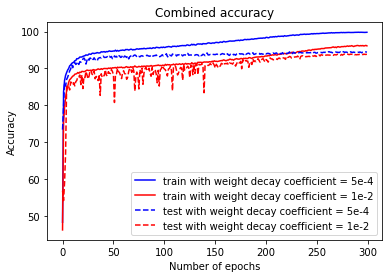

In [16]:
plt.plot(range(len(train_acc_list_5e4)), train_acc_list_5e4, 'b')
plt.plot(range(len(train_acc_list_1e2)), train_acc_list_1e2, 'r')
#plt.plot(range(len(train_acc_list_step)), train_acc_list_step, 'g')
#plt.plot(range(len(train_acc_list_linear)), train_acc_list_linear, 'y')
#plt.plot(range(len(train_acc_list_exp)), train_acc_list_exp, 'purple')

plt.plot(range(len(test_acc_list_5e4)), test_acc_list_5e4, color='b', linestyle='--')
plt.plot(range(len(test_acc_list_1e2)), test_acc_list_1e2,color='r', linestyle='--')
#plt.plot(range(len(test_acc_list_step)), test_acc_list_step, color='g', linestyle='--')
#plt.plot(range(len(test_acc_list_linear)), test_acc_list_linear, color='y', linestyle='--')
#plt.plot(range(len(test_acc_list_exp)), test_acc_list_exp, color='purple', linestyle='--')

plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
#plt.ylim([85, 101])
plt.title("Combined accuracy")
plt.legend(['train with weight decay coefficient = 5e-4', 'train with weight decay coefficient = 1e-2',
            'test with weight decay coefficient = 5e-4', 'test with weight decay coefficient = 1e-2'])


plt.show()

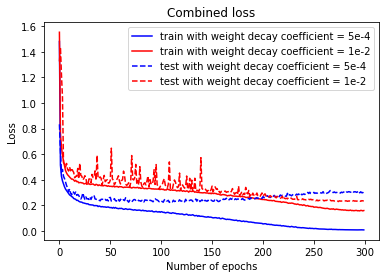

In [17]:
plt.plot(range(len(train_loss_list_5e4)), train_loss_list_5e4, 'b')
plt.plot(range(len(train_loss_list_1e2)), train_loss_list_1e2, 'r')
#plt.plot(range(len(train_loss_list_step)), train_loss_list_step, 'g')
#plt.plot(range(len(train_loss_list_linear)), train_loss_list_linear, 'y')
#plt.plot(range(len(train_loss_list_exp)), train_loss_list_exp, 'purple')

plt.plot(range(len(test_loss_list_5e4)), test_loss_list_5e4, color='b', linestyle='--')
plt.plot(range(len(test_loss_list_1e2)), test_loss_list_1e2,color='r', linestyle='--')
#plt.plot(range(len(test_loss_list_step)), test_loss_list_step, color='g', linestyle='--')
#plt.plot(range(len(test_loss_list_linear)), test_loss_list_linear, color='y', linestyle='--')
#plt.plot(range(len(test_loss_list_exp)), test_loss_list_exp, color='purple', linestyle='--')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
#plt.ylim([85, 101])
plt.title("Combined loss")
plt.legend(['train with weight decay coefficient = 5e-4', 'train with weight decay coefficient = 1e-2',
            'test with weight decay coefficient = 5e-4', 'test with weight decay coefficient = 1e-2'])


plt.show()